# Kaggle August Playground Series

Task is to predict whether a product will fail (1) or succeed (0) in cleaning up a spill.

Components of this workbook:

* EDA
    * sweetviz
        * train
        * test
    * AUC comparisons
    * 17 vs variables by product_code
    * Missingness
* Modeling
    * Nested CV
    * Iterative imputation using:
        * Grouped linear regression
        * lightgbm
        * mixed effects regression
* 

## EDA

Using the `sweetviz` library: <https://github.com/fbdesignpro/sweetviz>

After downloading and unzipping `train.csv` and `test.csv` to local folder

### General Associations

Takeaways from this section:

* `loading` is only feature with clear relationship to target
* Strange correlation between measurements 4-9 and measurement 17. This will be important later

In [65]:
import pandas as pd
import numpy as np
from collections import defaultdict
from itertools import combinations
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
import sweetviz as sv
import seaborn as sns

from sklearn import clone
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


In [4]:
plt.style.use("ggplot")

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:04 -> (00:00 left)



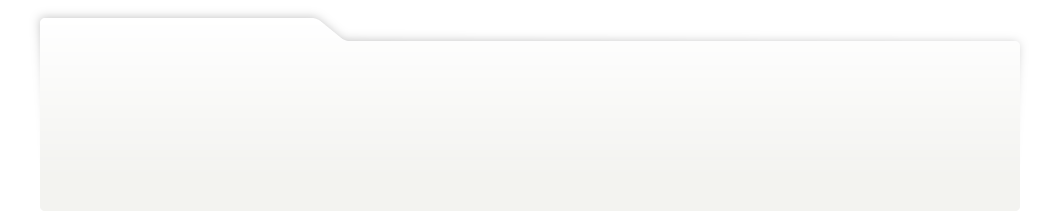
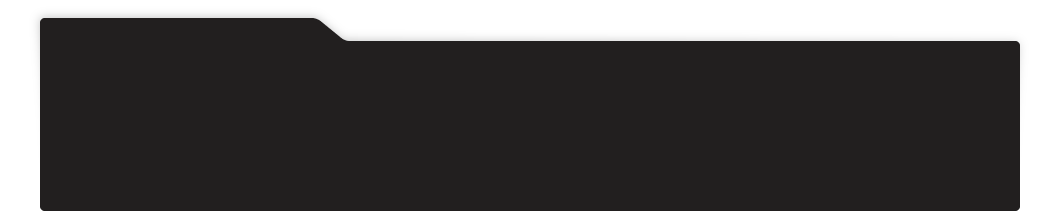
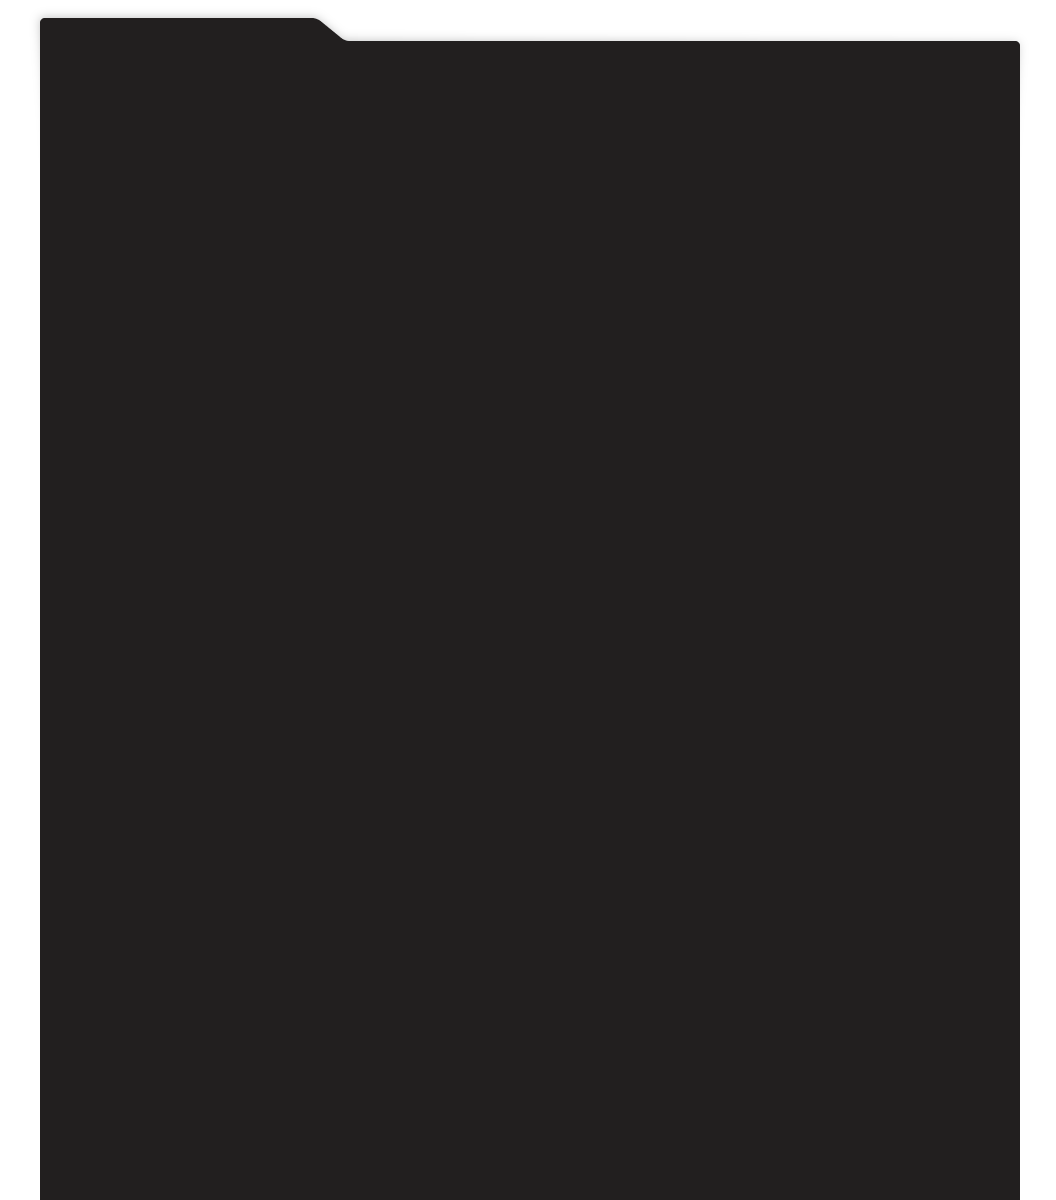
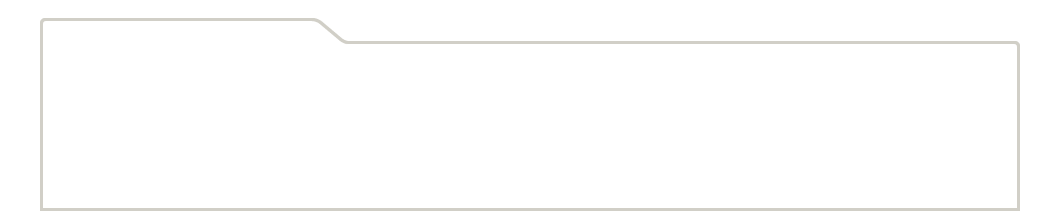
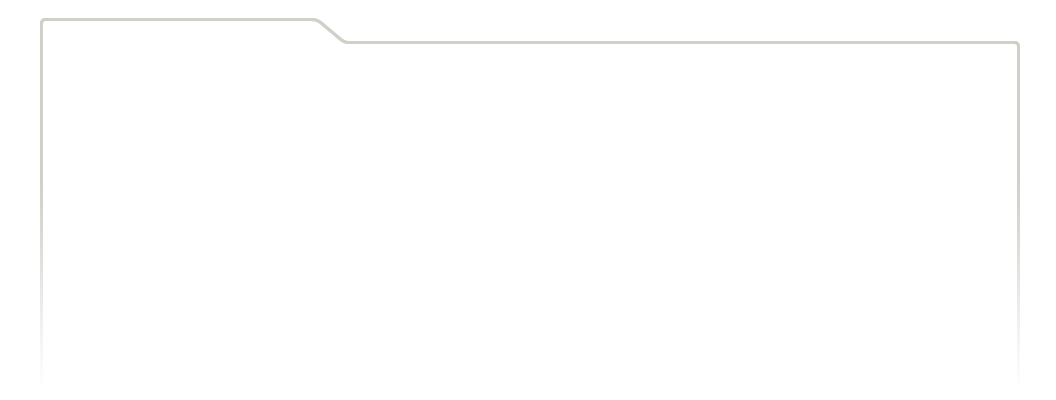
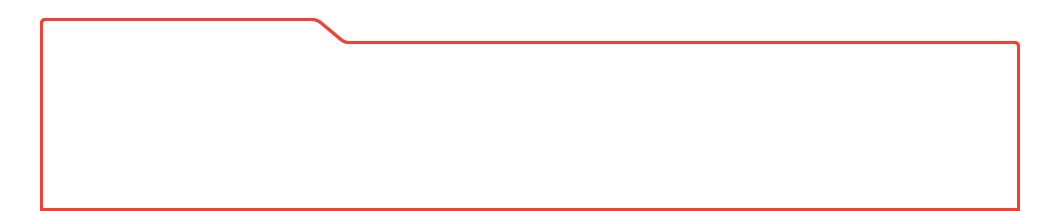
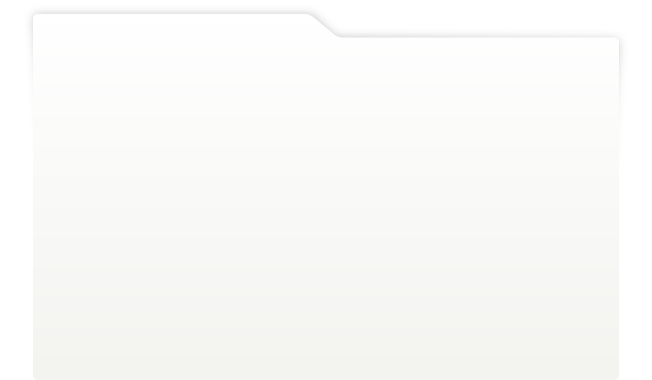
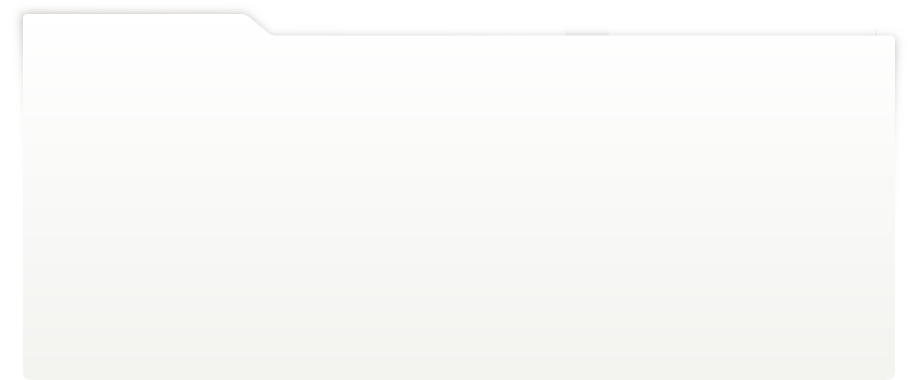
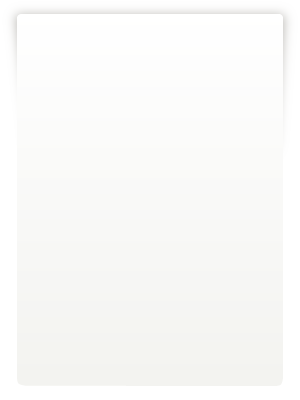
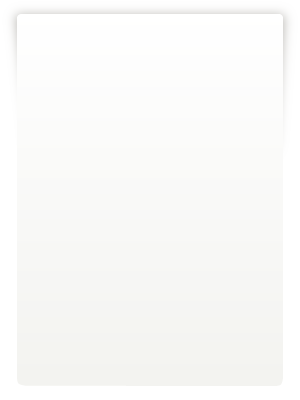
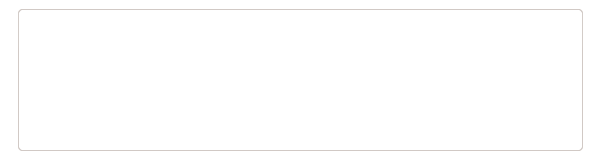
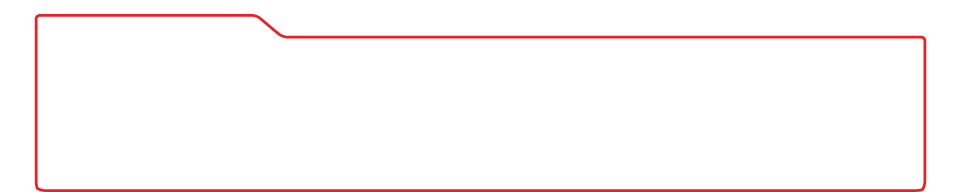
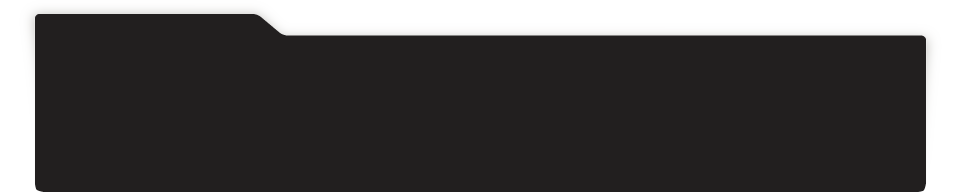
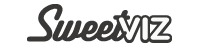
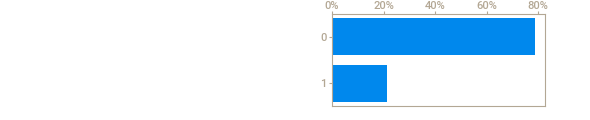
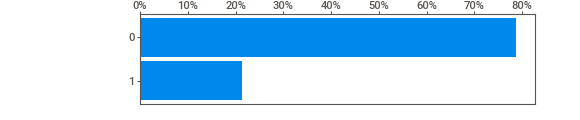
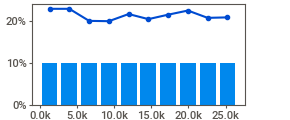
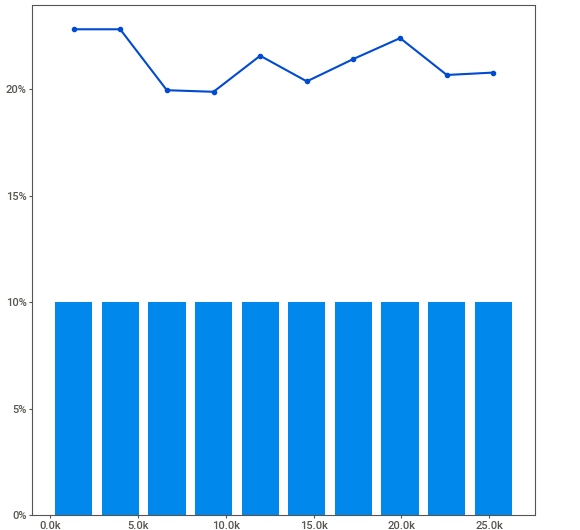
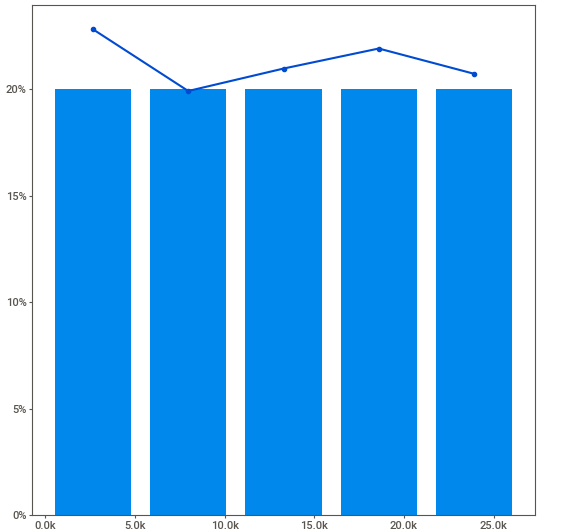
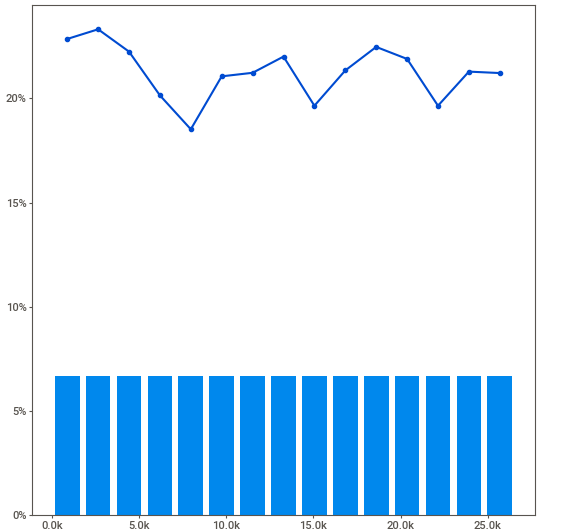
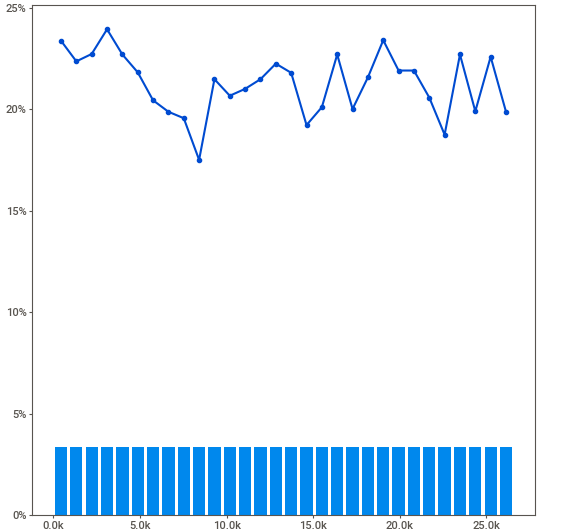
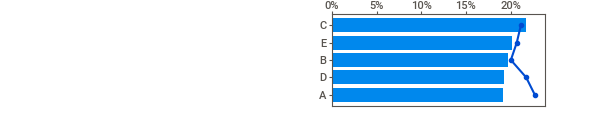
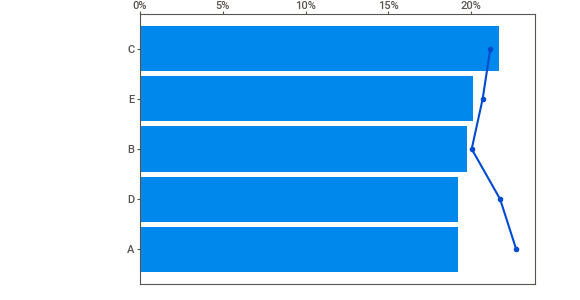
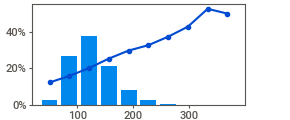
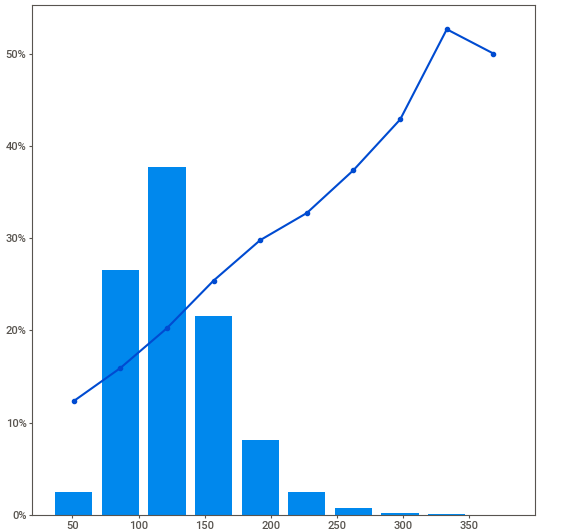
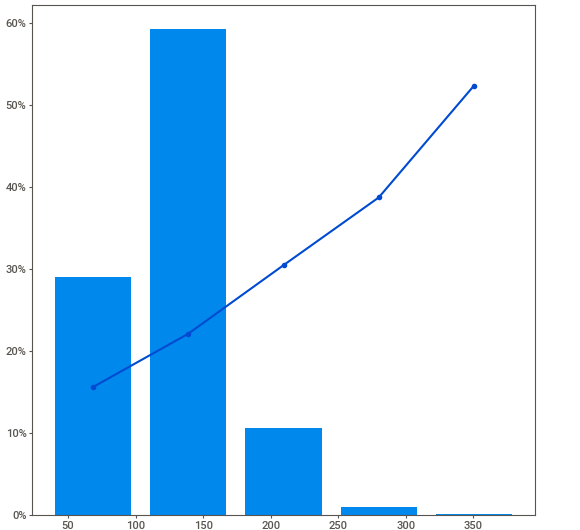
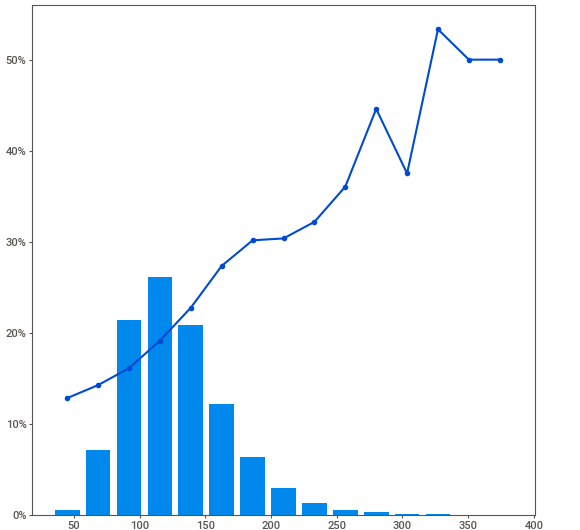
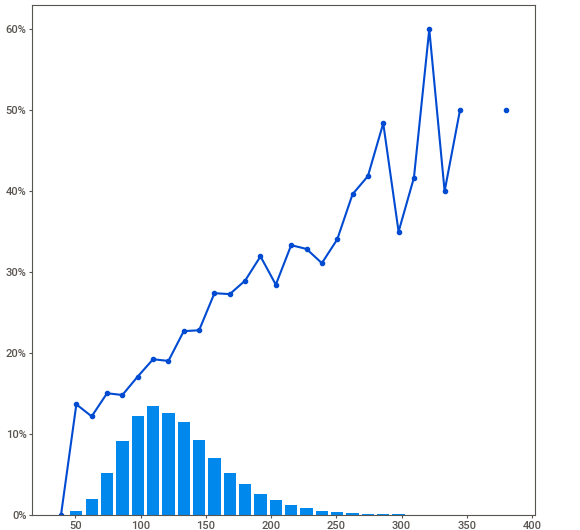
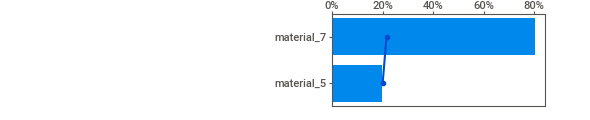
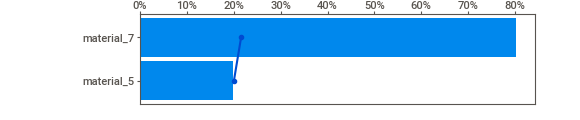
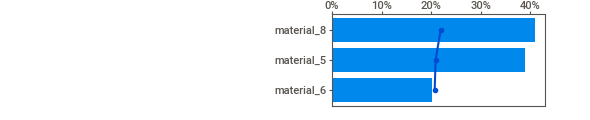
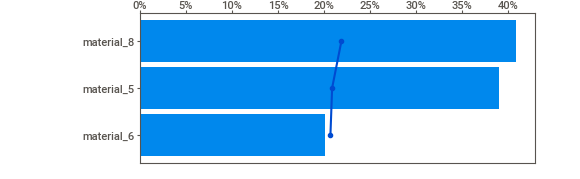
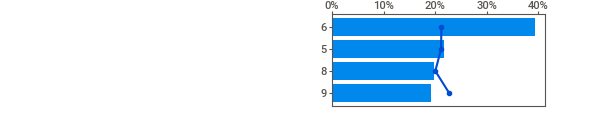
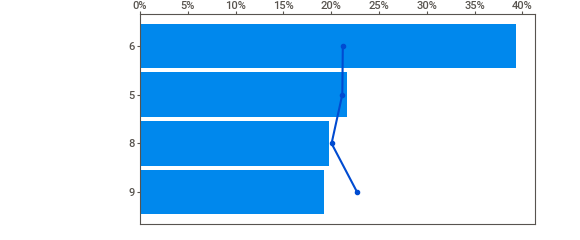
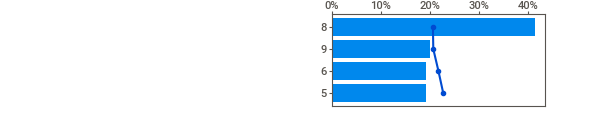
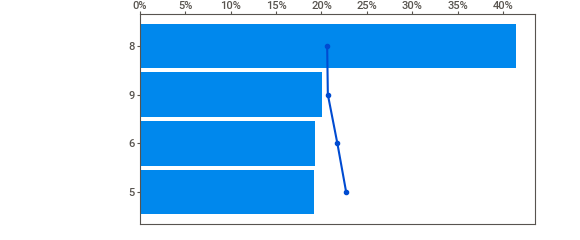
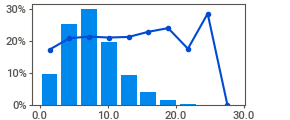
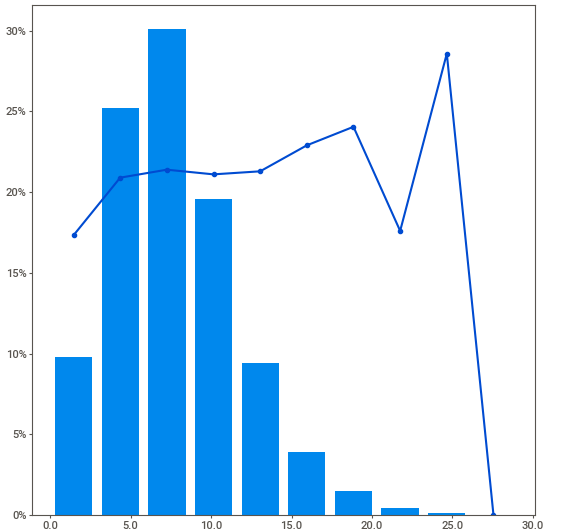
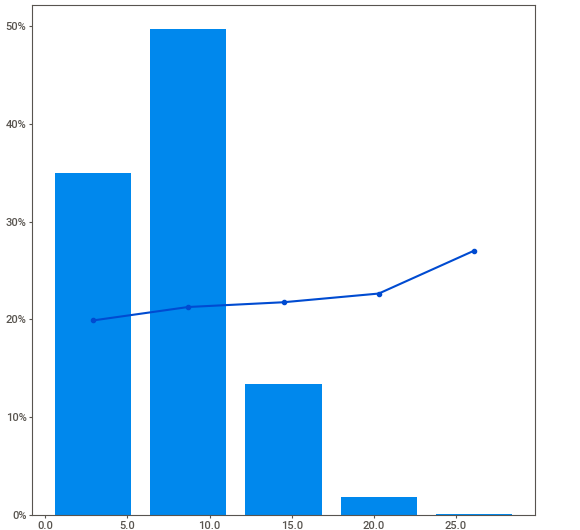
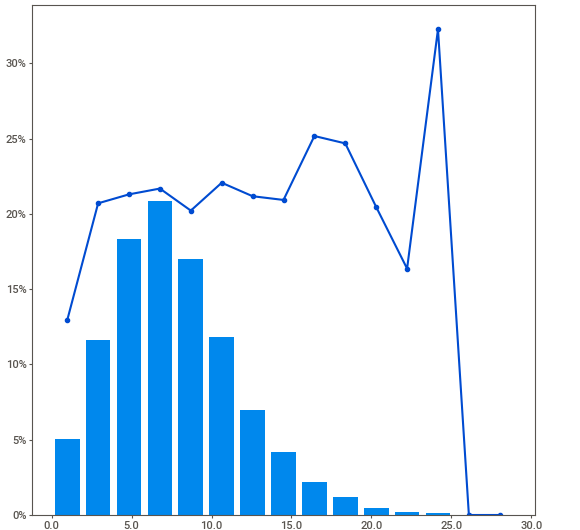
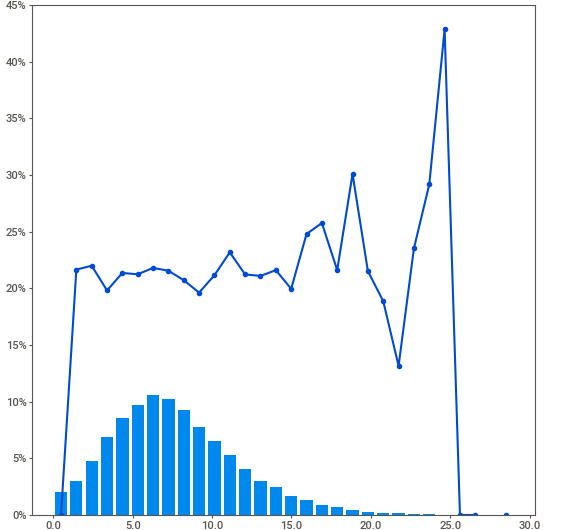
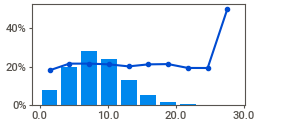
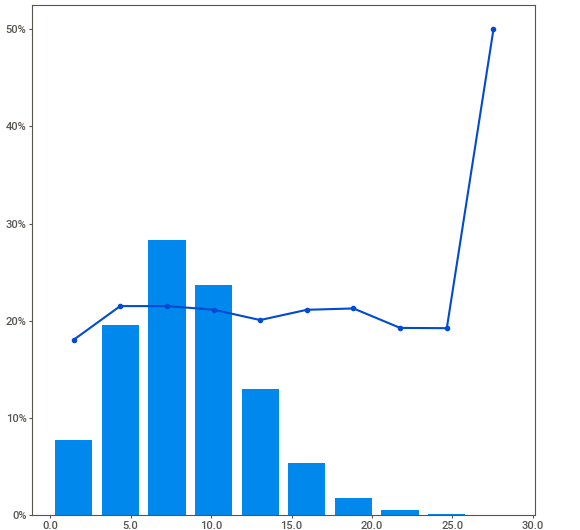
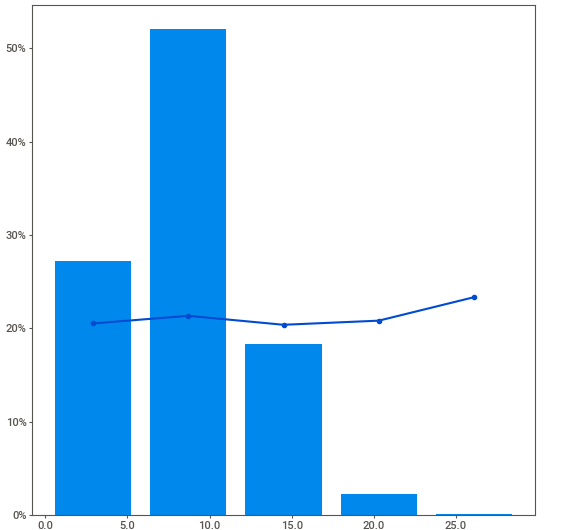
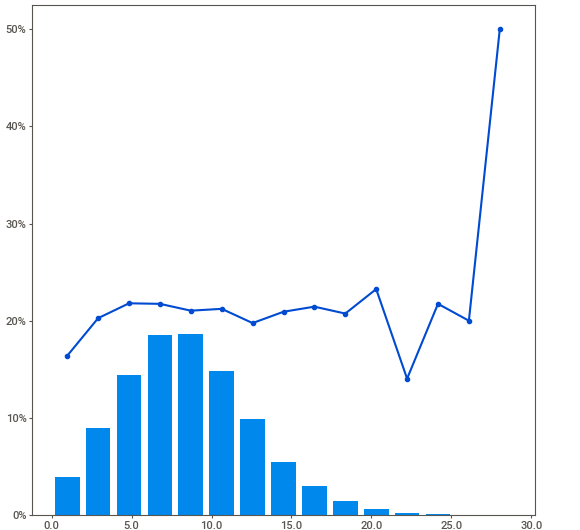
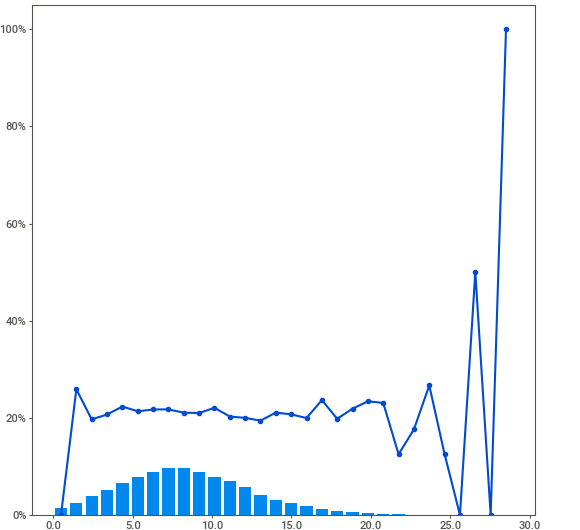
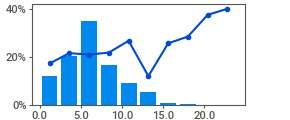
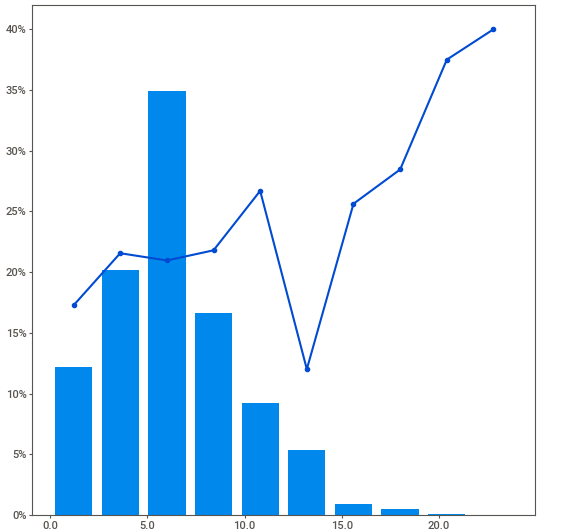
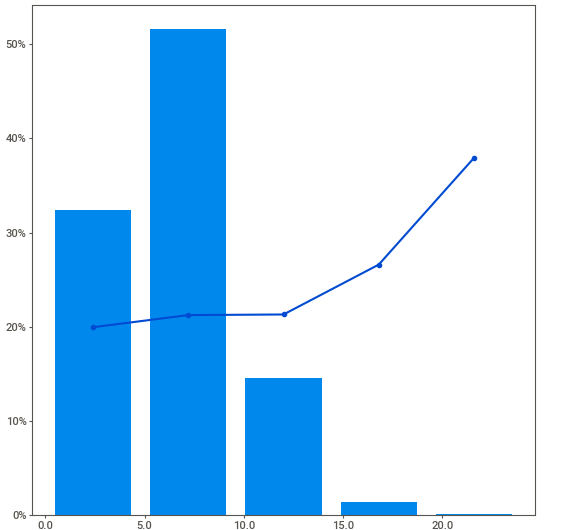
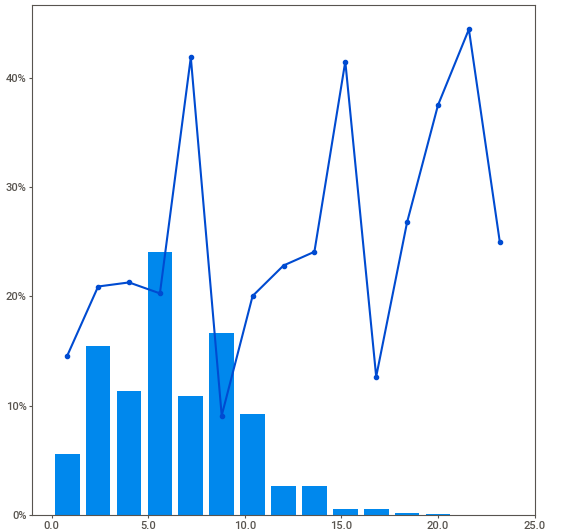
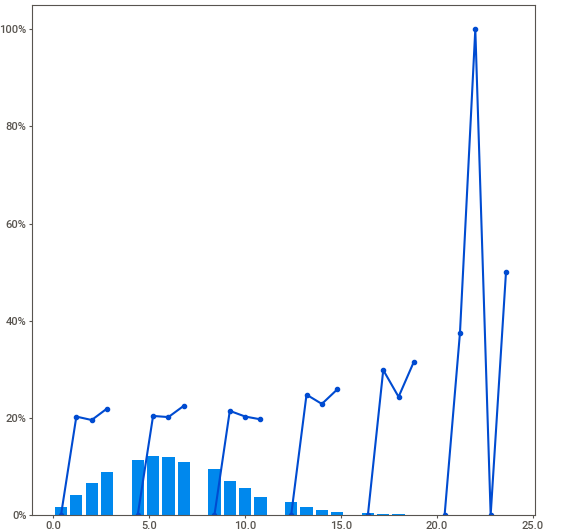
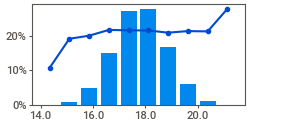
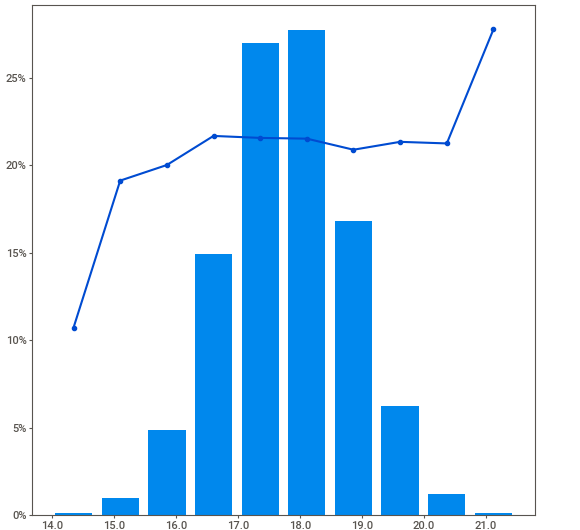
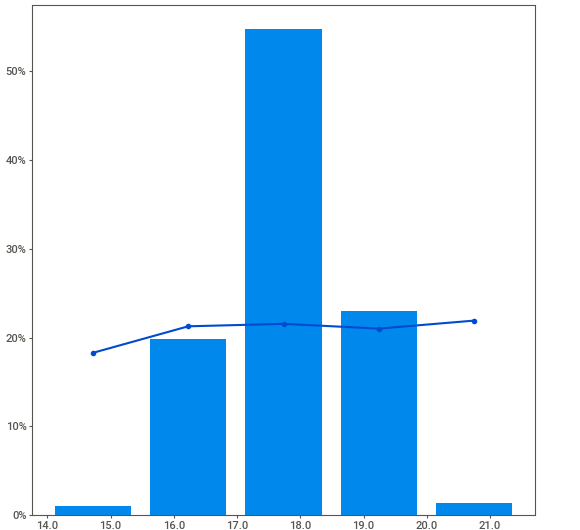
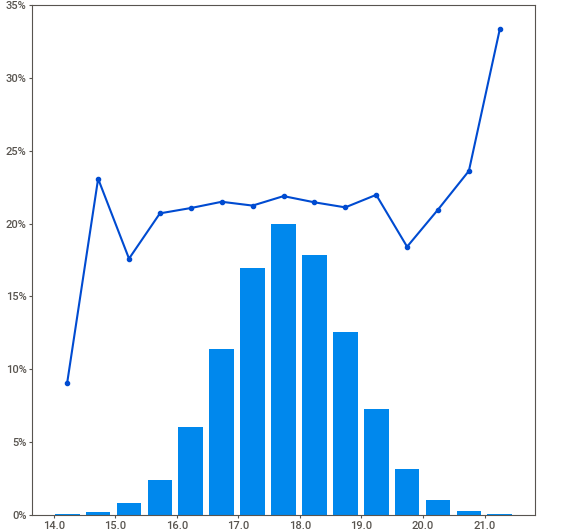
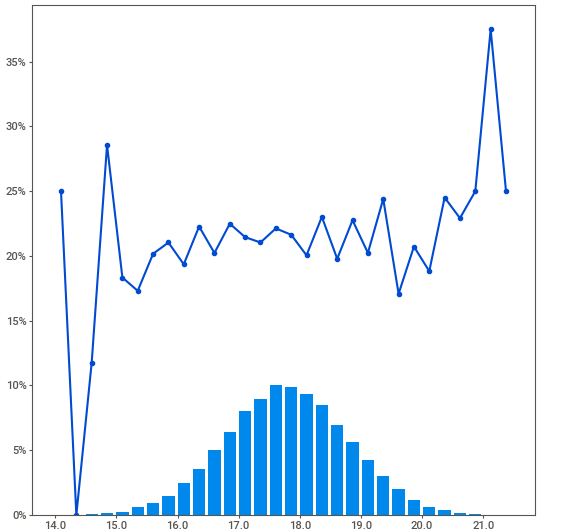
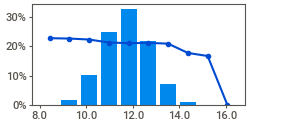
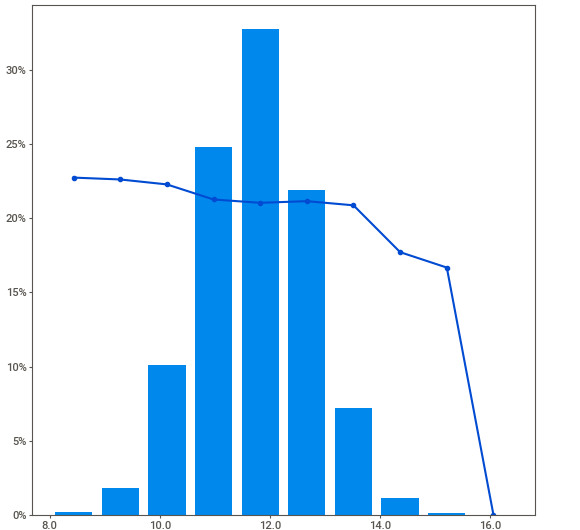
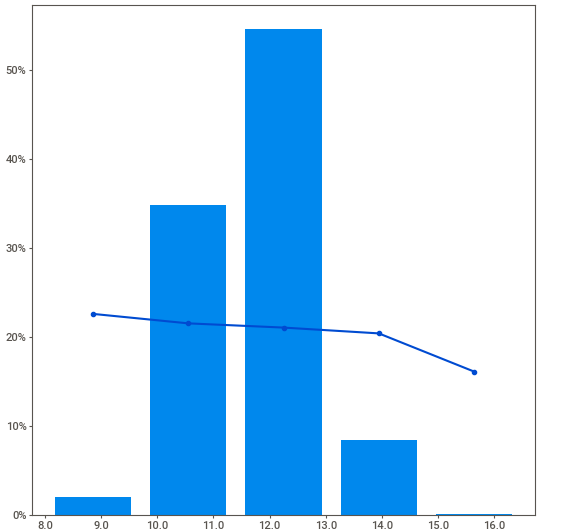
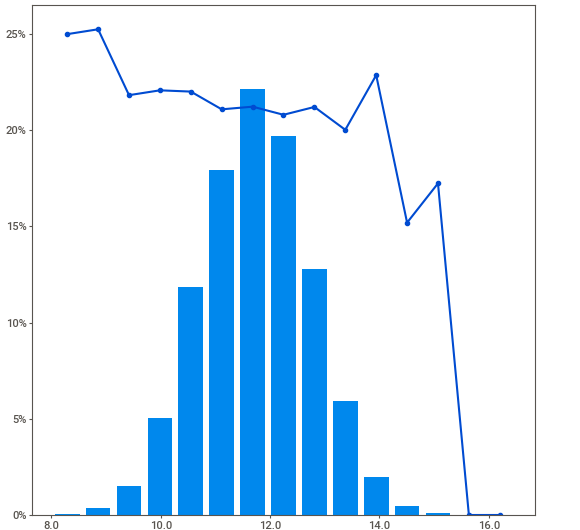
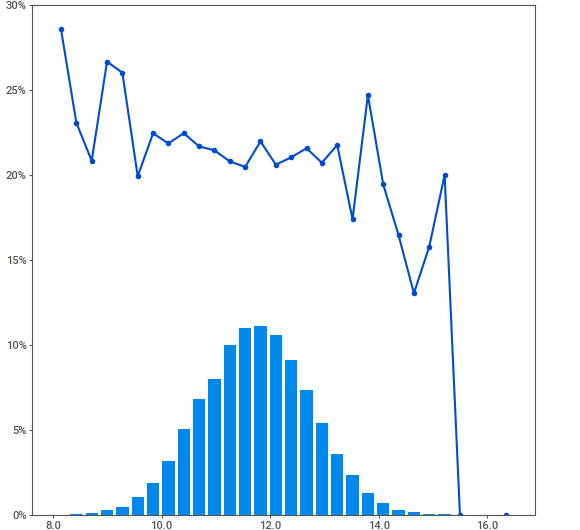
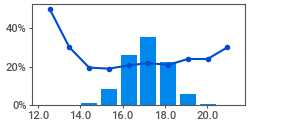
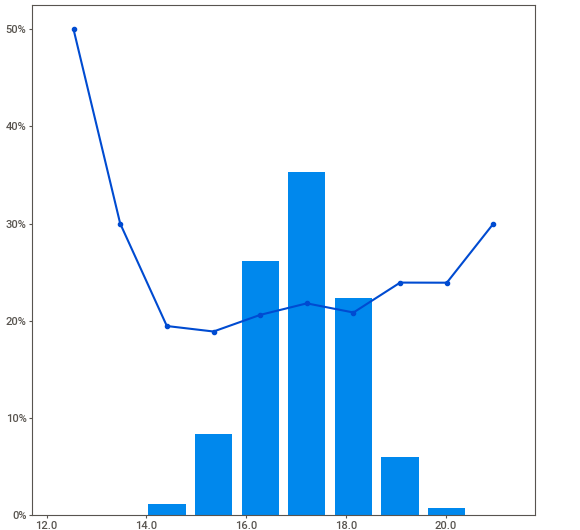
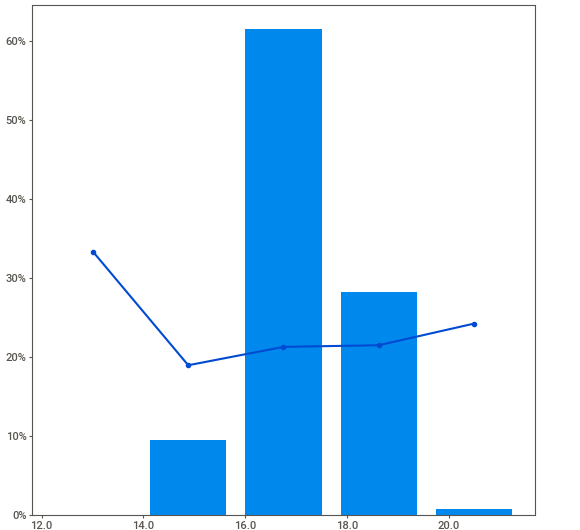
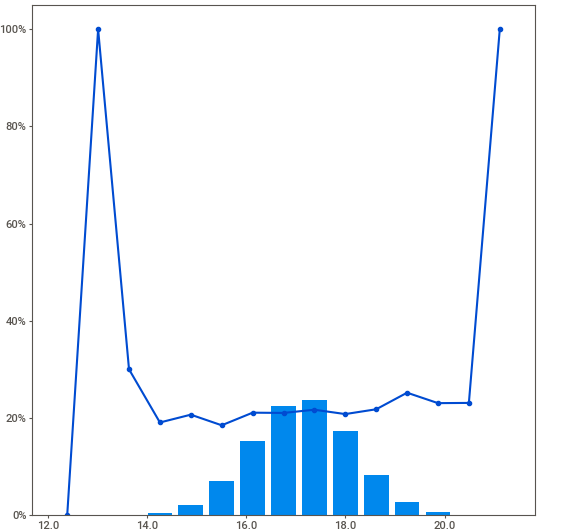
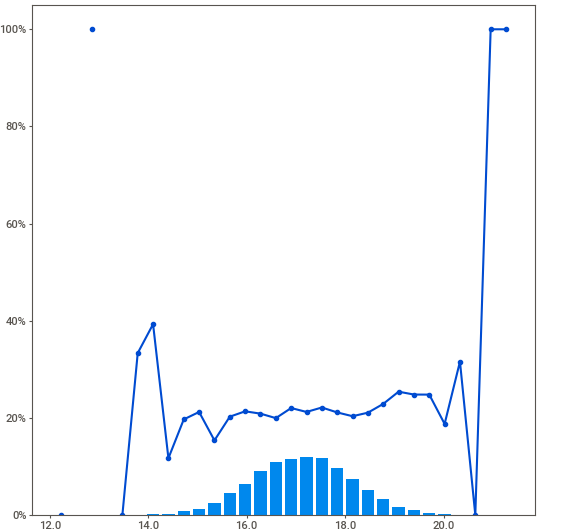
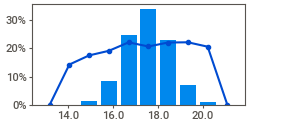
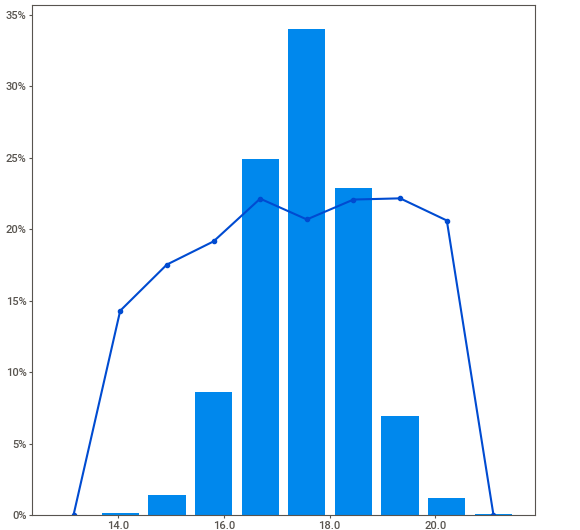
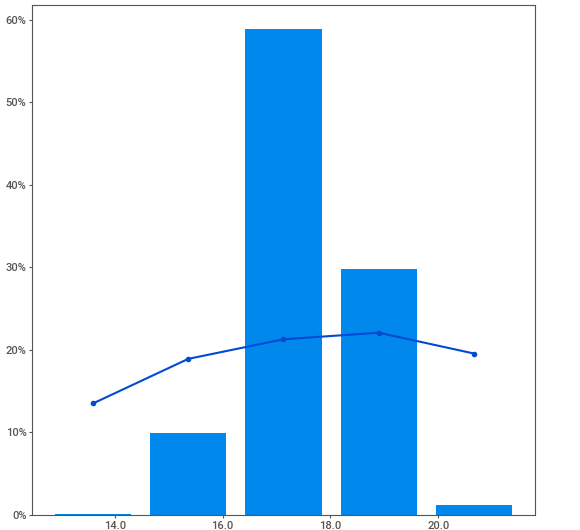
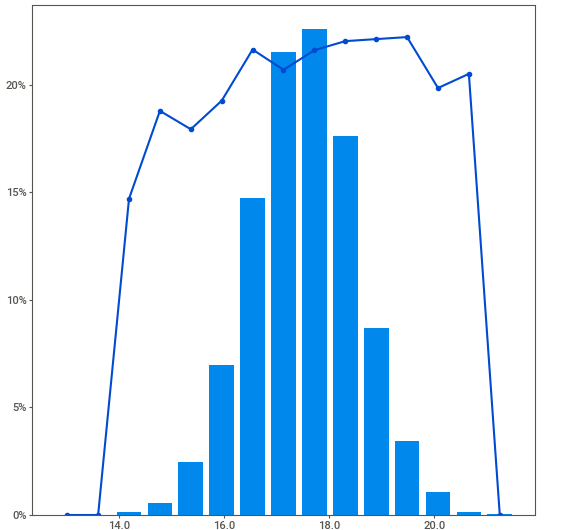
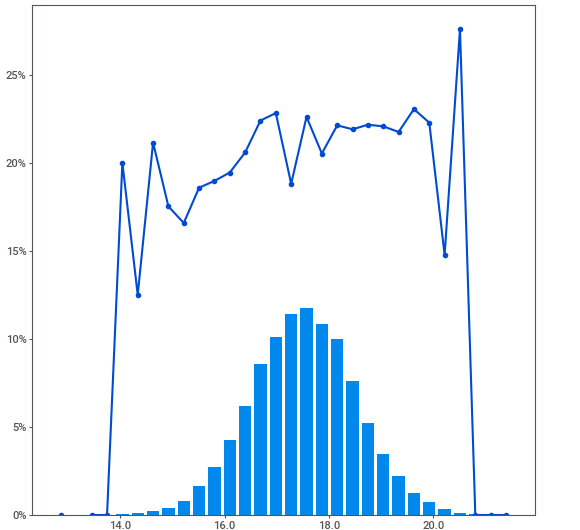
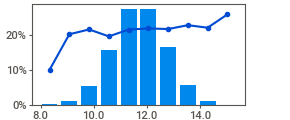
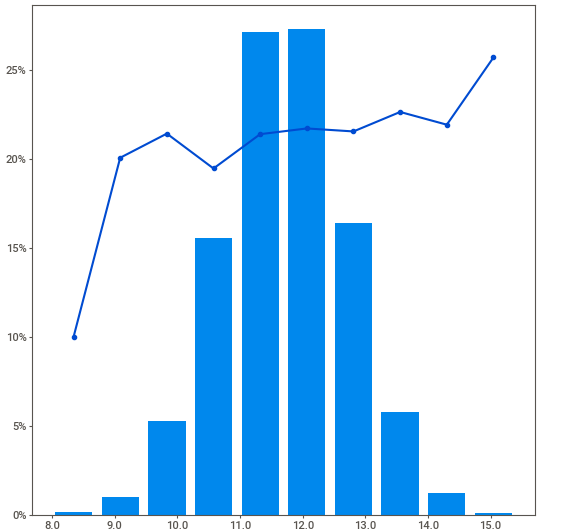
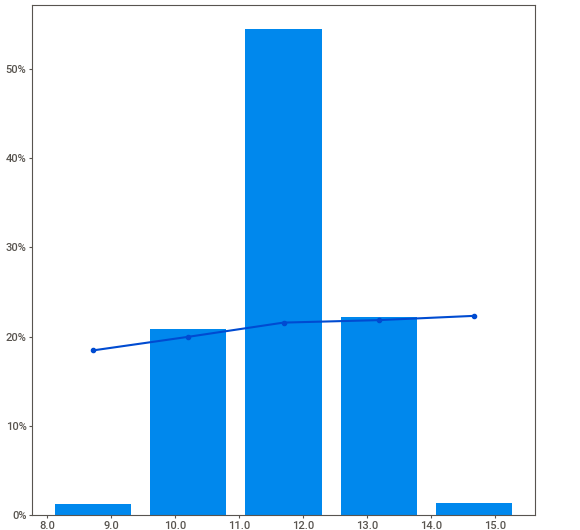
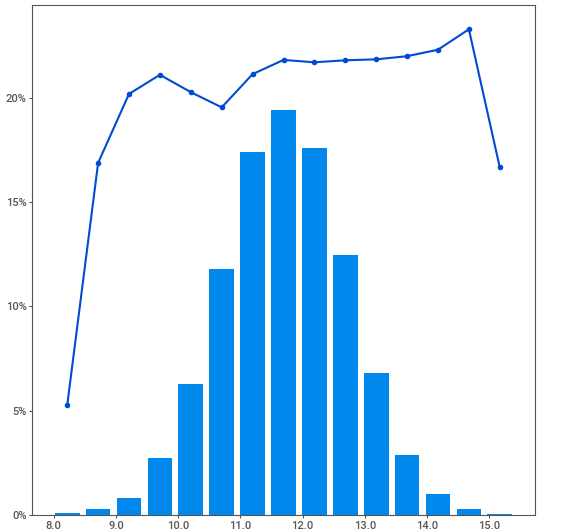
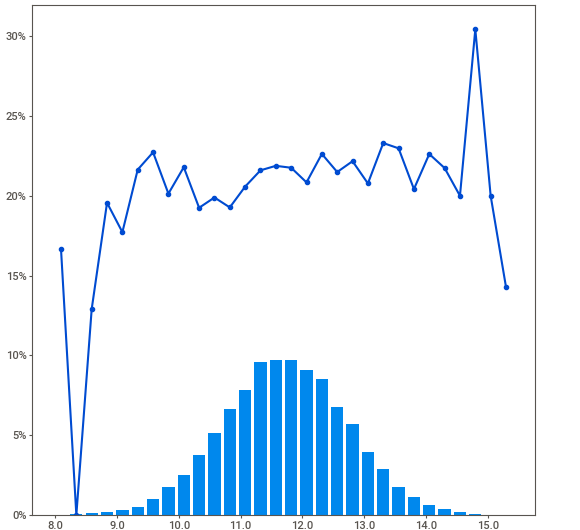
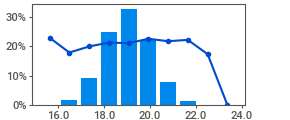
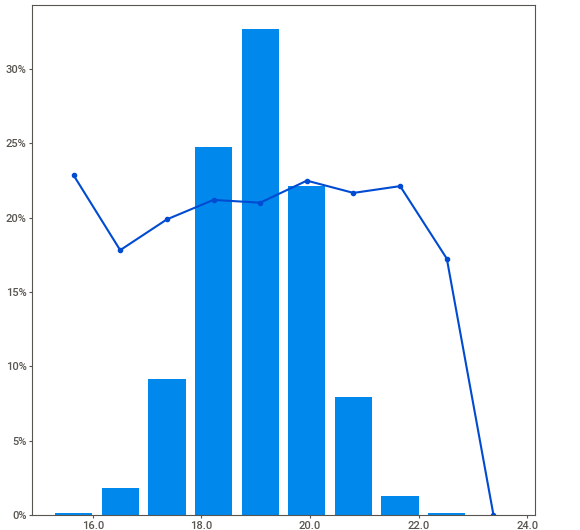
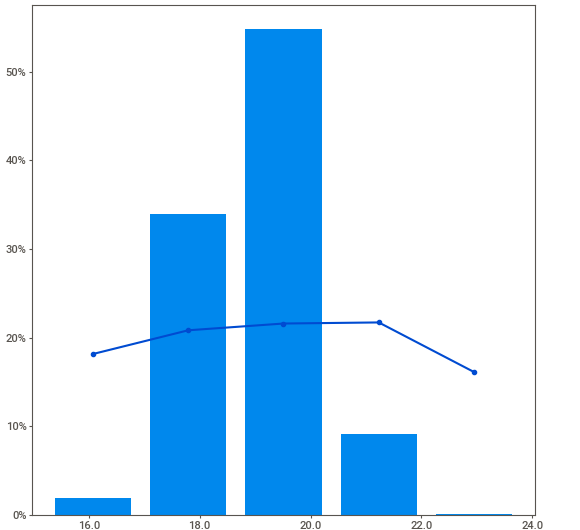
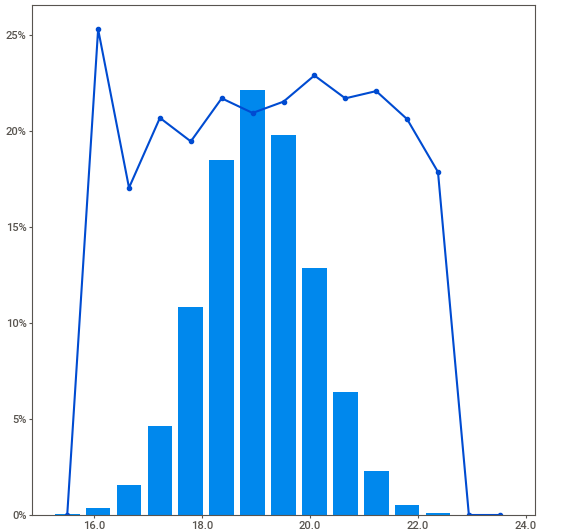
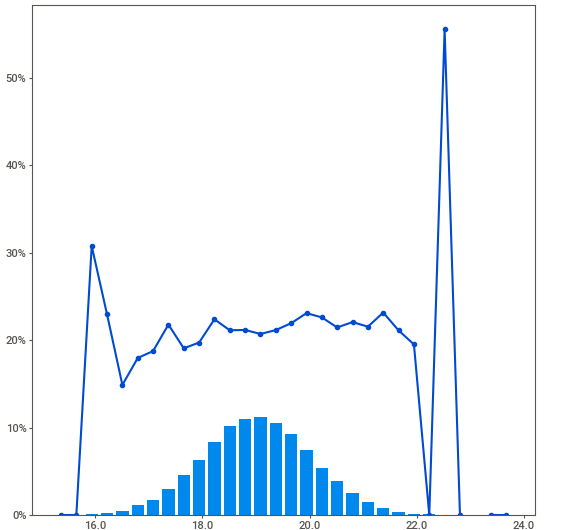
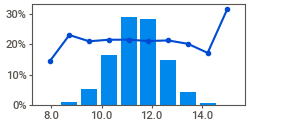
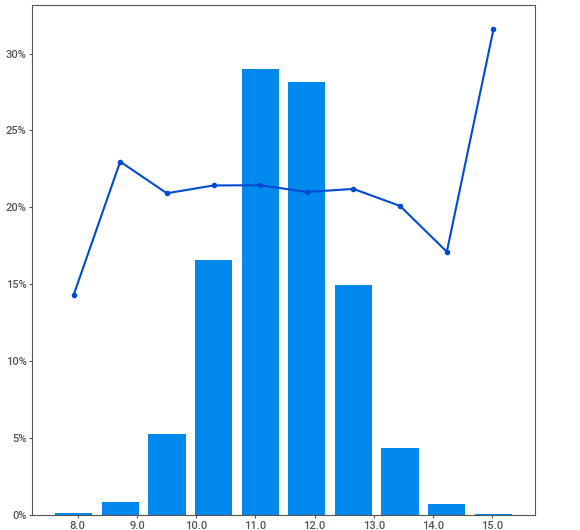
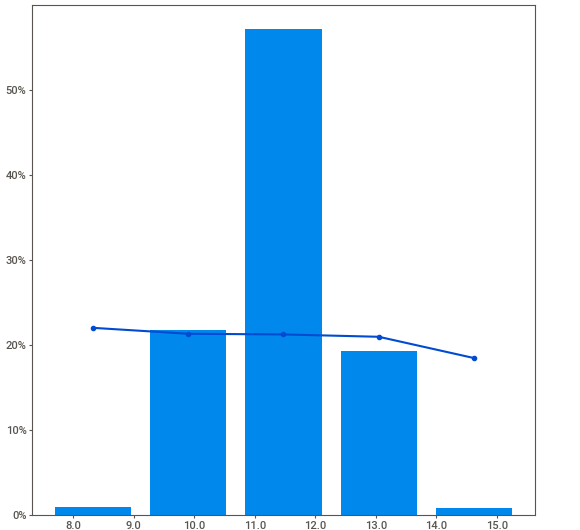
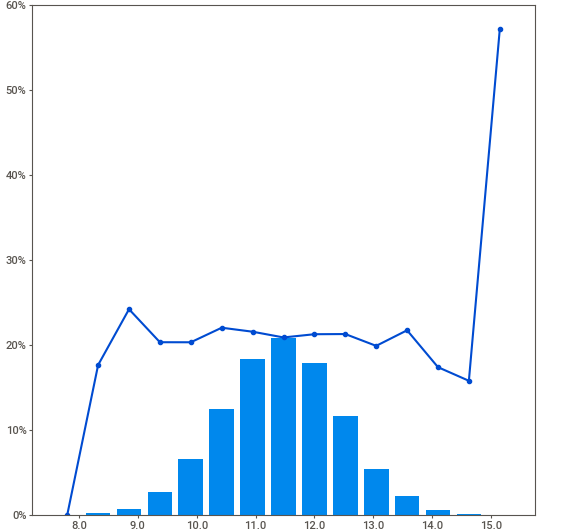
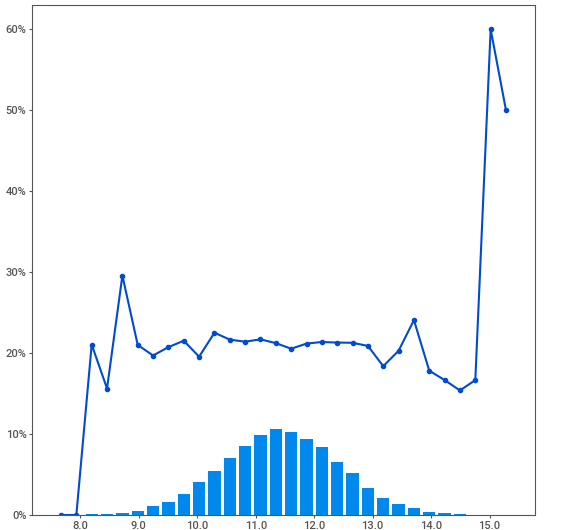
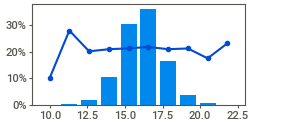
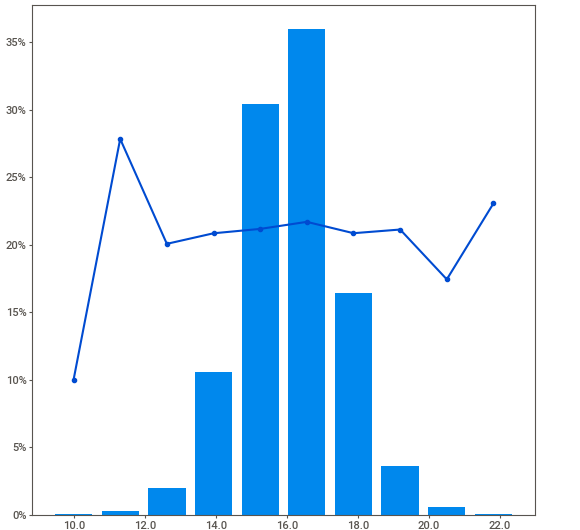
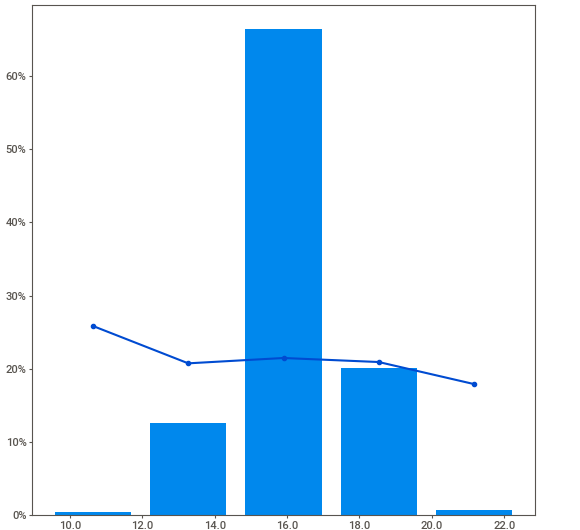
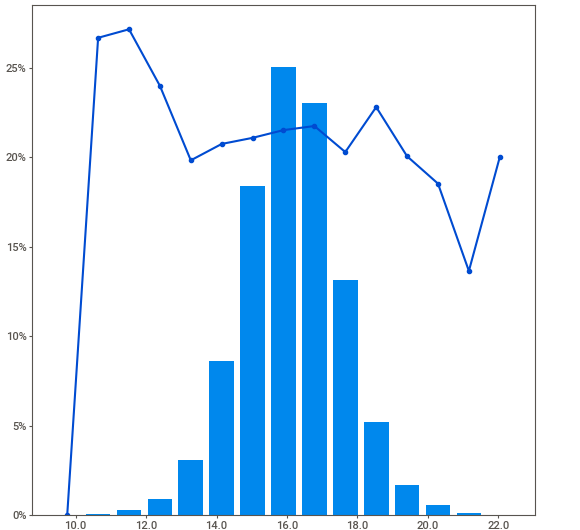
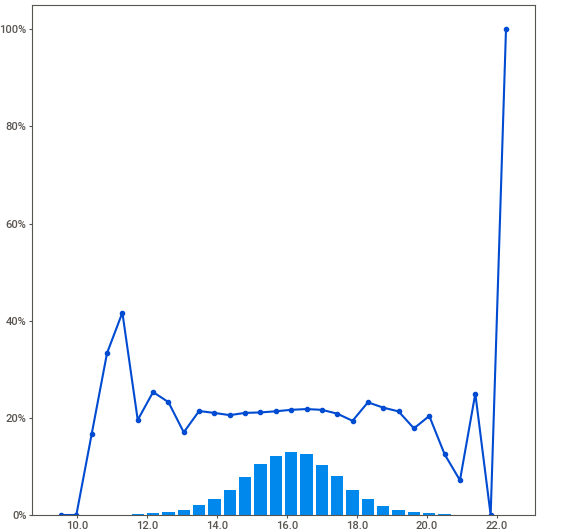
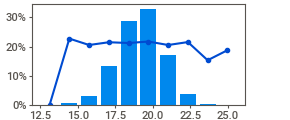
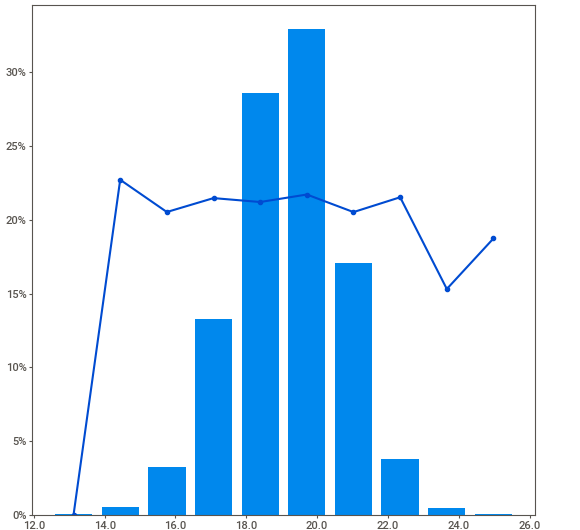
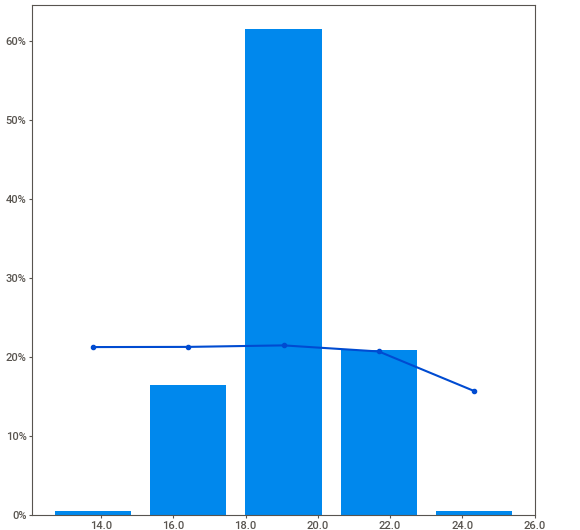
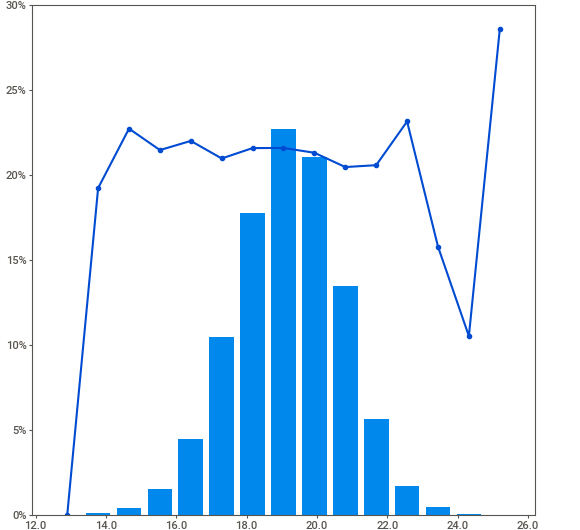
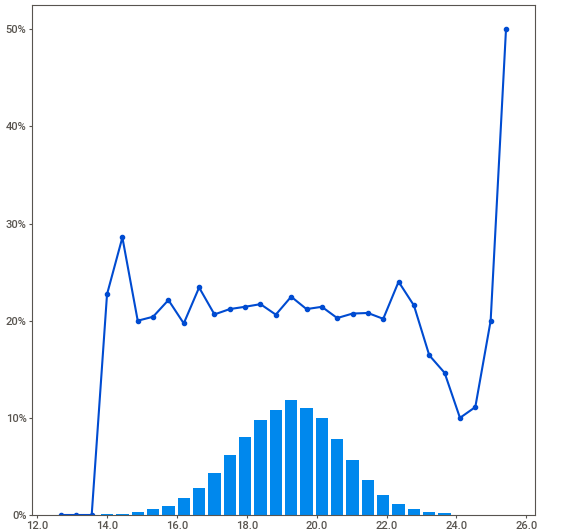
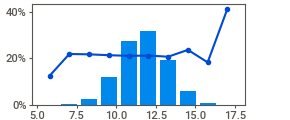
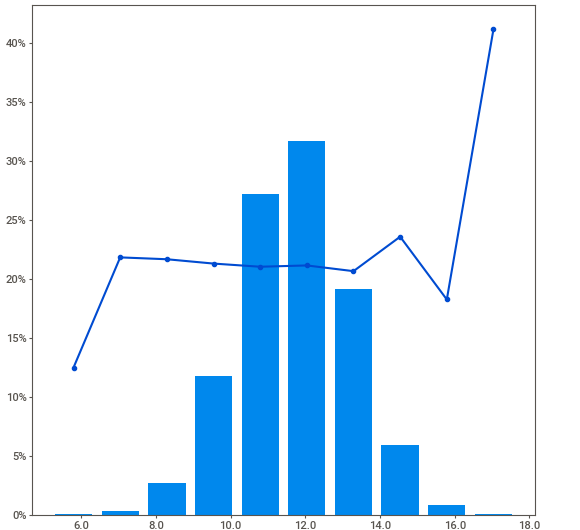
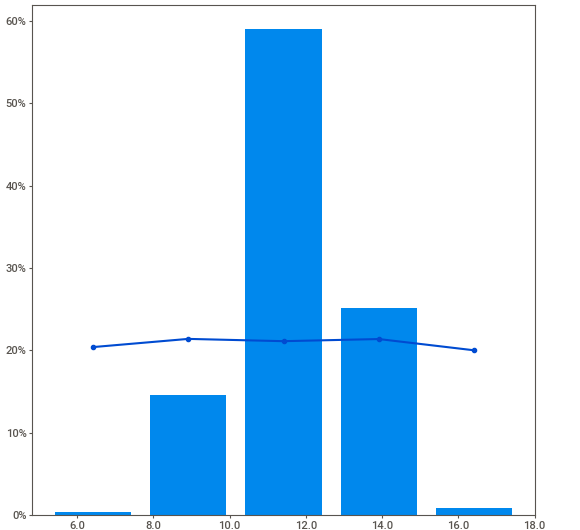
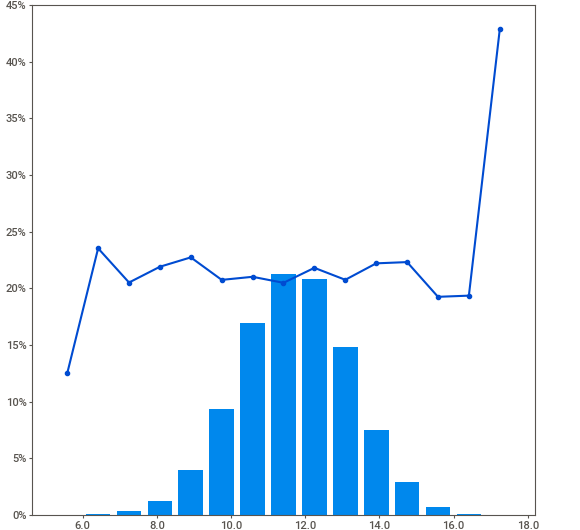
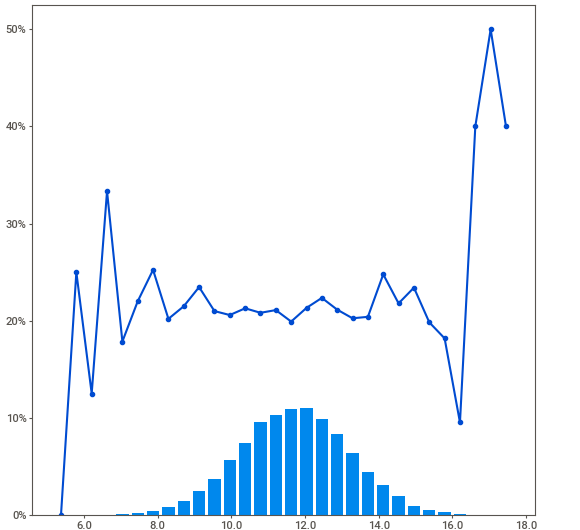
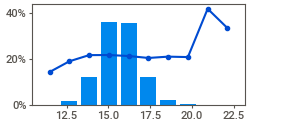
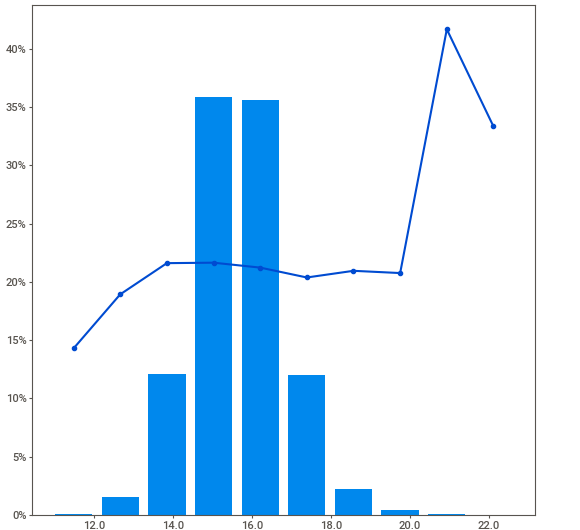
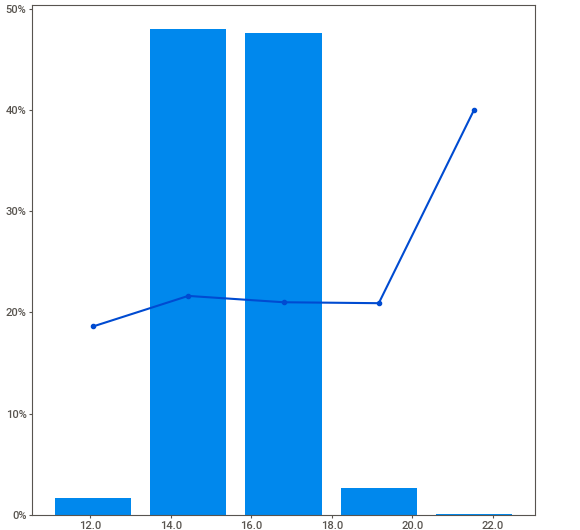
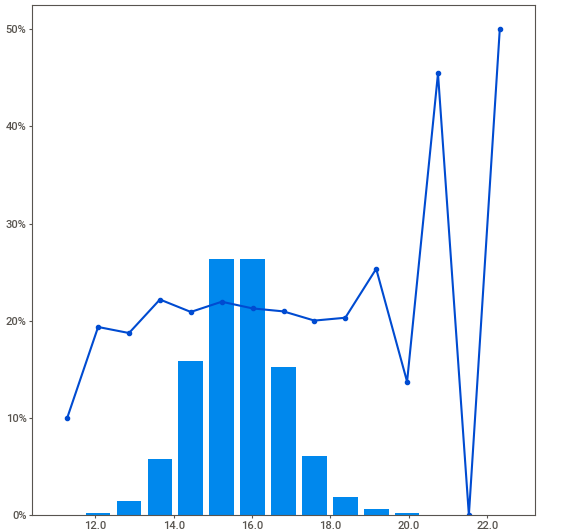
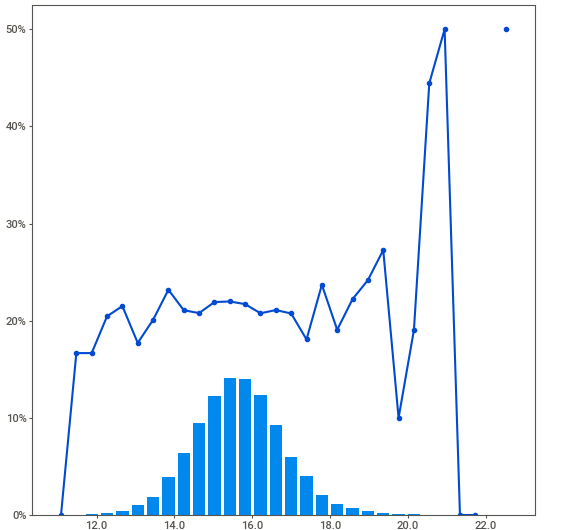
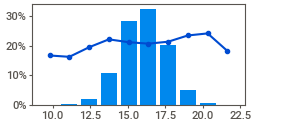
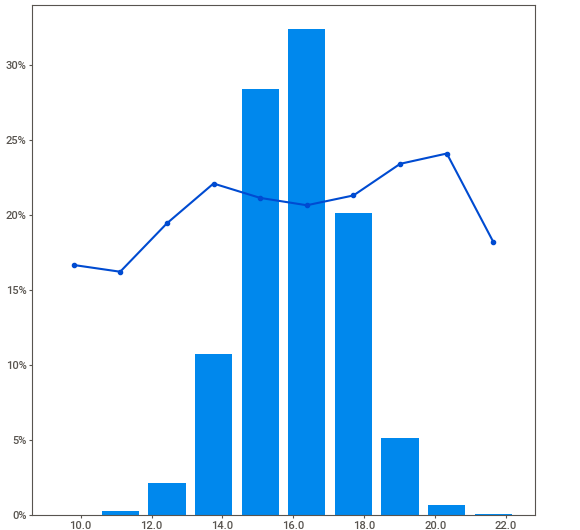
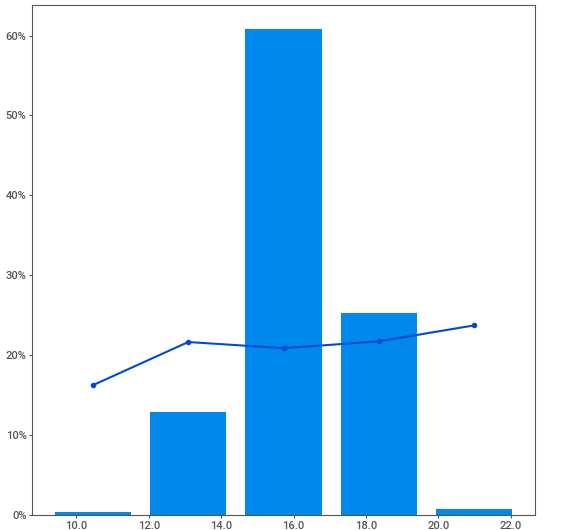
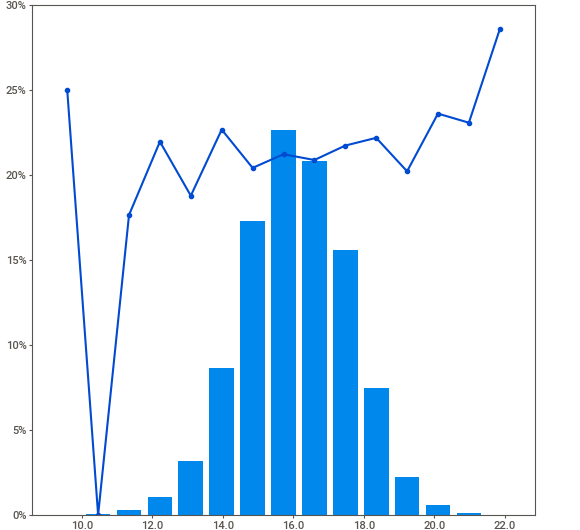
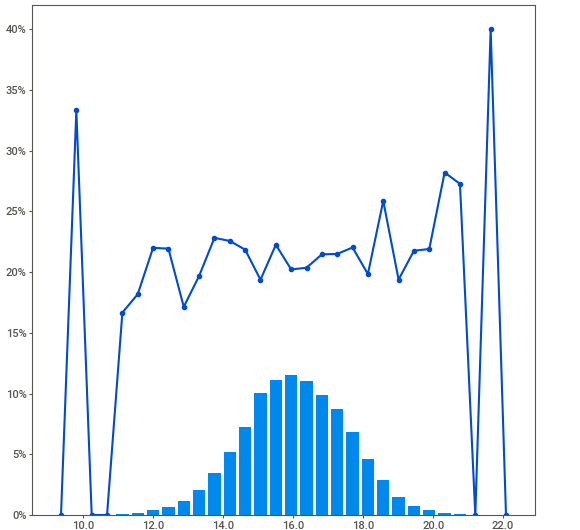
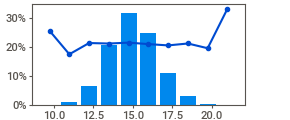
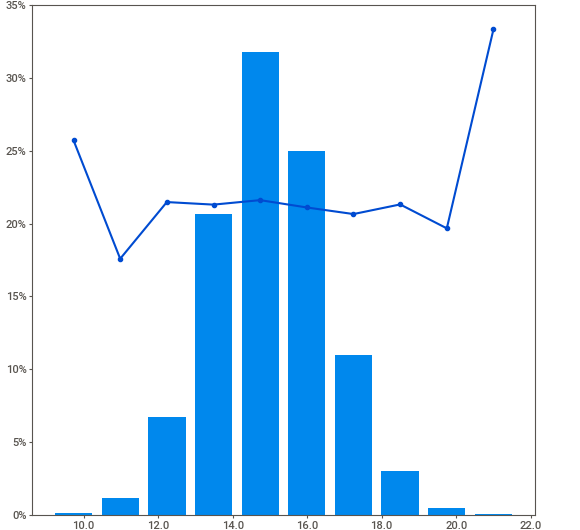
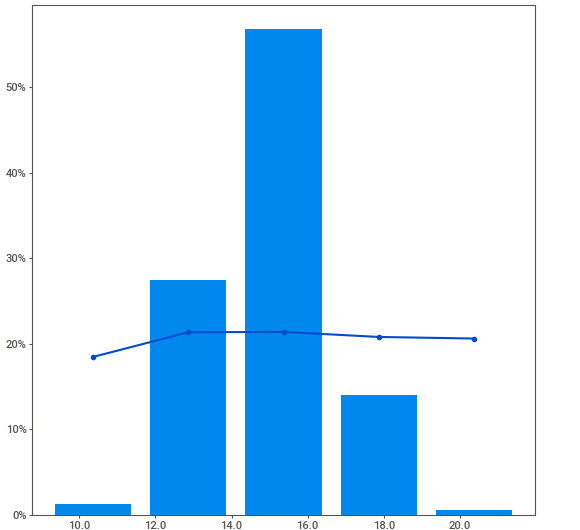
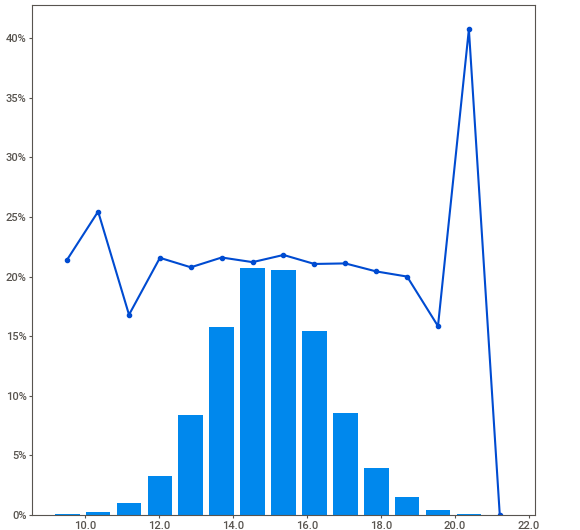
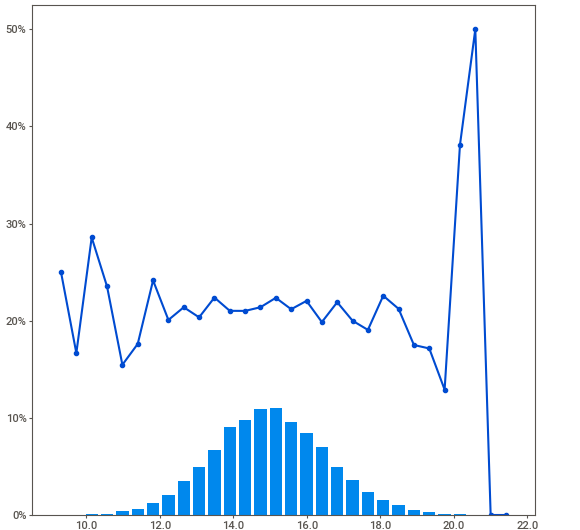
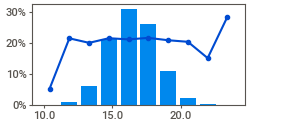
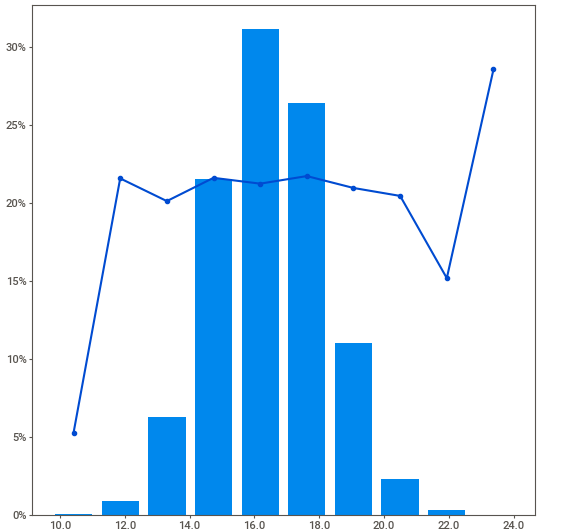
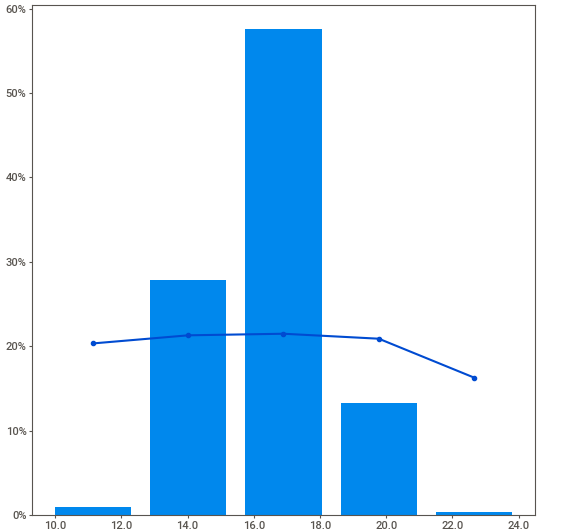
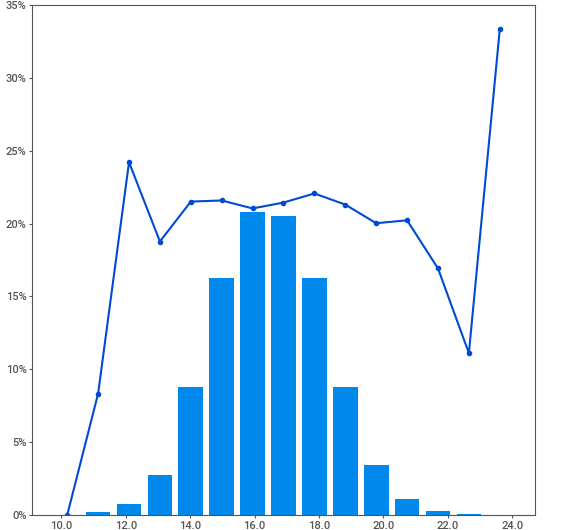
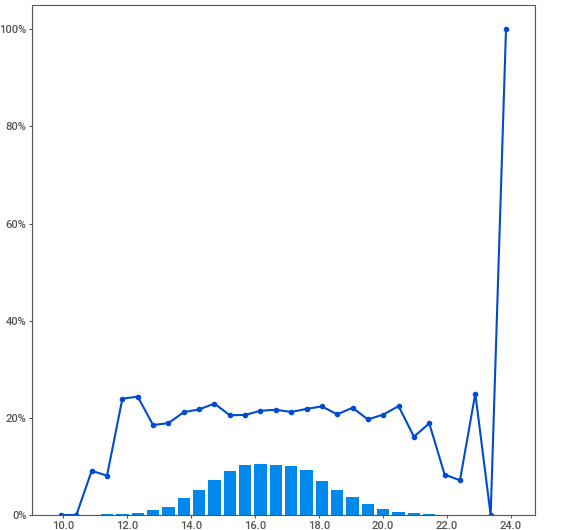
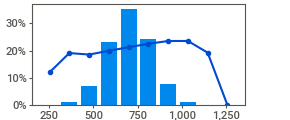
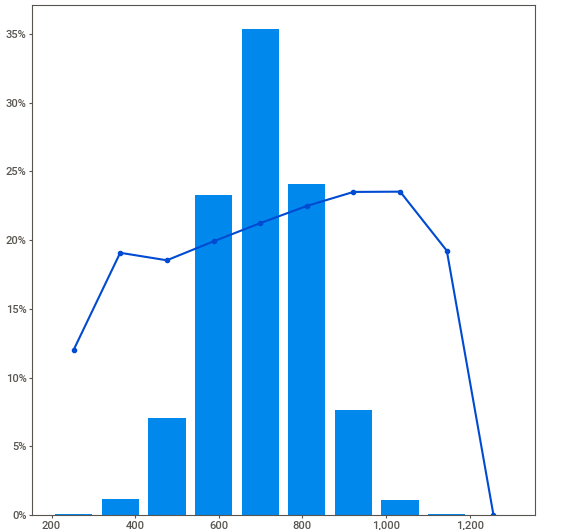
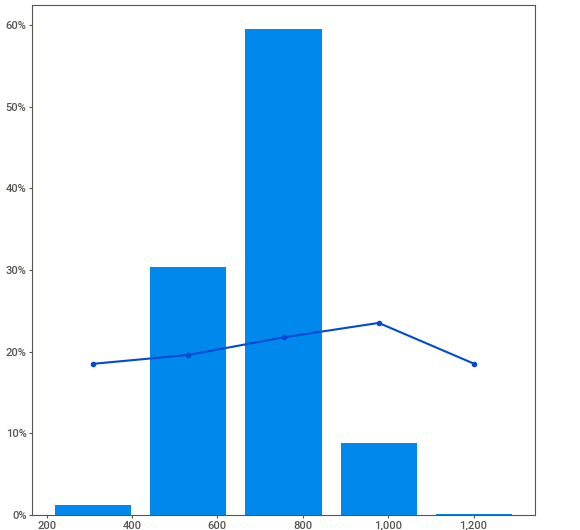
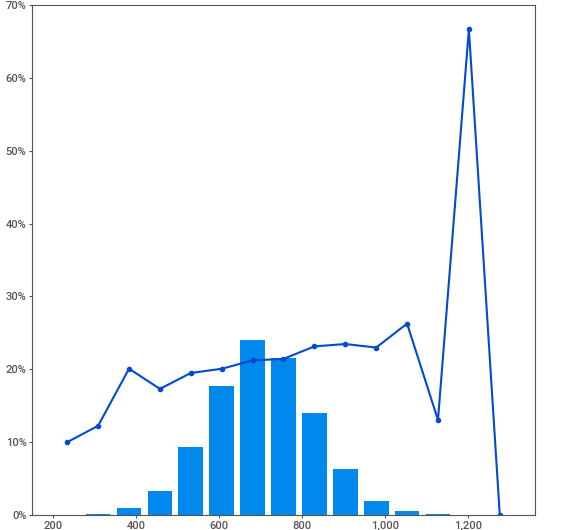
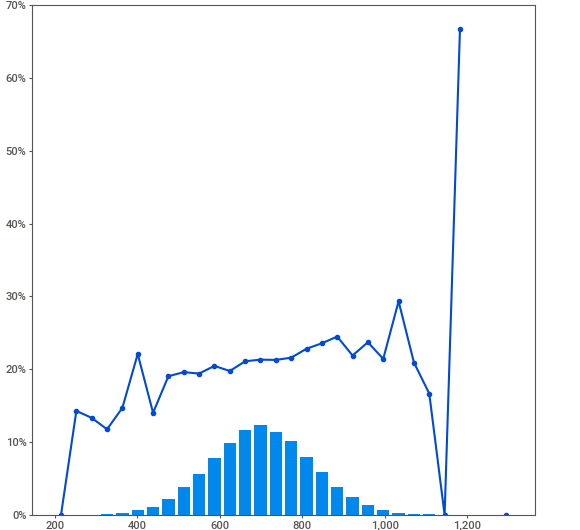
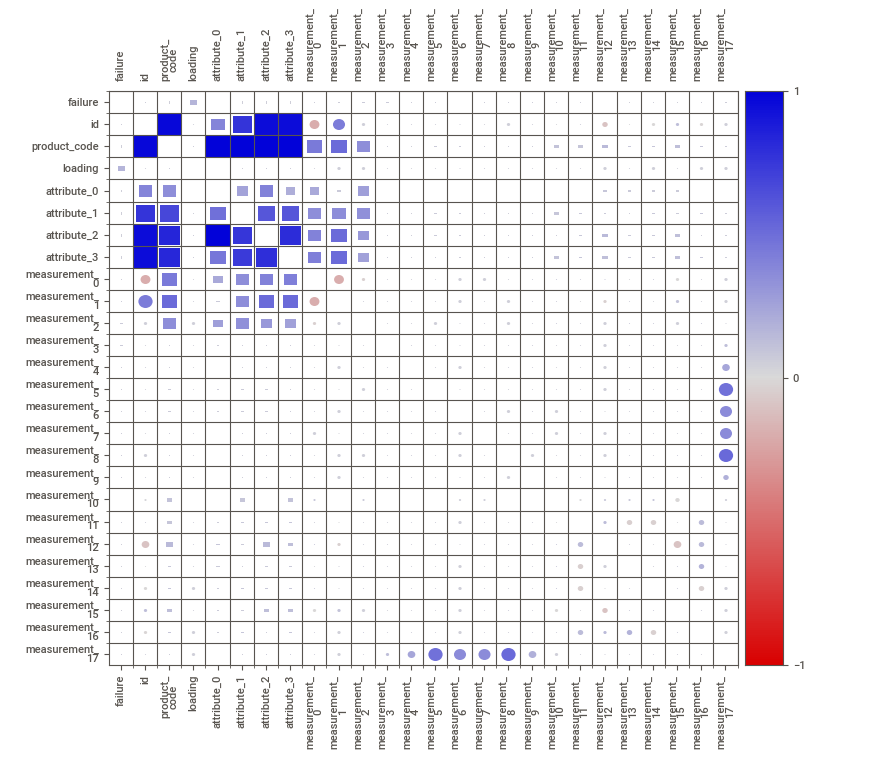
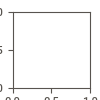

In [8]:

train_report = sv.analyze(train, target_feat="failure")
train_report.show_notebook()

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:04 -> (00:00 left)



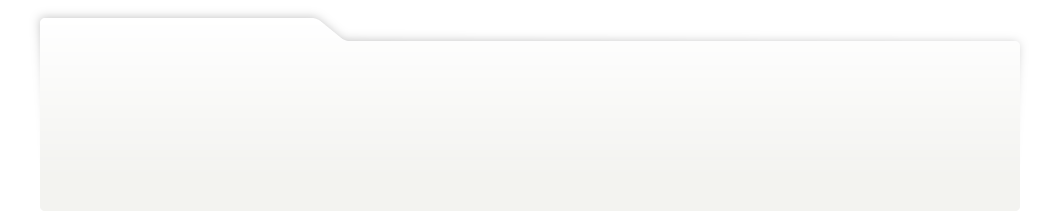
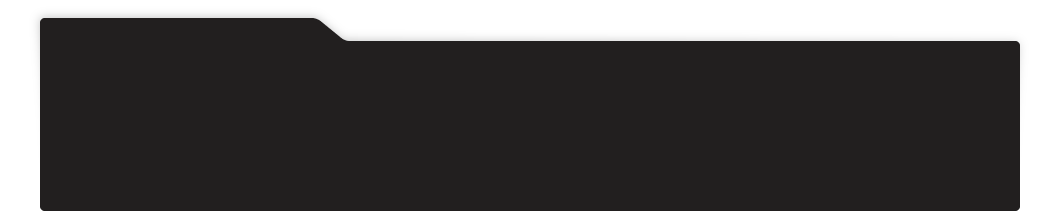
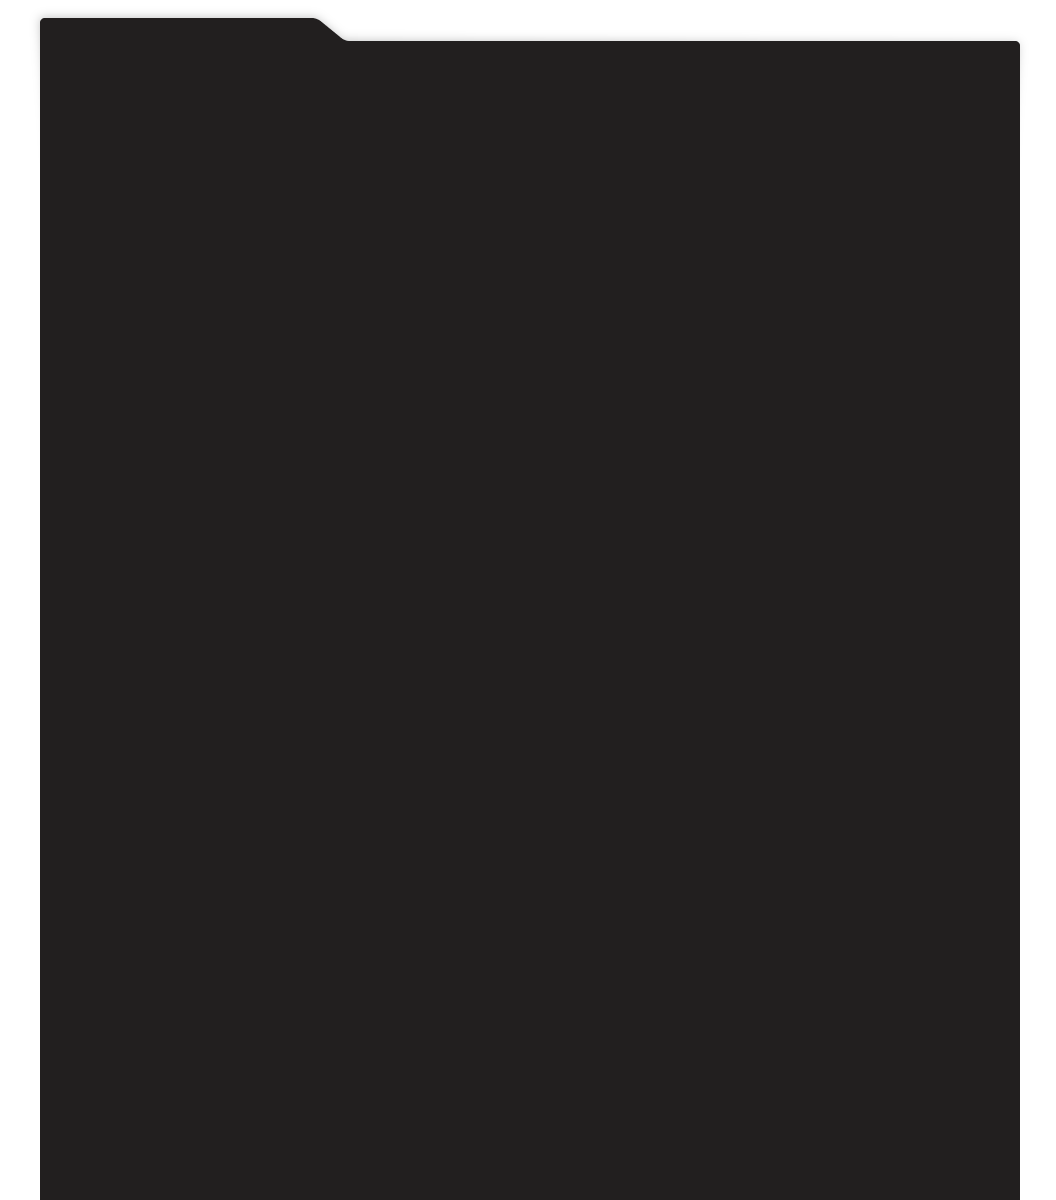
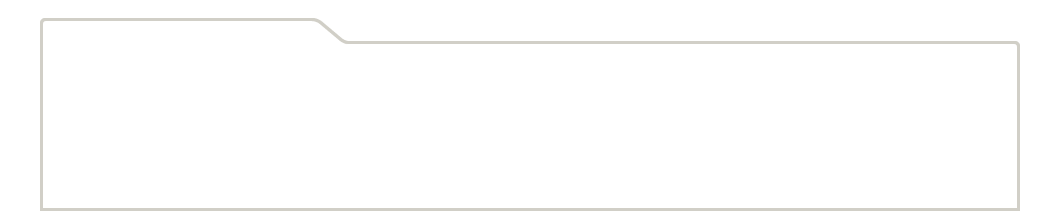
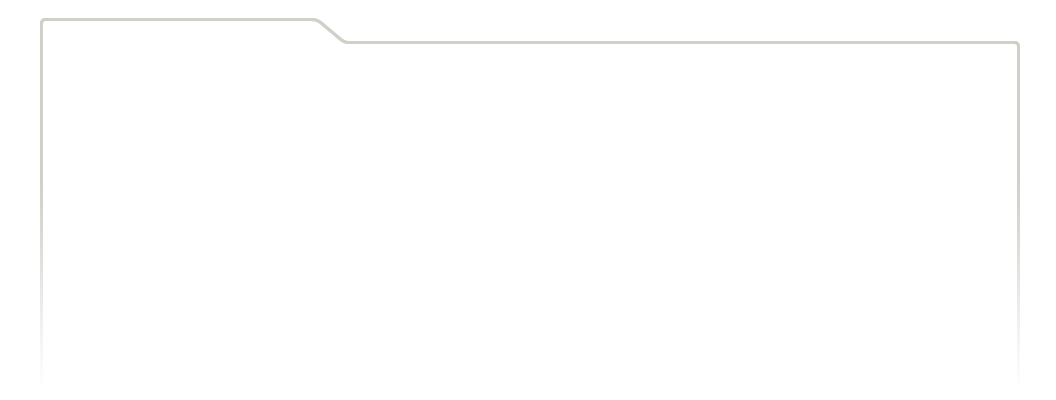
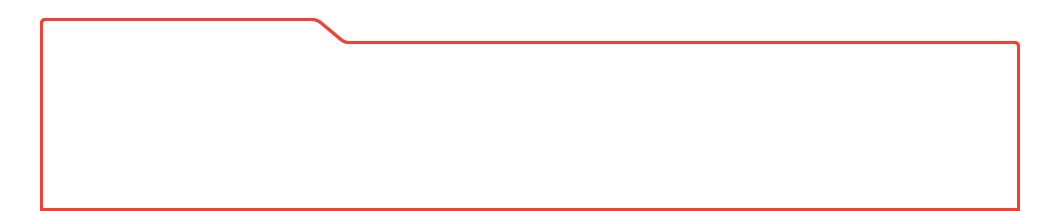
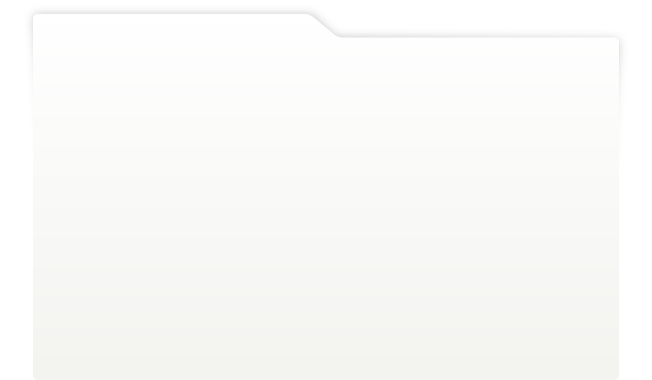
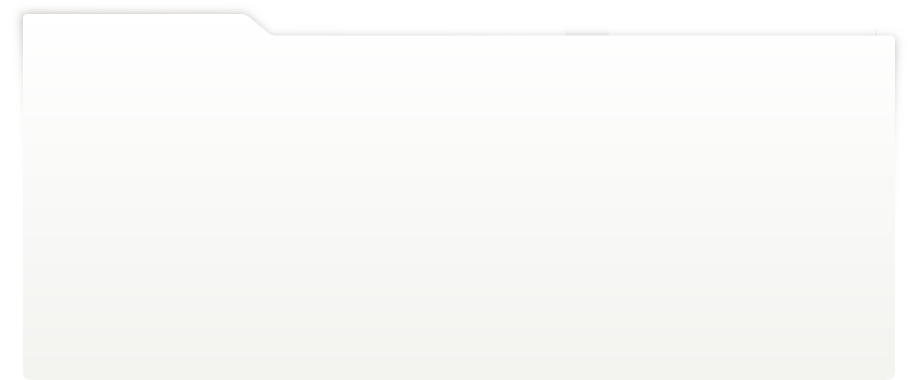
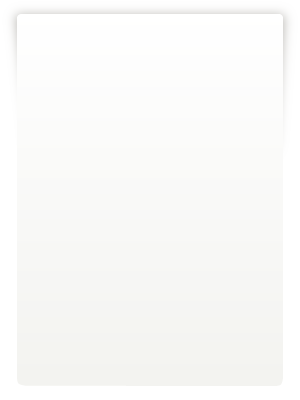
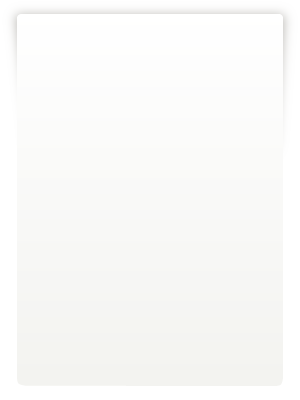
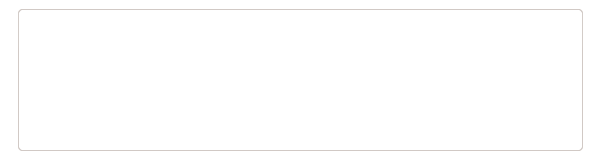
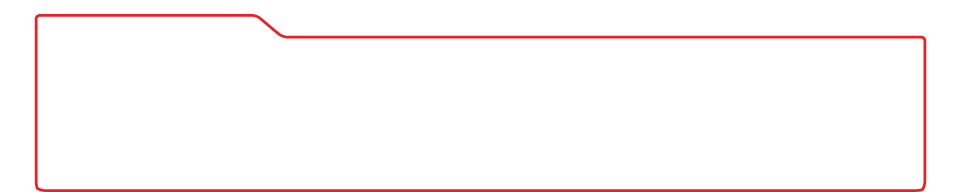
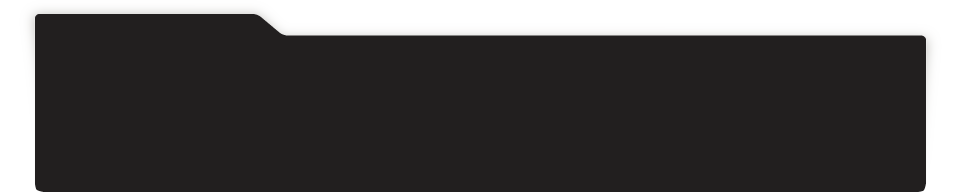
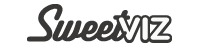
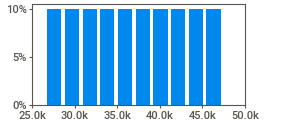
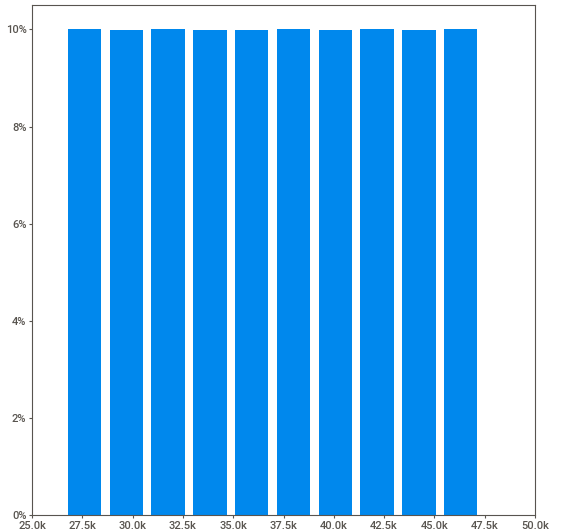
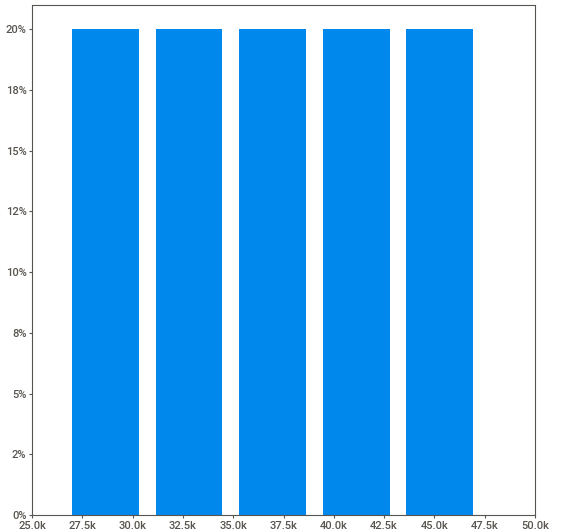
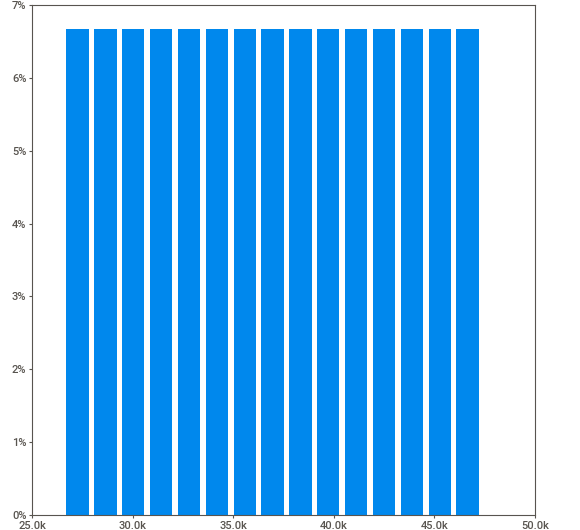
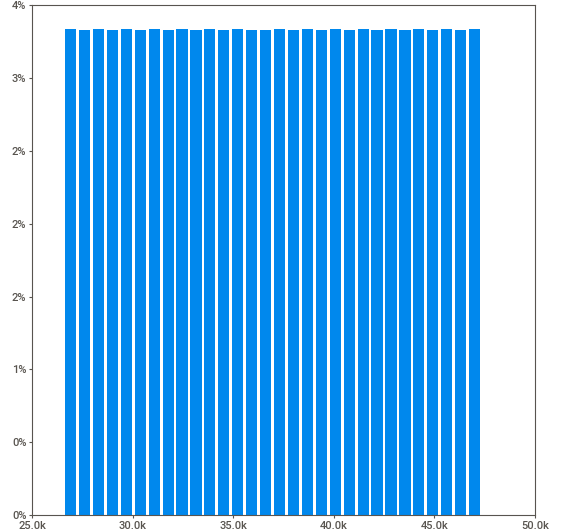
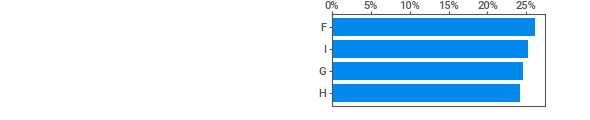
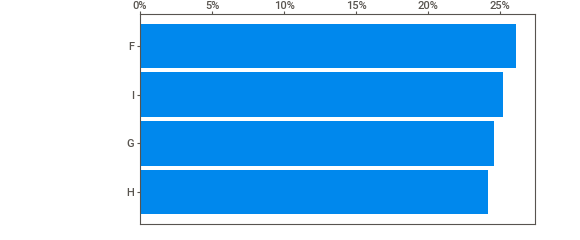
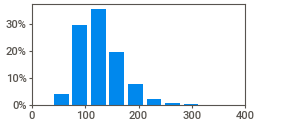
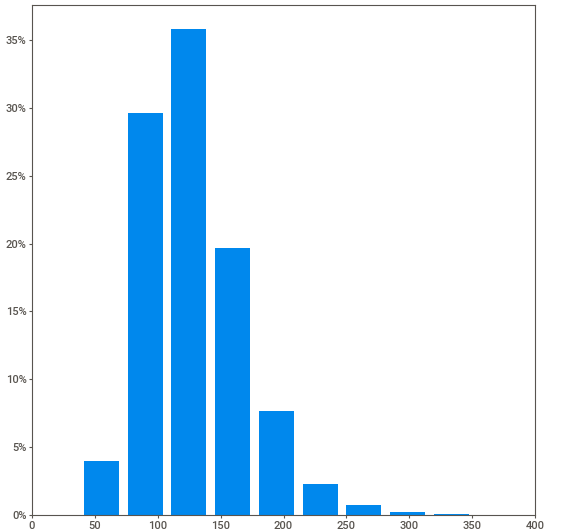
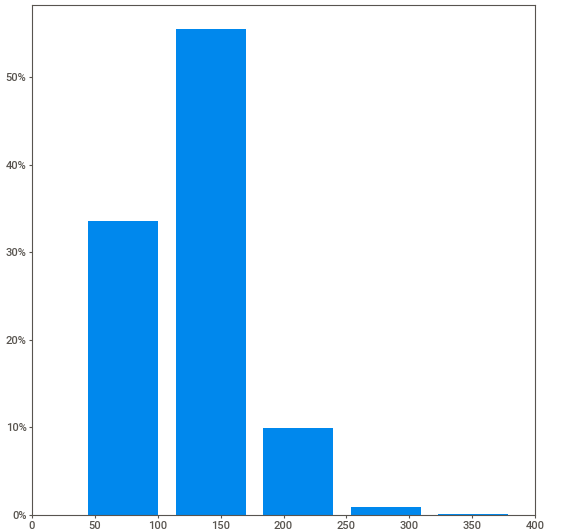
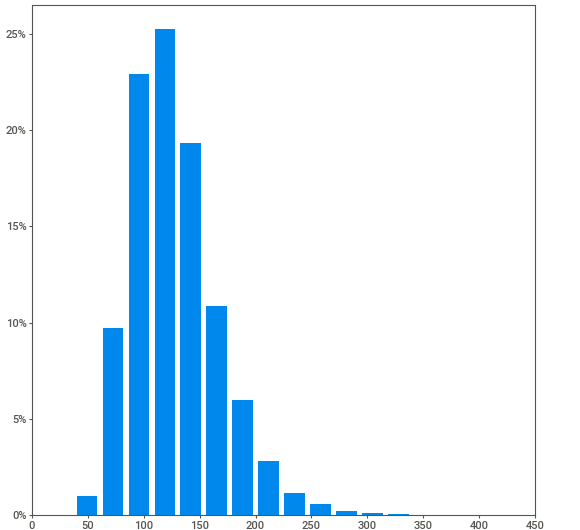
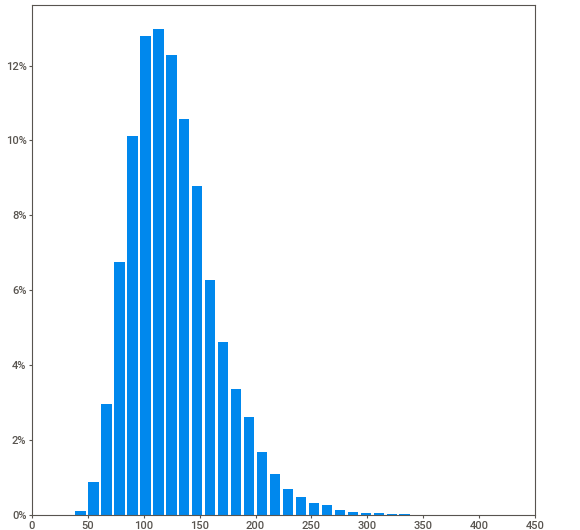
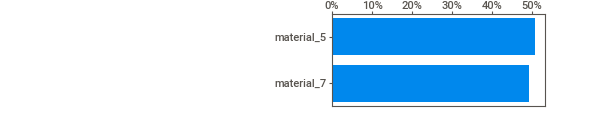
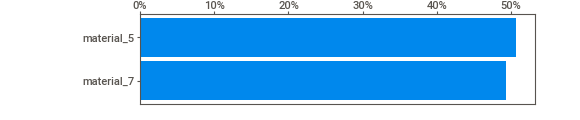
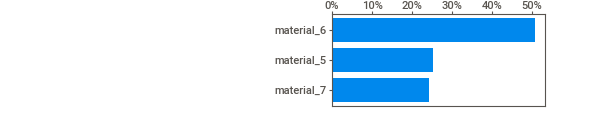
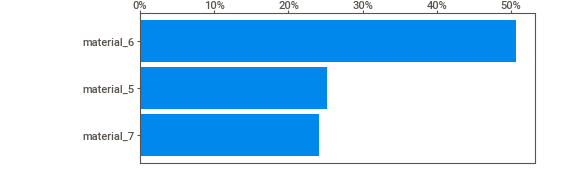
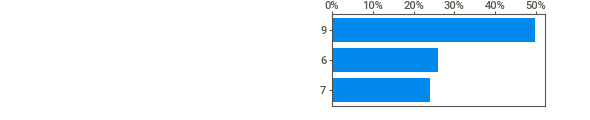
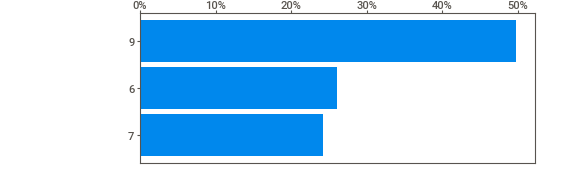
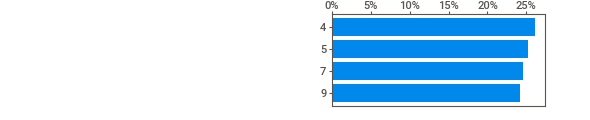
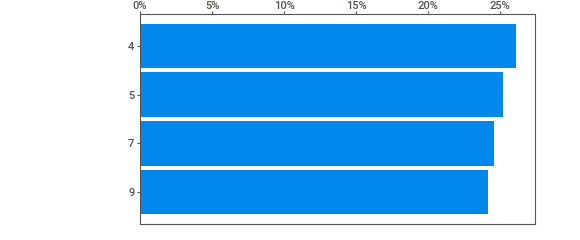
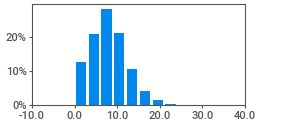
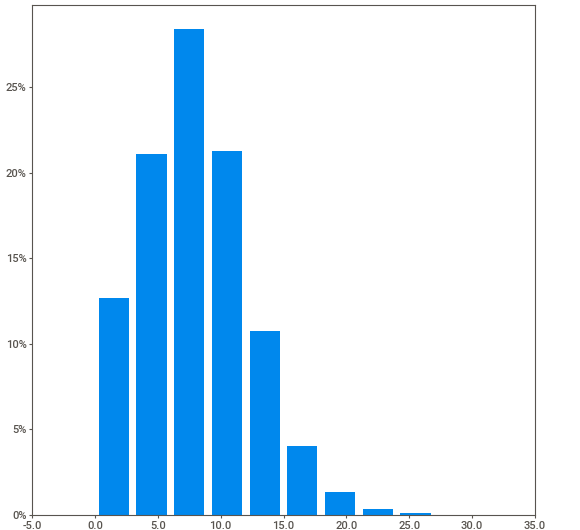
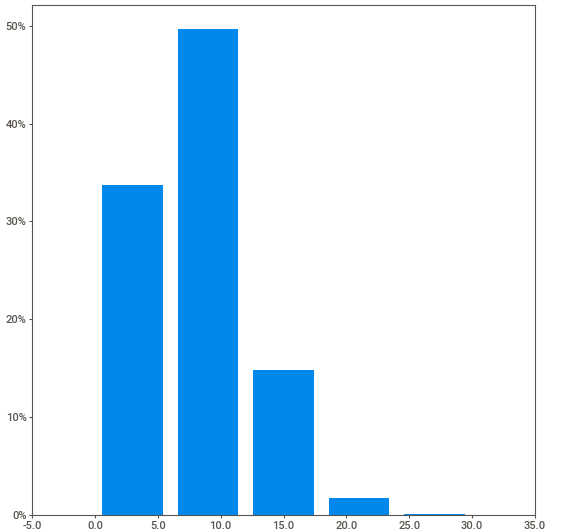
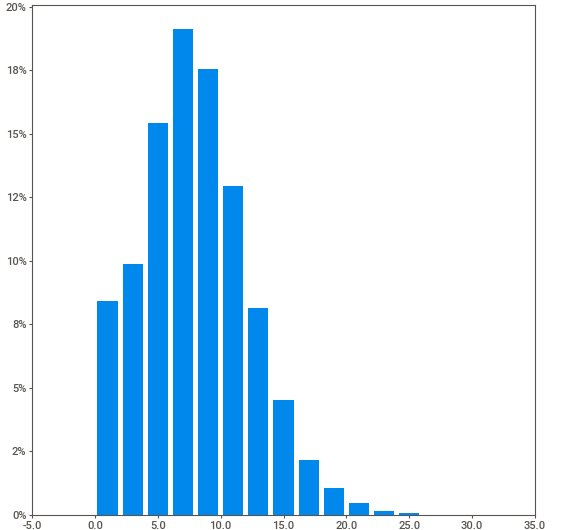
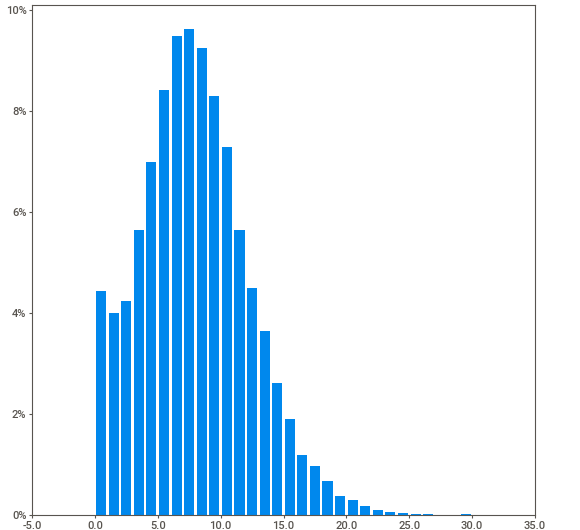
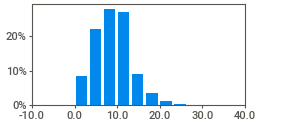
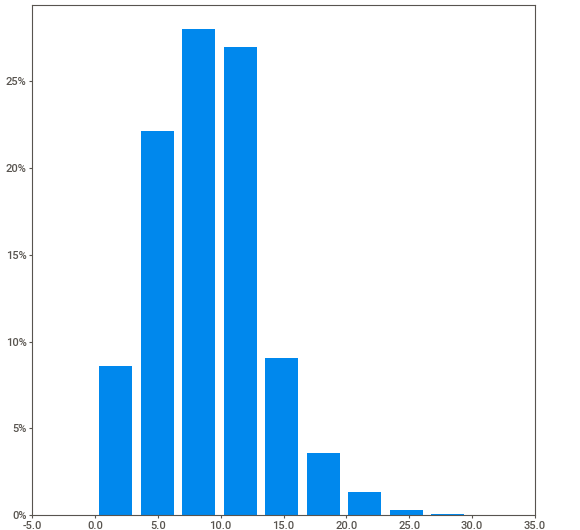
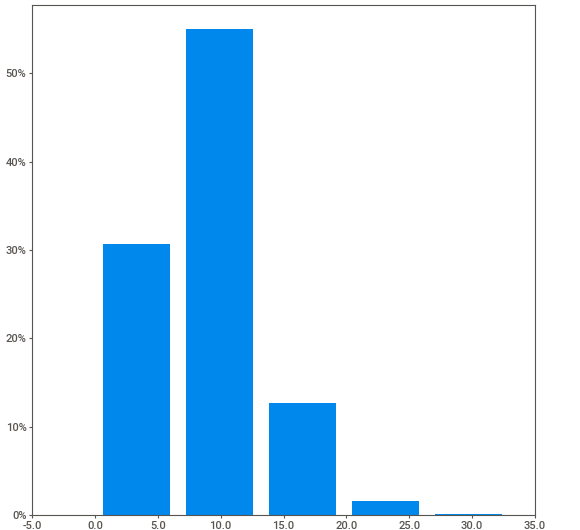
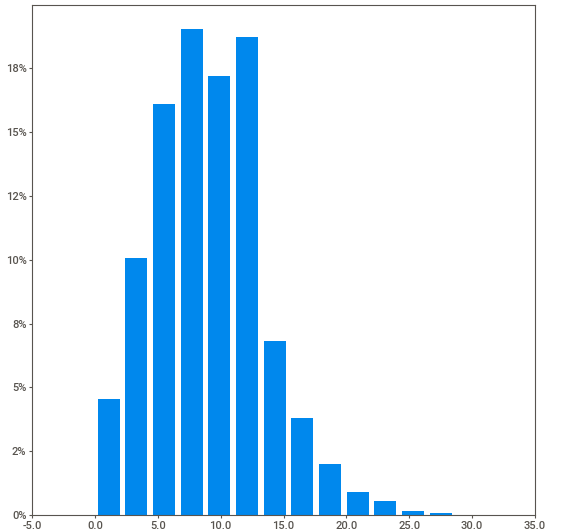
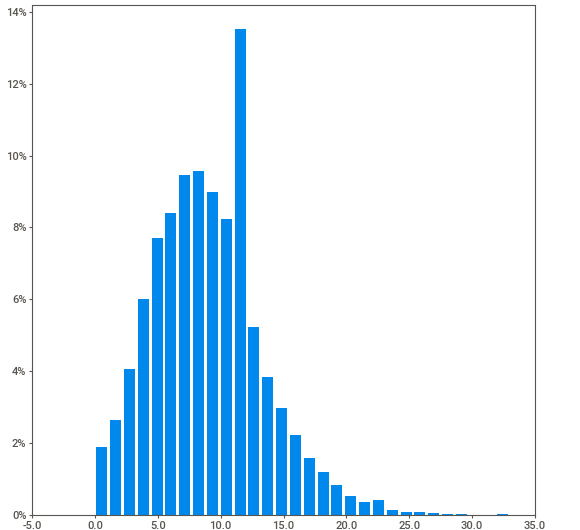
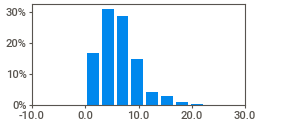
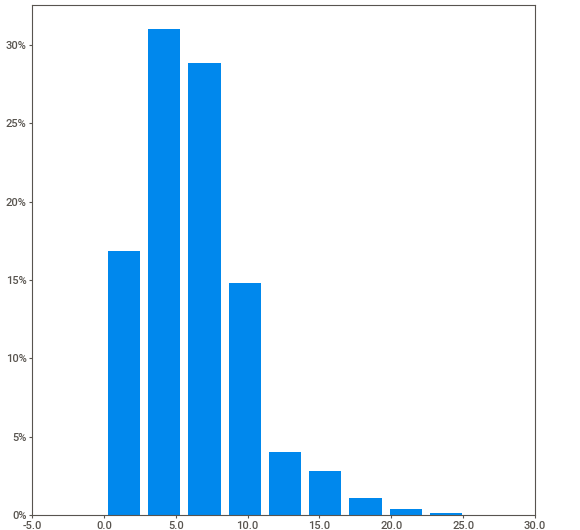
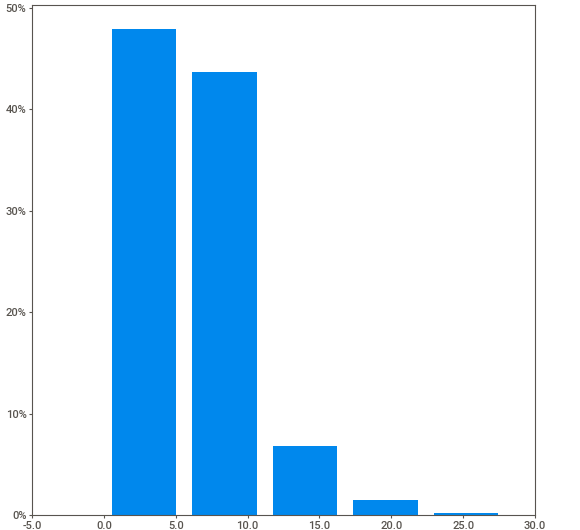
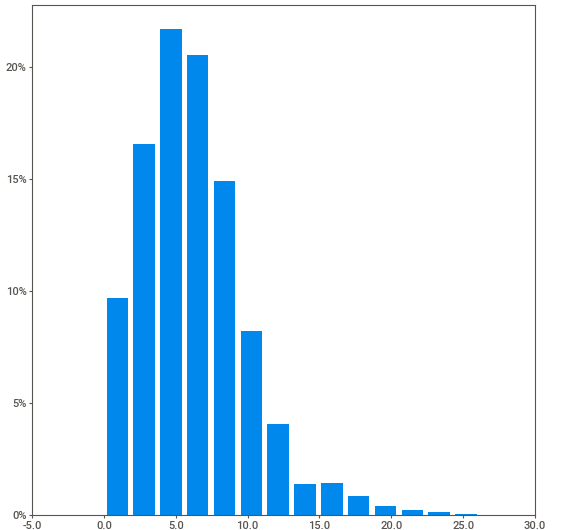
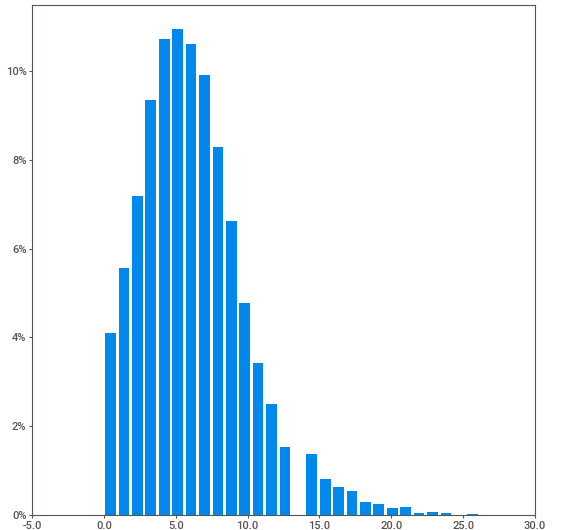
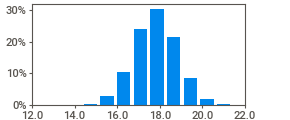
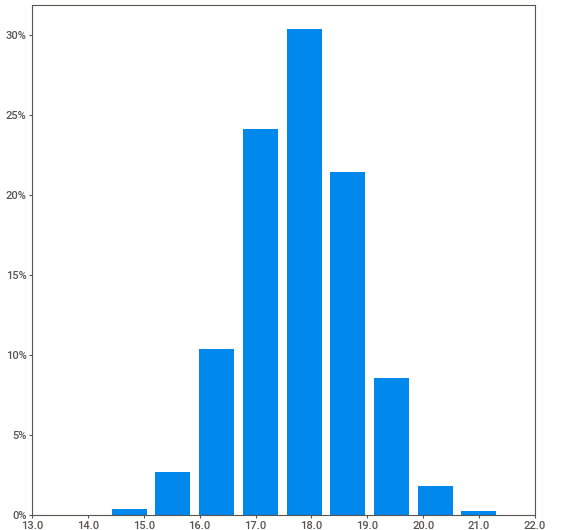
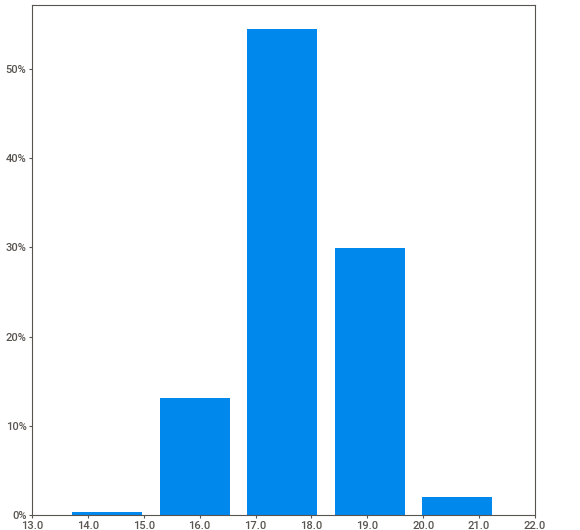
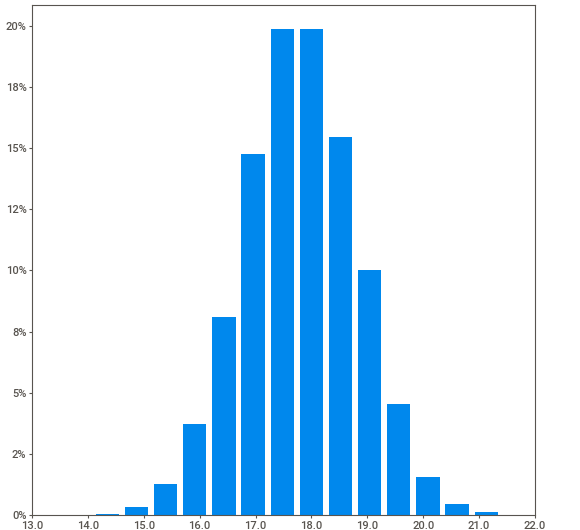
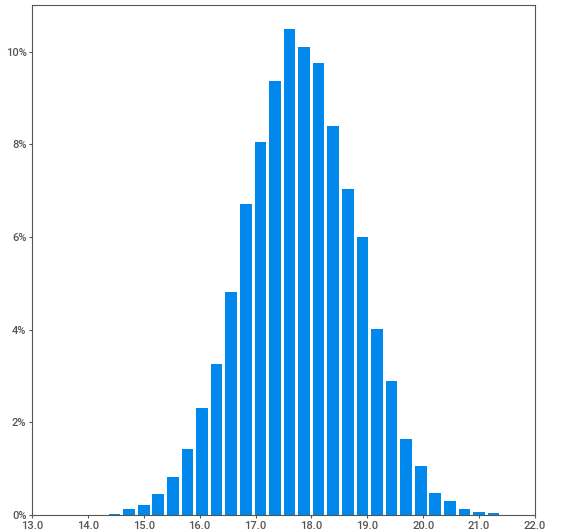
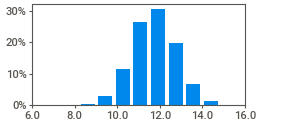
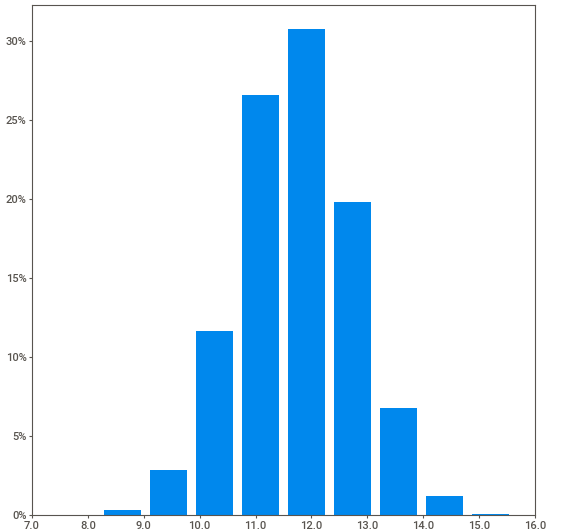
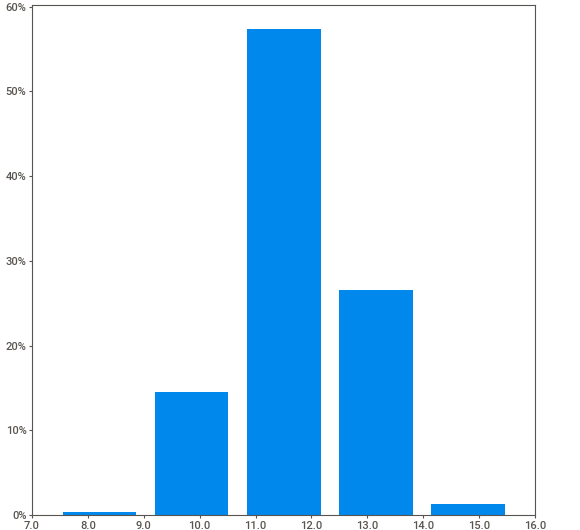
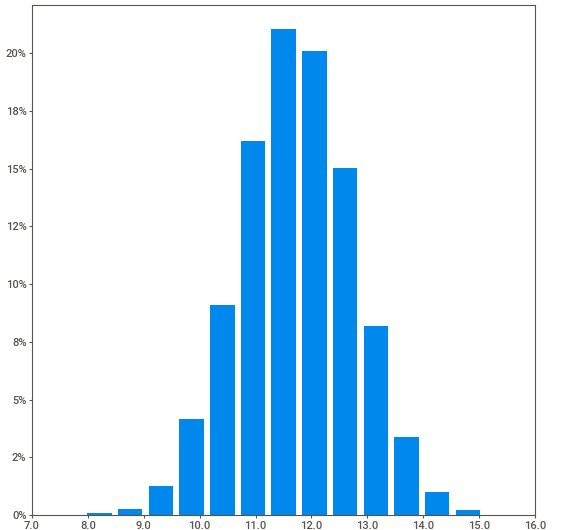
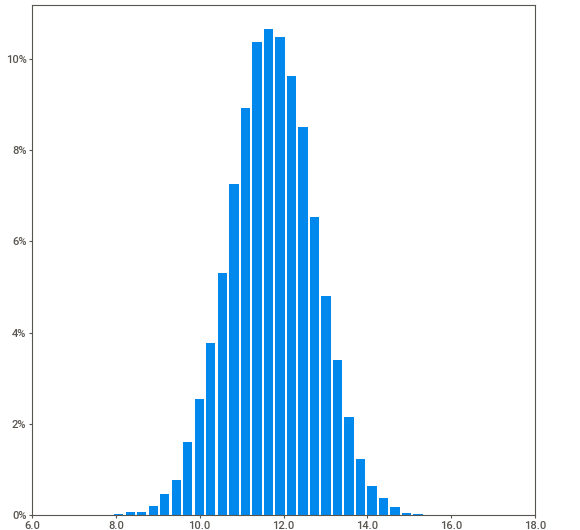
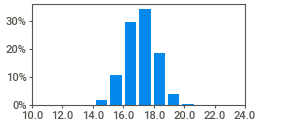
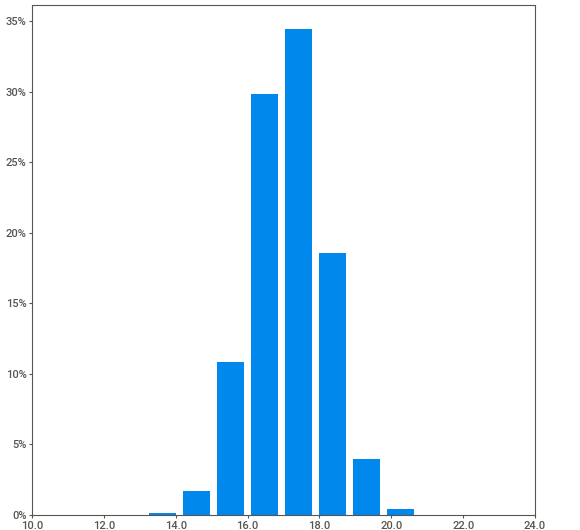
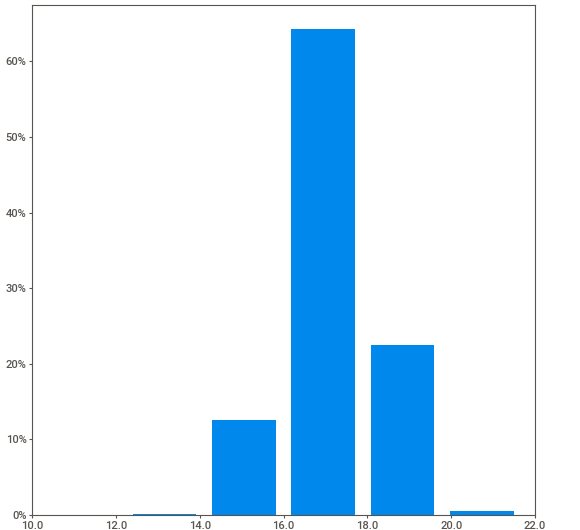
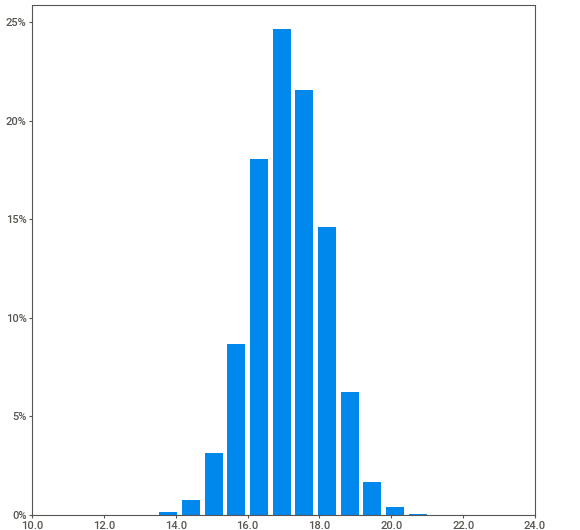
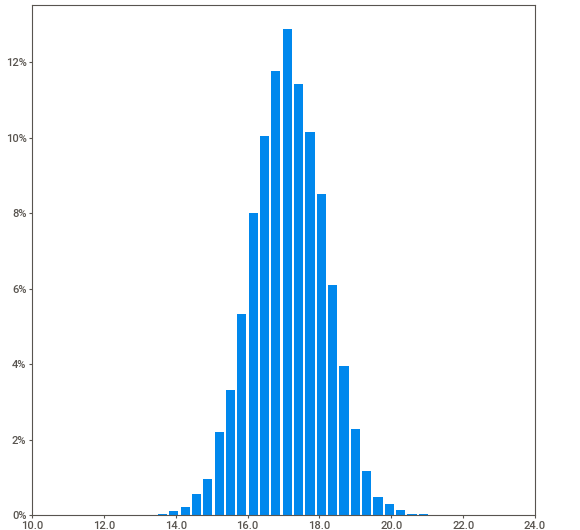
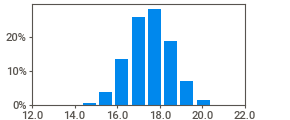
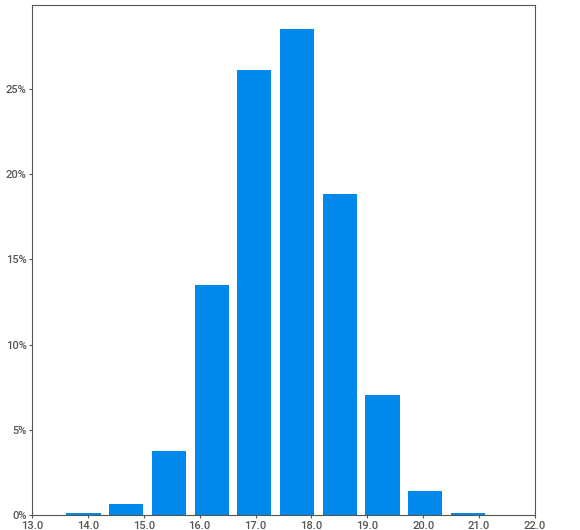
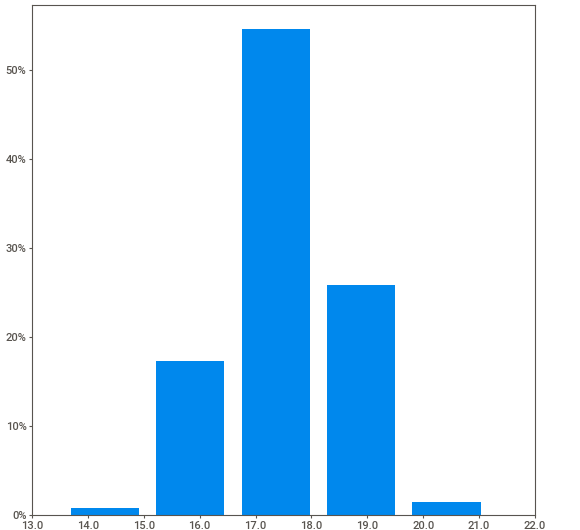
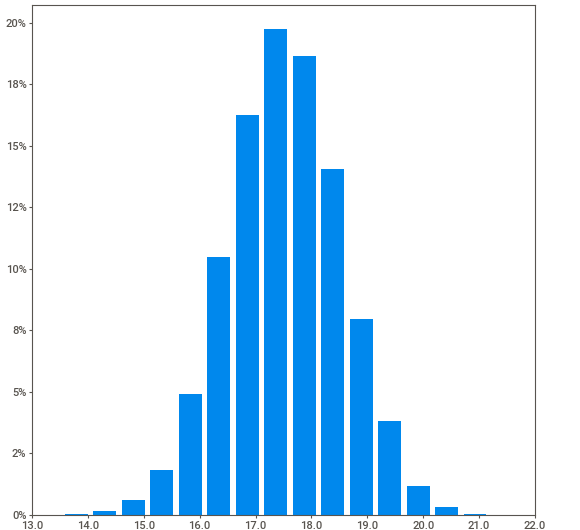
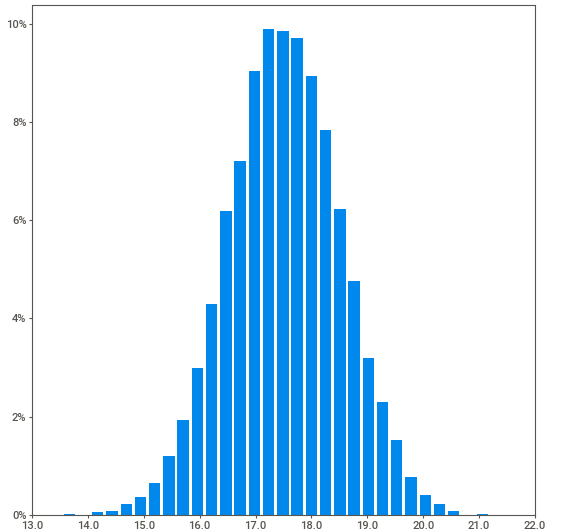
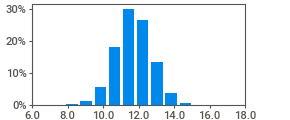
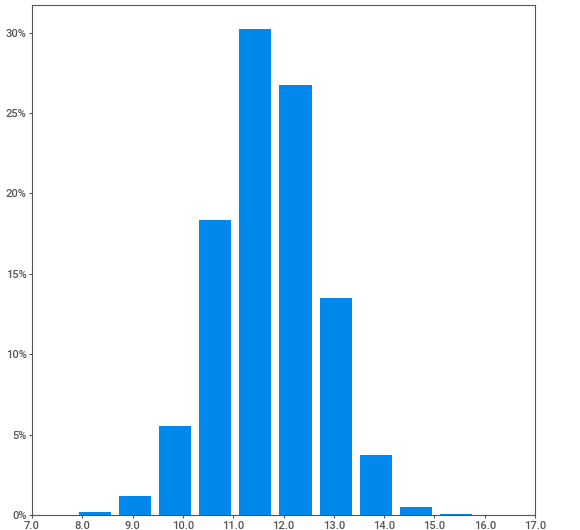
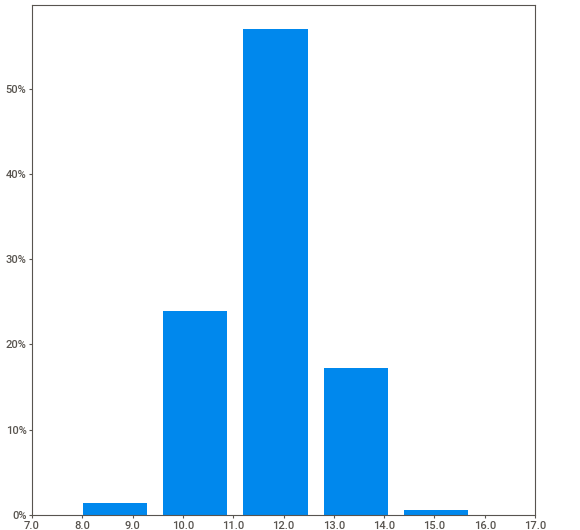
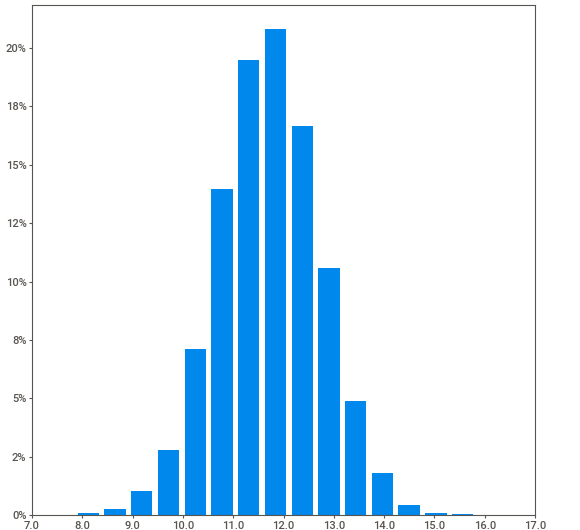
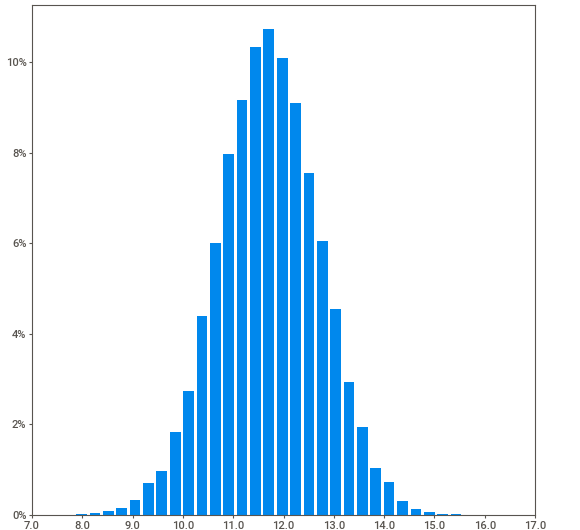
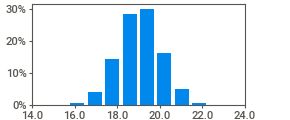
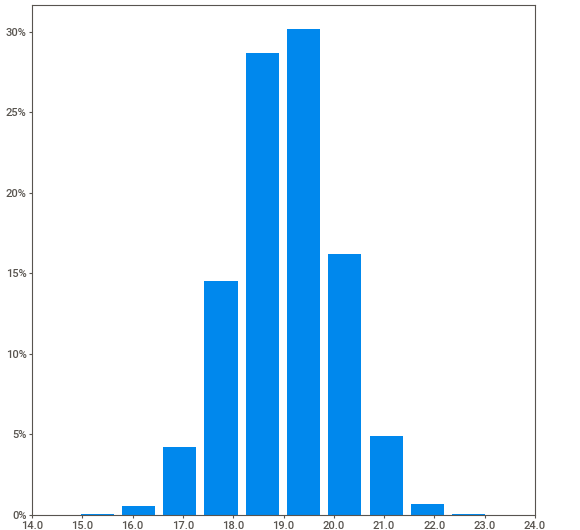
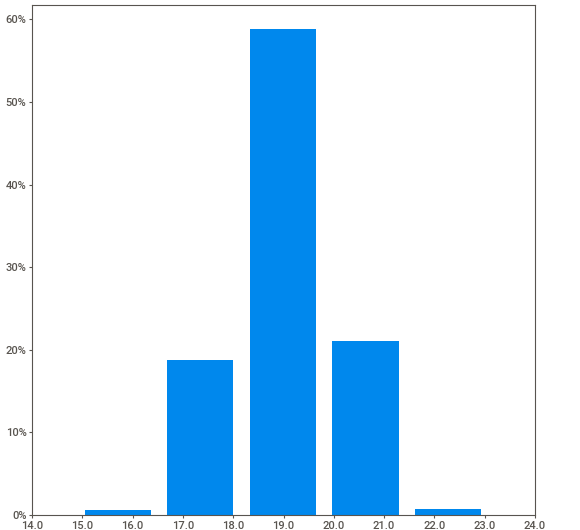
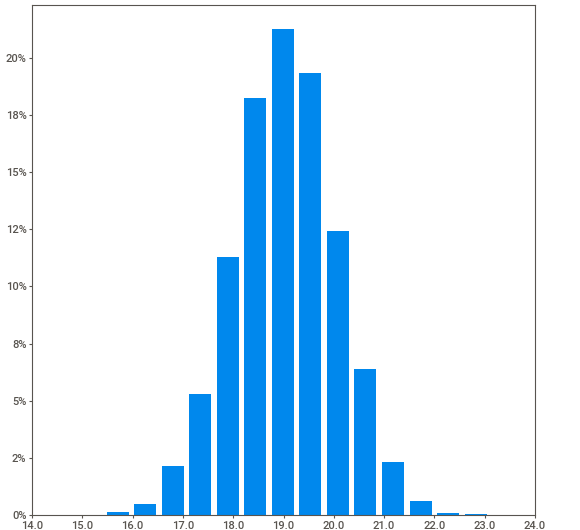
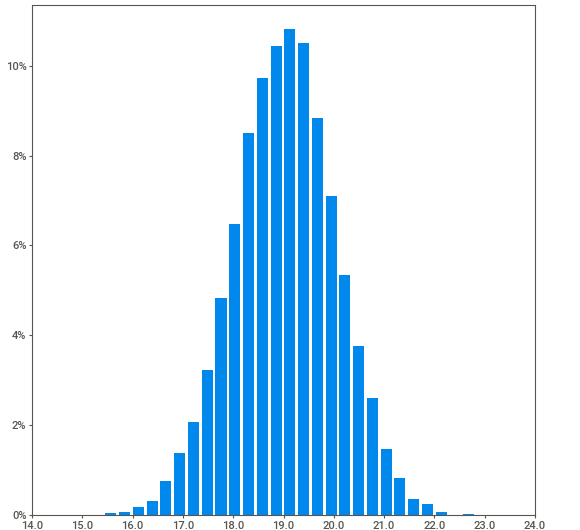
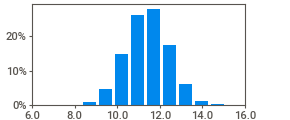
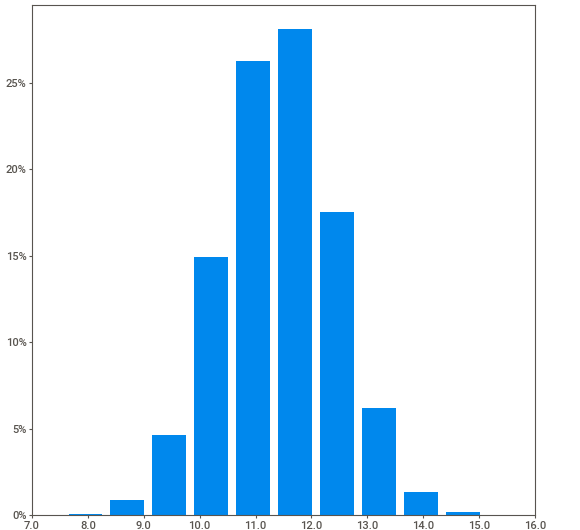
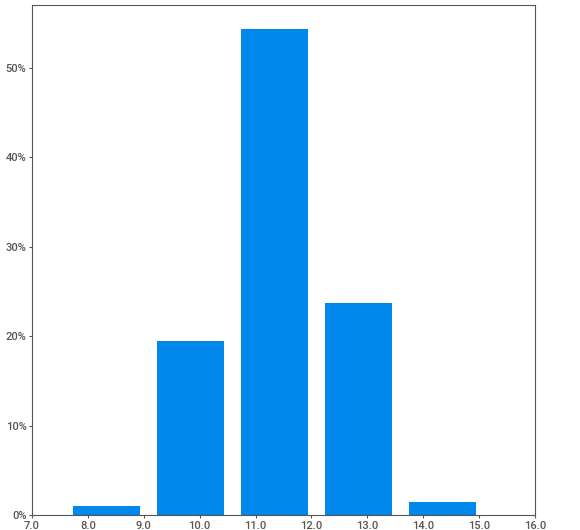
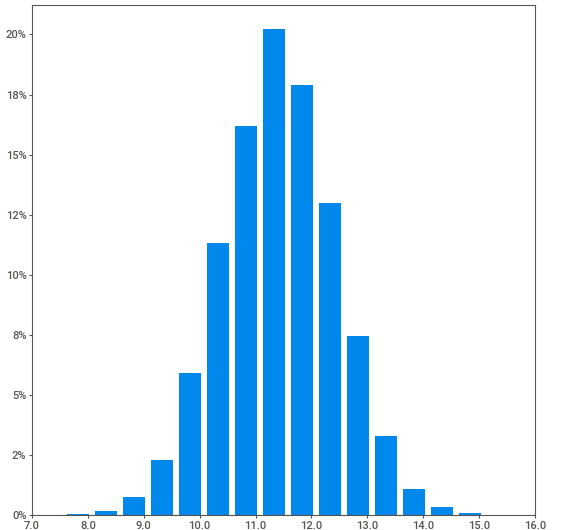
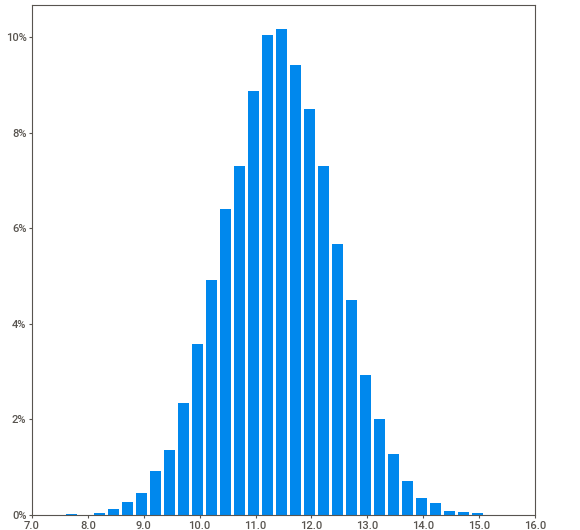
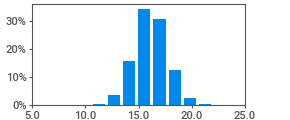
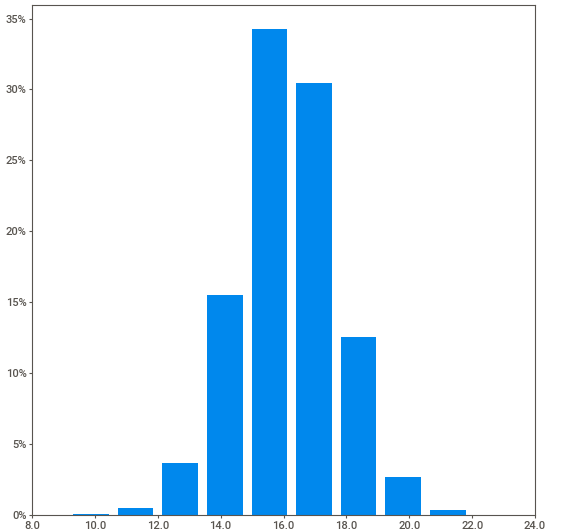
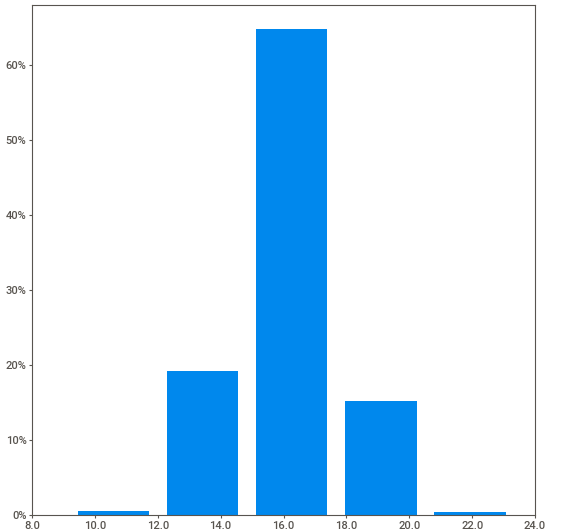
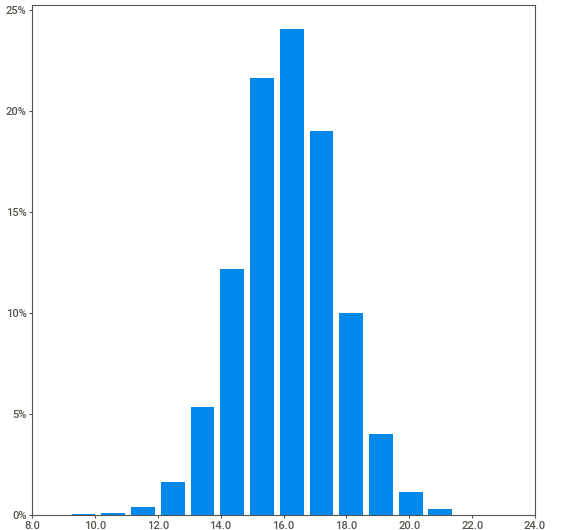
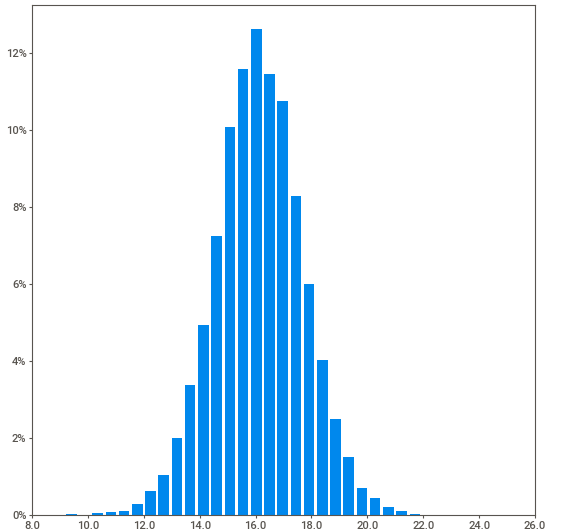
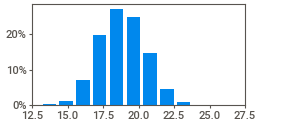
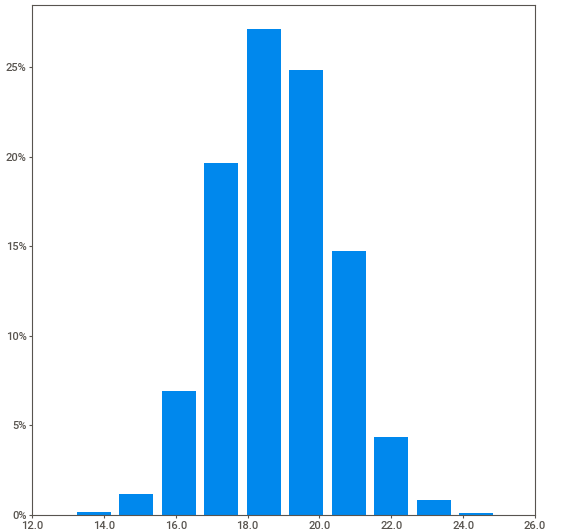
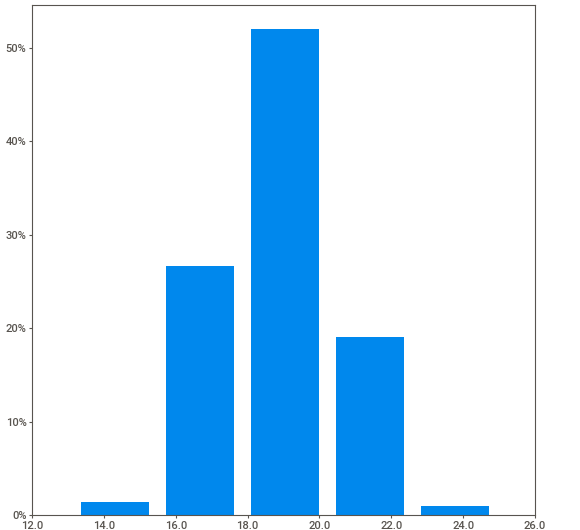
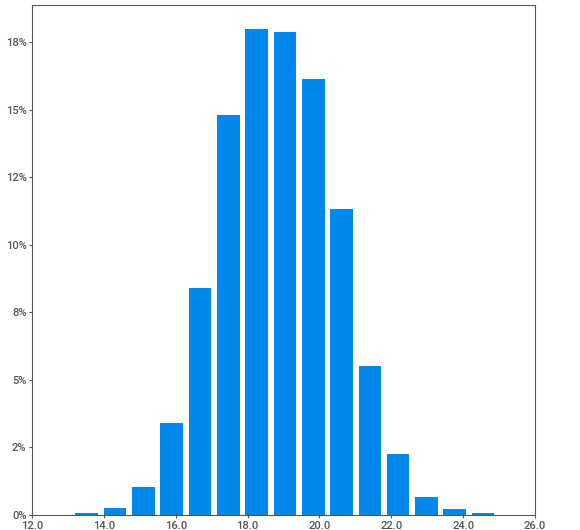
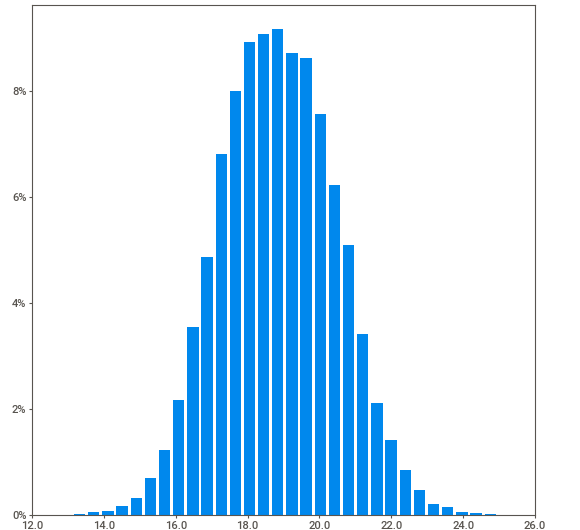
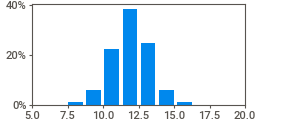
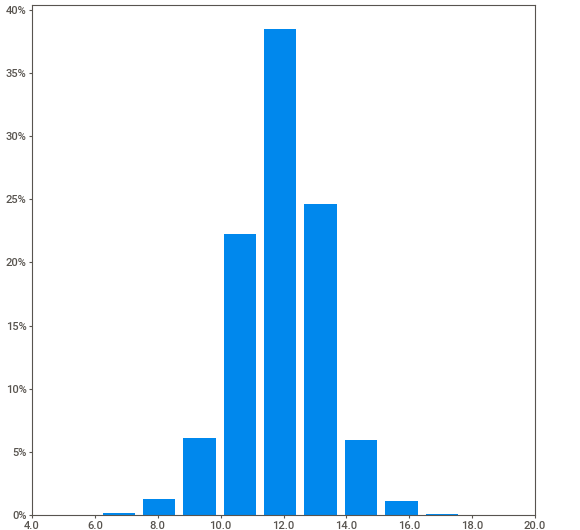
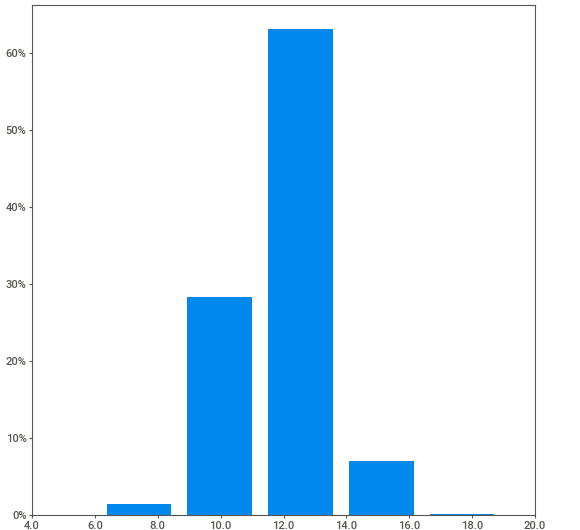
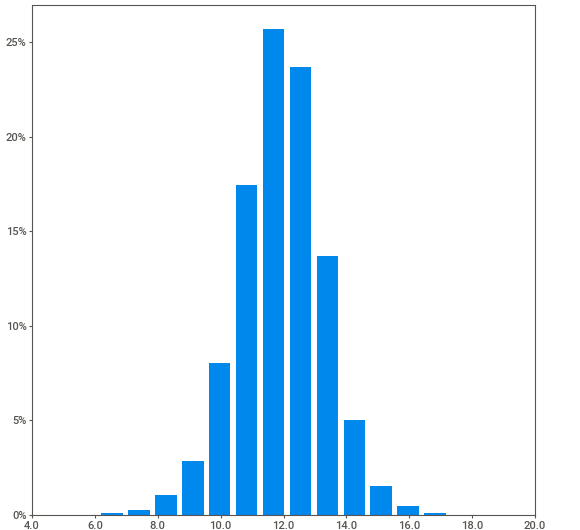
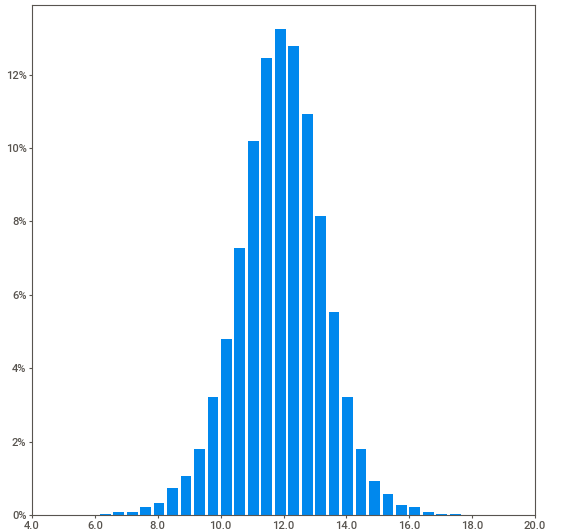
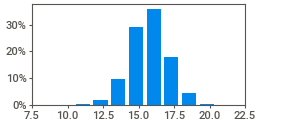
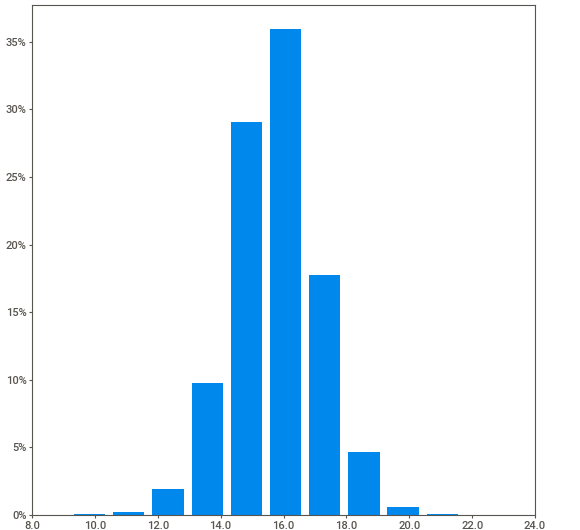
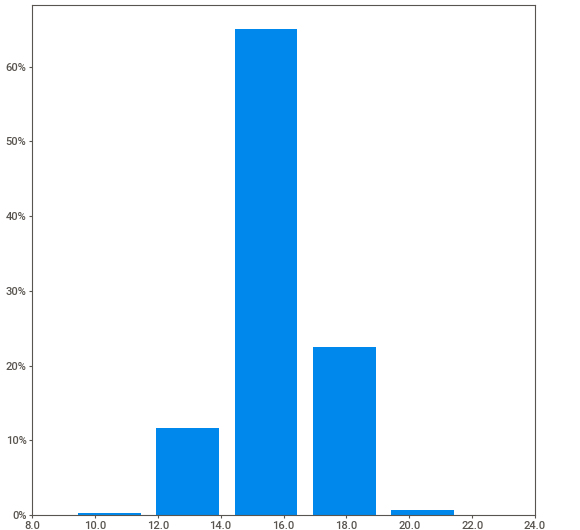
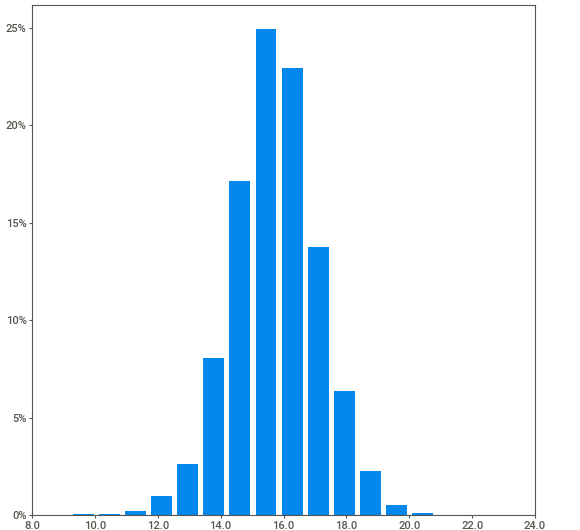
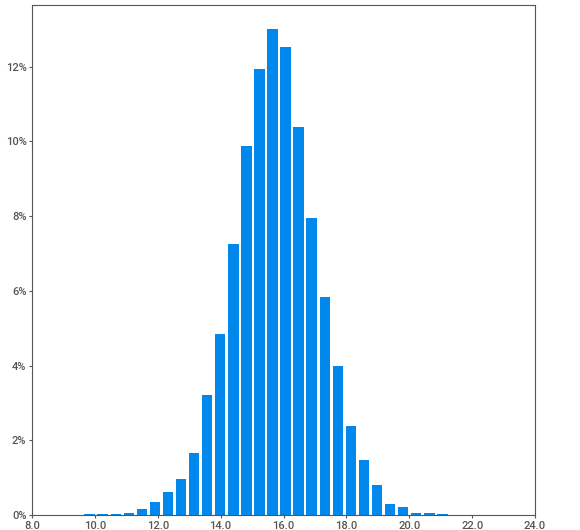
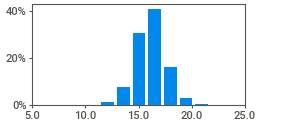
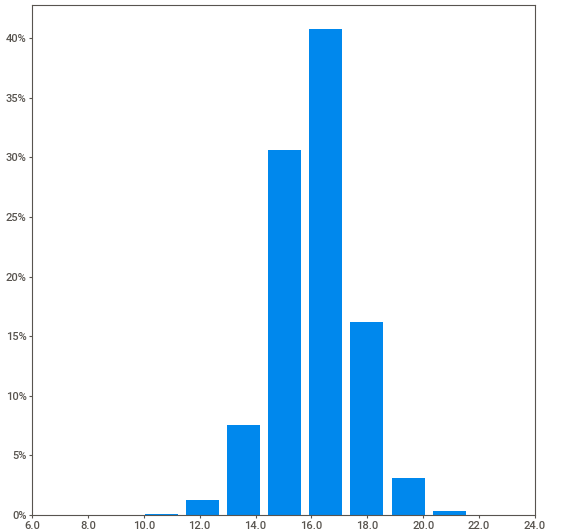
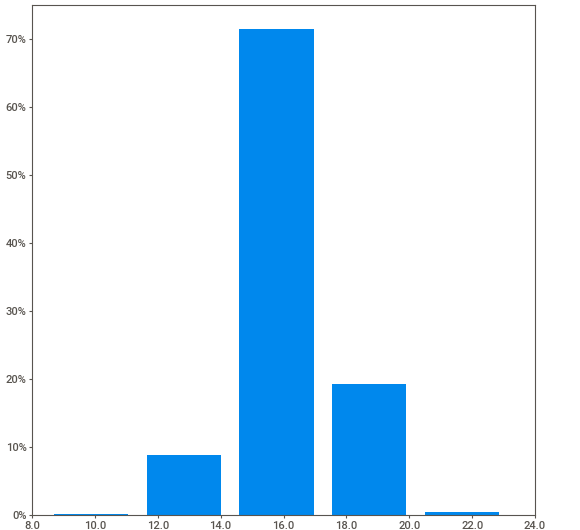
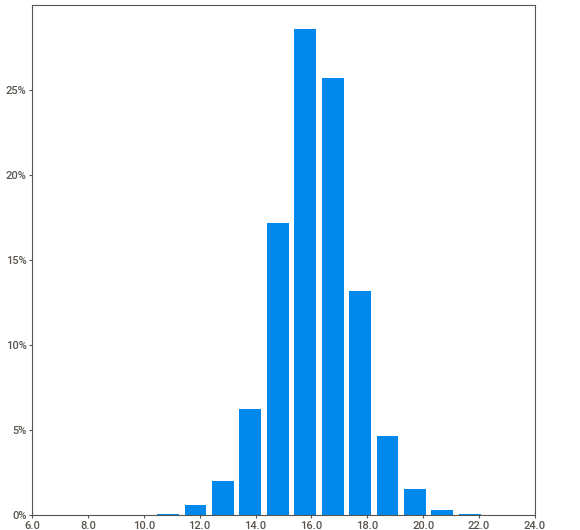
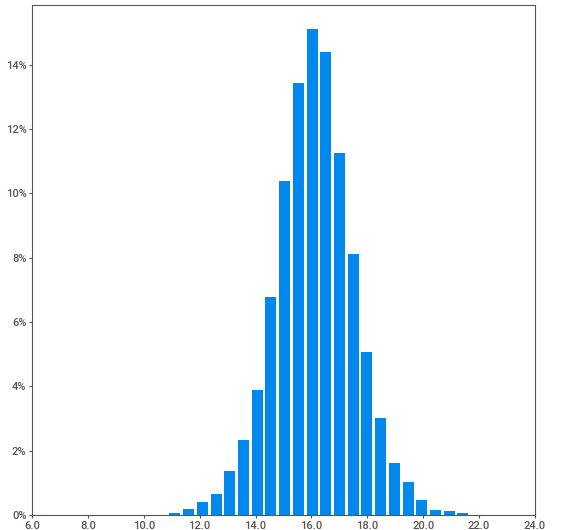
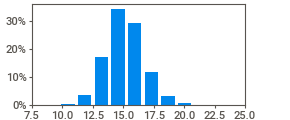
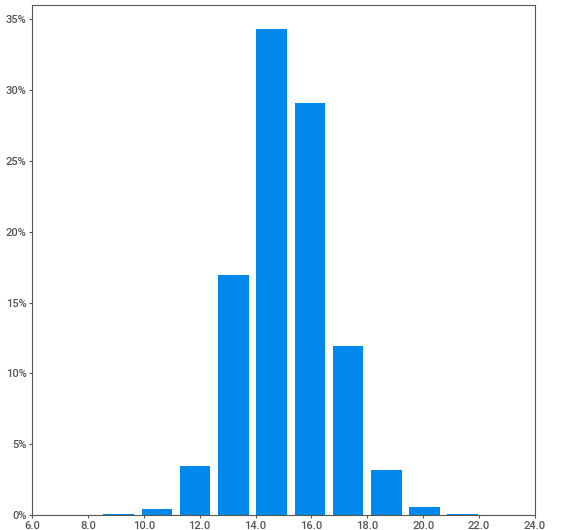
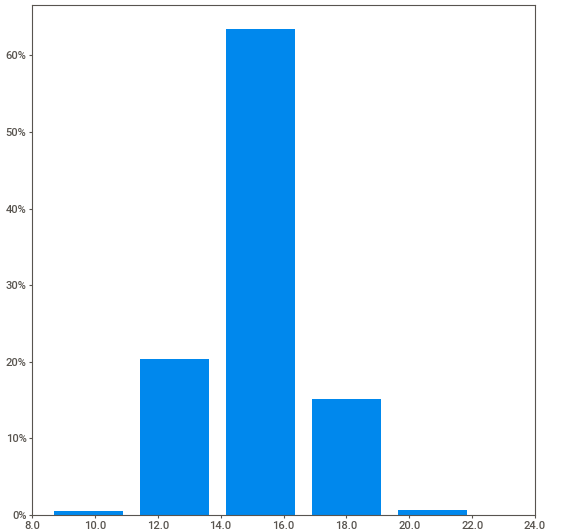
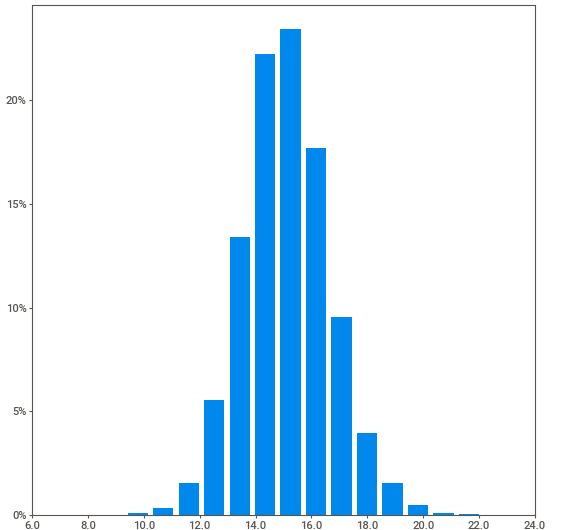
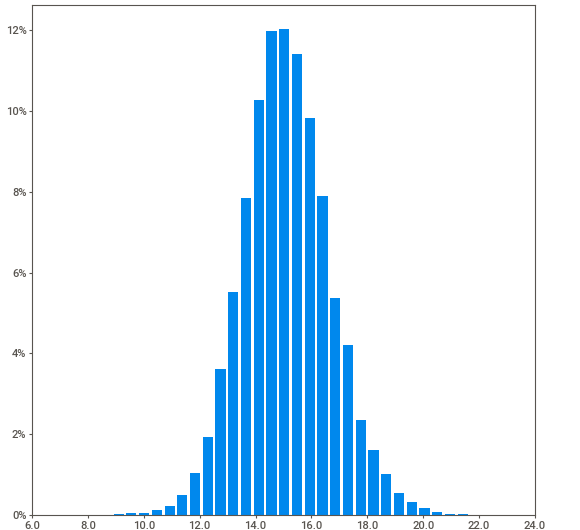
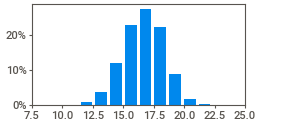
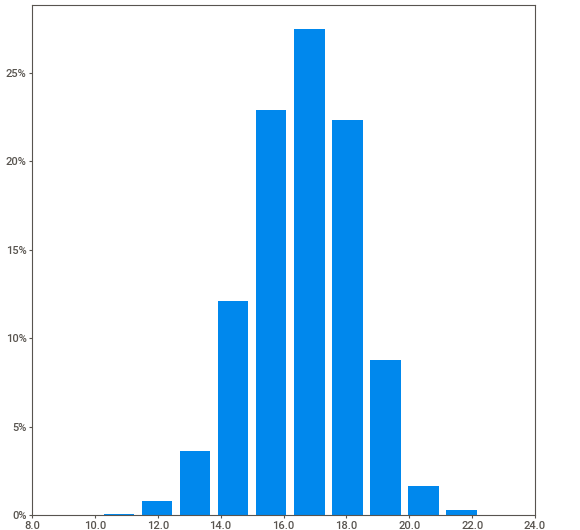
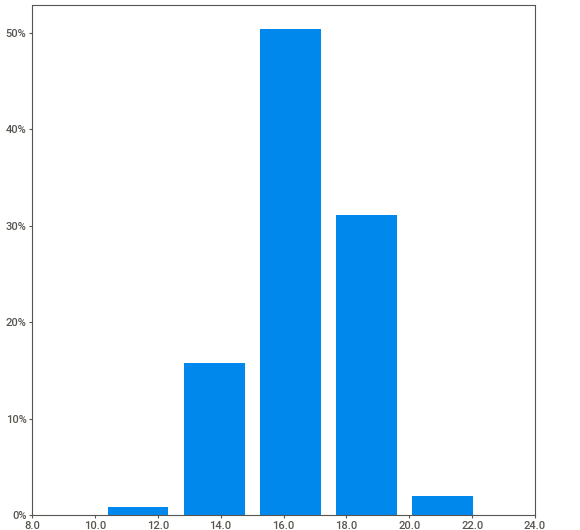
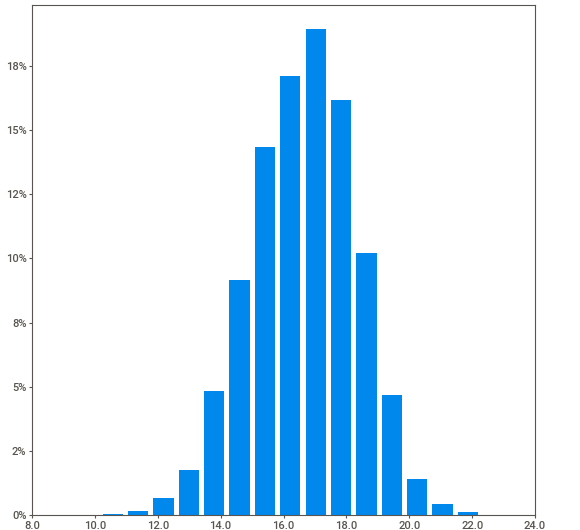
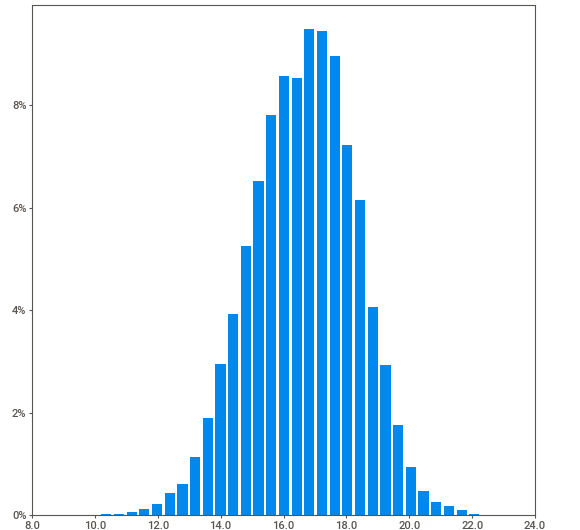
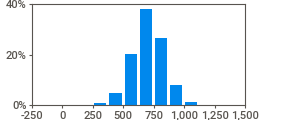
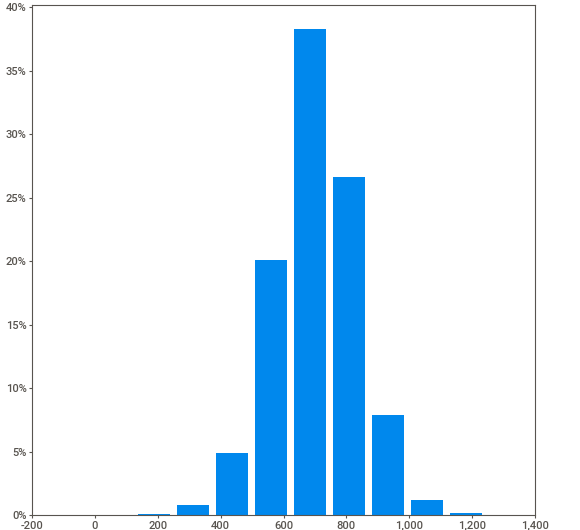
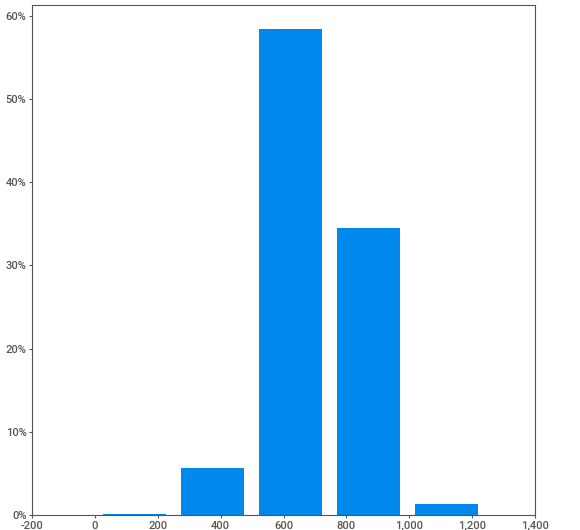
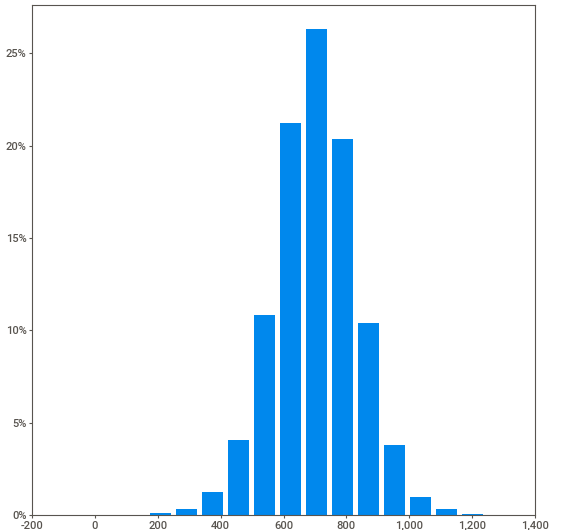
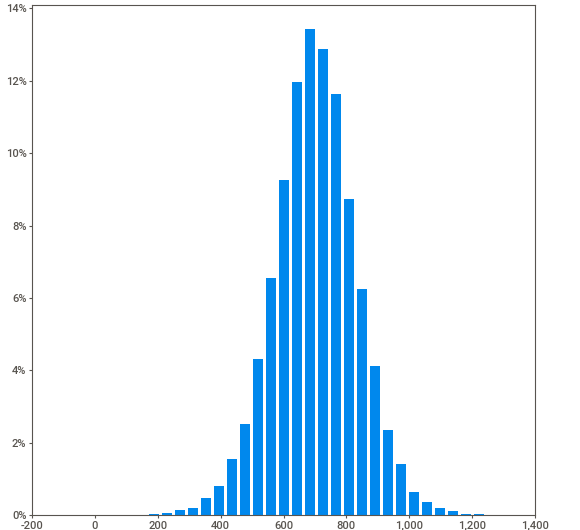
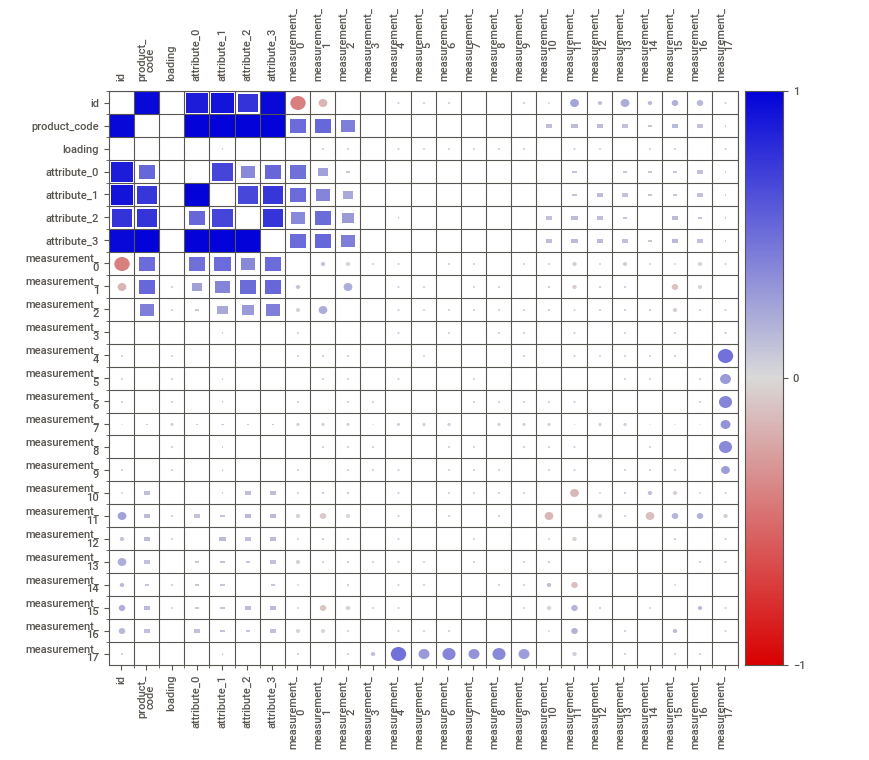
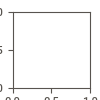

In [9]:
test_report = sv.analyze(test)
test_report.show_notebook()

As mentioned above, only `loading` has a clear correlation with `failure`, and it is not correlated with anything else. The `product_code`, attributes, and measurements seem to have a varying degree of correlations from none to strong to somewhere in between.

The strangest thing though is the strong correlations between measurements 4-9 and 17, especially since measurements 4-9 are not correlated with themselves. This is suspicious, and not something I'd expect to see on a real dataset. It indicates that **measurement 17 is created using a linear combination of measurements 4-9**.

What is more interesting, is the strength of the correlations changes between train and test. For example, the correlation coefficient between measurement 4 and measurement 17 is 0.19 on the train data and 0.45 on the test data. A variation this large seems unlikely due to chance alone. But since the `product_codes` in train vs test are mutually exclusive, looking at correlations broken down by `product_code` might be useful.

### Measurements 4-9 vs 17 broken down by `product_code`

Simple groupby correlation calculations


In [10]:
g = train.groupby("product_code").apply(lambda df: df.corr().loc["measurement_17", [f"measurement_{i}" for i in range(4, 10)]])
g.style.background_gradient(cmap="coolwarm", axis=None).format("{:.2f}")

In [11]:
g = test.groupby("product_code").apply(lambda df: df.corr().loc["measurement_17", [f"measurement_{i}" for i in range(4, 10)]])
g.style.background_gradient(cmap="coolwarm", axis=None).format("{:.2f}")

The correlations vary significantly from one `product_code` to the other, indicating there might be separate linear models for each `product_code`. If we need to predict `measurement_17` for any reason (such as imputation), one solution could be a linear mixed effects model.

### Feature Importance

With data where most predictors look pretty unimportant, it can be helpful to create shuffled copies of every feature to see which (if any) look like they could be helpful.

Here's the process:

1. Subset temporarily to numeric columns
2. Create a shuffled copy of every feature, adding to the dataframe (call them shadow features, like Boruta)
3. Measure feature importance using:
      1. AUC with target
      2. correlation with target
4. Identify features that look significantly better than shadow features

In [12]:
def correlation(y_true, y_pred):
    # helper function
    return pd.concat([y_true, y_pred], axis=1).corr().iloc[0, 1]

In [13]:
num_cols = [col for col in train.select_dtypes(np.number).columns if col not in ["id", "failure"]]
rng = np.random.default_rng(5)
num_train_shadows = train[num_cols + ["failure", "product_code"]].copy()
for col in num_cols:
    arr = num_train_shadows[col].to_numpy()
    num_train_shadows[f"shadow_{col}"] = rng.permutation(arr)

met_funcs = [correlation, roc_auc_score]

row_list = []
groups = rng.choice(5, size=num_train_shadows.shape[0])
for col in num_train_shadows.columns:
    if col in ["id", "failure", "product_code"]:
        continue
    for group in np.unique(groups):
        # mask = num_train_shadows[col].notna() & (groups == group)
        mask = num_train_shadows[col].notna()
        tmp = num_train_shadows[mask].sample(int(0.8 * num_train_shadows.shape[0]), replace=True)
        for met in met_funcs:
            # val = met(num_train_shadows.loc[mask, 'failure'], num_train_shadows.loc[mask, col])
            val = met(tmp.failure, tmp[col])
            row = {
                "metric": met.__name__,
                "score": val,
                "product_code": group,
                "col": col, 
            }
            row_list.append(row)
res = pd.DataFrame(row_list)
res

metric     score  product_code                    col
0      correlation  0.134081             0                loading
1    roc_auc_score  0.592099             0                loading
2      correlation  0.133747             1                loading
3    roc_auc_score  0.591394             1                loading
4      correlation  0.116328             2                loading
..             ...       ...           ...                    ...
415  roc_auc_score  0.495638             2  shadow_measurement_17
416    correlation -0.007785             3  shadow_measurement_17
417  roc_auc_score  0.494040             3  shadow_measurement_17
418    correlation -0.015471             4  shadow_measurement_17
419  roc_auc_score  0.489511             4  shadow_measurement_17

[420 rows x 4 columns]

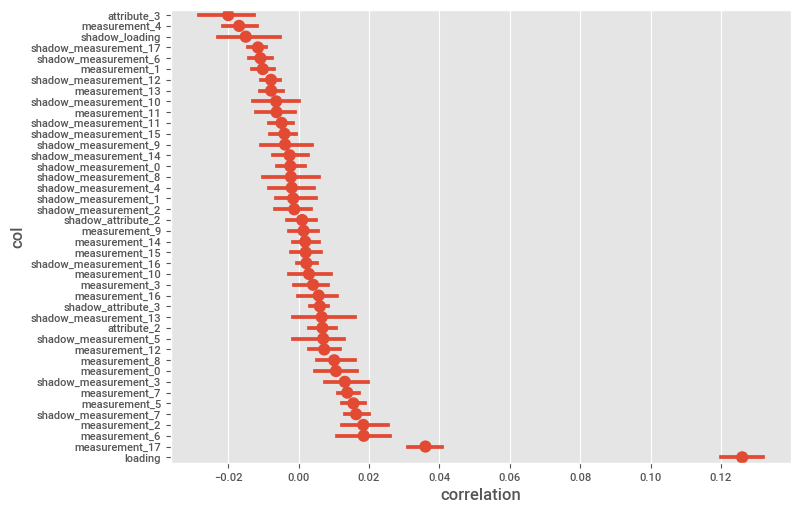

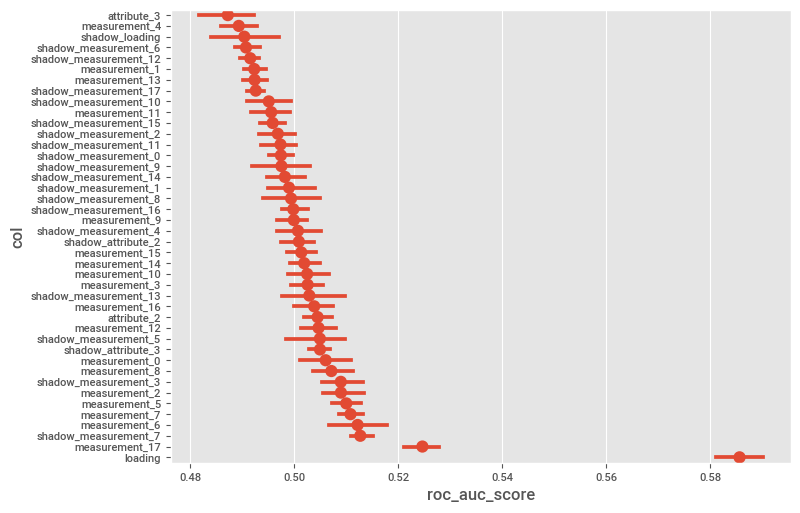

In [14]:
# Set plotting style for rest of notebook
plt.style.use("ggplot")


metric = "roc_auc_score"
for metric in met_funcs:
    met_name = metric.__name__
    fig, ax = plt.subplots(figsize=(8, 6))
    tmp = res[res.metric == met_name].copy()
    order = tmp.groupby("col")["score"].mean().sort_values()
    sns.pointplot(data=tmp, x="score", y="col", ax=ax, order=order.index, join=False)
    ax.set_xlabel(met_name)
    plt.show()

Takeaways from this investigation:

* `measurement_17` also looks better than random
* `attribute_3` looks slightly better than random
* measurements 2, 5, 7, 8 are borderline

We want at least `loading`, `measurement_17`, and probably `attribute_3` in our model.

### Missingness

The missingness patterns are strange/artificial...there's an linearly-increasing percentage of missing values as the measurement numbers get higher.

`meaurement_17` has the highest percent missing, which is a problem given it's the second most valuable feature. This is where having features that predict `measurement_17` well will be helpful.

<AxesSubplot:>

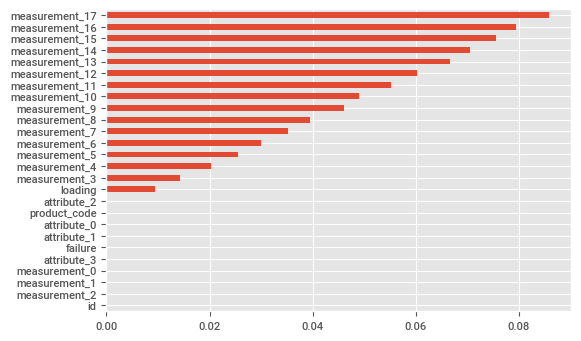

In [15]:
missing = train.isna()
missing.mean().sort_values().plot.barh()

## Modeling

Previous analysis has shown that linear models tend to do better on this problem than tree-based, probably because the dataset is linearly created. Our primary goal for modeling is to build a linear model with some clever imputation:

* Iteratively impute missing values using `product_code` along with the other numeric features (this is mainly for `measurement_17`s sake, but can test applying to all features)
* Use a logistic regression on the imputed values
* Also use `product_code` for explicit CV


This is kind of like doing `cross_val_score` with `IterativeImputer`, but I'm going to code it myself for two reasons:

1. `IterativeImputer` doesn't allow categorical features, so we'd have to leave out `product_code`. We've already demonstrated `product_code` provides valuable information on `measurement_17`, so that's a problem.
2. `cross_val_score` only uses the training data. For iterative imputation, we can actually use the testing predictors to help with the imputation. And we'll need to to submit, since the test data contains new `product_code`s.

### Creating Custom Classifier Class

We can start by creating a scikit-learn classifier object to use for train and testing.

Key Features of `IterativeGroupClassifier`:

1. It uses `X_test` during training, for imputation.
2. It allows for two ways of using `product_code`:
      1. Can be used directly in a model (will be tested using `lightgbm`)
      2. Or it can be used as a grouping variable, and separate models will be fit on each grouping.
3. It allows a "backup" model when the most important feature in the primary model is missing. This is potentially helpful on this problem since `loading` is so valuable but also occassionally missing 


In [60]:
class IterativeGroupClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, iterative_regressor, classifier, backup_est=None):
        self.iterative_regressor = iterative_regressor
        self.classifier = classifier
        self.backup_est = backup_est

    def _iterative_impute(
        self,
        X: pd.DataFrame,
        group_col: str = None,
        fit: bool = True,
        max_iter: int = 5,
        impute_cols: list[str] = None,
    ):
        """_summary_

        Parameters
        ----------
        X : pd.DataFrame
            _description_
        group_col : str, optional
            If specified, separate imputing models fit to each group, by default None
        fit : bool, optional
            _description_, by default True
        max_iter : int, optional
            _description_, by default 5
        impute_cols : list[str], optional
            If specified, will only impute these columns, by default None

        Returns
        -------
        _type_
            _description_
        """
        # Specify impute cols
        self.impute_cols = impute_cols
        if self.impute_cols is None:
            self.impute_cols = list(X.columns)

        # Perform initial imputations using mean
        complete = X.copy()
        masks = np.zeros(X.shape, dtype=bool)
        for i in range(X.shape[1]):
            masks[:, i] = X.iloc[:, i].notna()
            if ((~masks[:, i]).sum() == 0) | (
                X.columns[i] not in self.impute_cols
            ):
                continue
            complete.iloc[~masks[:, i], i] = X.iloc[masks[:, i], i].mean()

        # Iteratively train models
        if fit:
            # Very cool: <https://stackoverflow.com/a/27809959>
            self.models = defaultdict(lambda: defaultdict(dict))
        for i in range(max_iter):
            for j in range(X.shape[1]):
                col = X.columns[j]
                if ((~masks[:, j]).sum() == 0) | (col not in self.impute_cols):
                    continue

                if group_col is None:

                    # Masks for fitting and imputing
                    fit_mask = masks[:, j]
                    pred_mask = ~masks[:, j]
                    if (fit_mask.sum() == 0) | (pred_mask.sum() == 0):
                        # Skip if nothing to fit or predict
                        continue
                    # Fit model
                    curr_pred = [
                        feat for feat in complete.columns if feat not in [col]
                    ]
                    if fit:
                        est = clone(self.iterative_regressor)
                        est.fit(
                            complete.loc[fit_mask, curr_pred],
                            complete.loc[fit_mask, col],
                        )
                        # Save model
                        self.models[i][col] = est

                    # Re-impute missing
                    complete.loc[pred_mask, col] = self.models[i][col].predict(
                        complete.loc[pred_mask, curr_pred]
                    )
                else:
                    for group in complete[group_col].unique():
                        # Masks for fitting and imputing
                        fit_mask = masks[:, j] & (complete[group_col] == group)
                        pred_mask = (~masks[:, j]) & (
                            complete[group_col] == group
                        )

                        if (fit_mask.sum() == 0) | (pred_mask.sum() == 0):
                            # Skip if nothing to fit or predict
                            continue

                        # Fit model
                        curr_pred = [
                            feat
                            for feat in complete.columns
                            if feat not in [col, group_col]
                        ]
                        if fit:
                            est = clone(self.iterative_regressor)
                            est.fit(
                                complete.loc[fit_mask, curr_pred],
                                complete.loc[fit_mask, col],
                            )
                            # Save model
                            self.models[i][col][group] = est

                        # Re-impute missing
                        complete.loc[pred_mask, col] = self.models[i][col][
                            group
                        ].predict(complete.loc[pred_mask, curr_pred])

        return complete

    def fit(
        self,
        X_train,
        y_train,
        X_test,
        return_predictions=True,
        group_col="product_code",
        use_groups=True,
        fs_func=f_classif,
        **impute_params
    ):
        # Combine X datasets
        train_missing = X_train.isna()
        test_missing = X_test.isna()
        n_train = X_train.shape[0]  # For splitting out later
        X = pd.concat([X_train, X_test])

        # Impute
        if use_groups:
            iterative_group_col = group_col
        else:
            iterative_group_col = None
        complete = self._iterative_impute(
            X,
            group_col=iterative_group_col,
            fit=True,
            **impute_params
        )

        # Re-split
        X_train = complete.iloc[:n_train, :]
        X_test = complete.iloc[n_train:, :]

        # Fit model
        if self.backup_est is None:
            self.classifier.fit(X_train.drop(columns=group_col), y_train)
        else:
            # Get best col
            f_stat, pvals = fs_func(X_train.drop(columns=group_col), y_train)
            self.backup_col = X_train.columns[f_stat.argmax()]

            mask = train_missing[self.backup_col]

            # Fit primary
            self.classifier.fit(
                X_train[~mask].drop(columns=group_col), y_train[~mask]
            )

            # Fit backup
            self.backup_est.fit(
                X_train[mask].drop(columns=[group_col, self.backup_col]),
                y_train[mask],
            )

        # Get predictions if specified
        if return_predictions:
            if self.backup_est is None:
                return self.classifier.predict_proba(
                    X_test.drop(columns=group_col)
                )
            else:
                y_pred = np.zeros((X_test.shape[0], 2))
                mask = test_missing[self.backup_col]

                # Make primary predictions
                y_pred[~mask, :] = self.classifier.predict_proba(
                    X_test[~mask].drop(columns=group_col)
                )

                # Make backup predictions
                y_pred[mask, :] = self.backup_est.predict_proba(
                    X_test[mask].drop(columns=[group_col, self.backup_col])
                )
                return y_pred
        else:
            return self.classifier

    def predict(self, X_test, group_col="product_code"):
        # Impute
        test_missing = X_test.isna()
        X_test = self._iterative_impute(X_test, group_col=group_col, fit=False)

        # Predict
        if self.backup_est is None:
            return self.classifier.predict_proba(
                X_test.drop(columns=group_col)
            )
        else:
            y_pred = np.zeros((X_test.shape[0], 2))
            mask = test_missing[self.backup_col]

            # Make primary predictions
            y_pred[~mask, :] = self.classifier.predict_proba(
                X_test[~mask].drop(columns=group_col)
            )

            # Make backup predictions
            y_pred[mask, :] = self.classifier.predict_proba(
                X_test[mask].drop(columns=[group_col, self.backup_col])
            )
            return y_pred


### Run CV

The cross validation process needs access to the test dataset, so we have to write our own function.

The `test_groups` parameter is particularly interesting--i'ts How many product_codes to have in the test fold at a time. Default explicit CV would have test_group = 1; each product_code has it's own test fold. However, I saw a post recommending having more than one, since the actual test set will be attempting to rank sponges from multiple product_codes. So I'll run tests with 1 and 2 and see if they agree

In [70]:
# Define feature selection function
def fs_func(X, y):
    X_ = SimpleImputer().fit_transform(X)
    return f_classif(X_, y)

def cv_eval(est, X, y, group_col, metrics, test_groups=1, **fit_params):
    """Custom Cross validation

    Parameters
    ----------
    est : _type_
        _description_
    X : _type_
        _description_
    y : _type_
        _description_
    group_col : _type_
        _description_
    metrics : _type_
        _description_
    test_groups : int, optional
        How many product_codes to have in the test fold at a time, by default 1
    use_groups : bool, optional
        _description_, by default True

    Returns
    -------
    _type_
        _description_
    """
    
    # Copy and scale
    ss = StandardScaler()
    X_ = X.copy()
    num_cols = X_.select_dtypes(np.number).columns
    X_[num_cols] = ss.fit_transform(X[num_cols])

    # Run tests
    row_list = []
    estimators = []
    all_group_sets = combinations(X_[group_col].unique(), test_groups)
    for group_set in all_group_sets:
        row = {"group": group_set}
        print(group_set)

        # Get train and test groups
        test_mask = X_[group_col].isin(group_set)
        print(test_mask.mean())
        X_train, X_test = X_[~test_mask].copy(), X_[test_mask].copy()
        y_train, y_test = y[~test_mask].copy(), y[test_mask].copy()

        # Train and make predictions
        curr_est = clone(est)
        y_pred = curr_est.fit(
            X_train, y_train, X_test, return_predictions=True, group_col=group_col, **fit_params
        )[:, 1]

        # Evaluate
        for met in metrics:
            val = met(y_test, y_pred)
            row[met.__name__] = val
        row_list.append(row)
        estimators.append(curr_est)

    return estimators, pd.DataFrame(row_list)


### Run Tests

A couple things I know from prior testing/eda:

* Small subsets of features (~3) perform much better than large subsets in the classifier model
* Linear models are better than tree-based

There are a few key parameters I want to test:

1. Using lgbmregressor with `product_code` in the model vs Ridge on each product_code grouping
1. Using all features vs just those clearly helpful from EDA in predicting `failure` or `measurement_17` in the imputation process
1. Using a backup model for when `loading` is missing
1. Number of features in actual classifier model--2 or 3 and 1, 2, or 3 backup?

#### Test Groups = 2

In [62]:
from sklearn.impute import SimpleImputer


num_cols = [col for col in train.select_dtypes(np.number).columns if col not in ["id", "failure"]]
pred_cols = [col for col in num_cols if col not in ["id", "failure"]]


train_ = train.copy()
train_.product_code = train_.product_code.astype("category")



# Define iterative regressor
regressor = Pipeline([("si", SimpleImputer()), ("clf", Ridge())])

# Define classifier(s)
clf_primary = Pipeline(
    [
        ("si", SimpleImputer()),
        ("fs", SelectKBest(k=3)),
        ("lr", LogisticRegression(max_iter=400)),
    ]
)
clf_backup = Pipeline(
    [
        ("si", SimpleImputer()),
        ("fs", SelectKBest(k=2)),
        ("lr", LogisticRegression(max_iter=400)),
    ]
)
est = IterativeGroupClassifier(
    regressor, clf_primary, backup_est=clf_backup
)
# Subset if desired
curr_pred = [
    "loading",
    "attribute_3",
    "measurement_17",
] + [f"measurement_{i}" for i in range(4, 10)]
estimators, res = cv_eval(
    est,
    train_[curr_pred + ["product_code"]],
    train_["failure"],
    group_col="product_code",
    metrics=[roc_auc_score],
    test_groups=2,
    use_groups=True,
    impute_cols=["measurement_17"],
    fs_func=fs_func
)

res


('A', 'B')
0.38953707188558523
('A', 'C')
0.4089198343996989
('A', 'D')
0.3843432442604441
('A', 'E')
0.3930372600677456
('B', 'C')
0.4145652992096349
('B', 'D')
0.38998870907038014
('B', 'E')
0.3986827248776816
('C', 'D')
0.4093714715844938
('C', 'E')
0.4180654873917953
('D', 'E')
0.39348889725254044


group  roc_auc_score
0  (A, B)       0.589800
1  (A, C)       0.587847
2  (A, D)       0.593546
3  (A, E)       0.586270
4  (B, C)       0.587839
5  (B, D)       0.591753
6  (B, E)       0.587510
7  (C, D)       0.591295
8  (C, E)       0.586169
9  (D, E)       0.589688

In [71]:
num_cols = [
    col
    for col in train.select_dtypes(np.number).columns
    if col not in ["id", "failure"]
]
pred_cols = [col for col in num_cols if col not in ["id", "failure"]]


train_ = train.copy()
train_.product_code = train_.product_code.astype("category")

df_list = []
for use_lightgbm in [True, False]:
    for subset in [True, False]:
        for k_primary in [2, 3]:
            for k_backup in [0, 1, 2, 3]:
                for only_17 in [True, False]:
                    print(
                        f"{use_lightgbm = } {subset = } {k_primary = } {k_backup = }"
                    )

                    # Define iterative regressor
                    if use_lightgbm:
                        regressor = LGBMRegressor(
                            n_estimators=30, num_leaves=5
                        )
                    else:
                        regressor = Pipeline(
                            [("si", SimpleImputer()), ("clf", Ridge())]
                        )

                    # Define classifier(s)
                    clf_primary = Pipeline(
                        [
                            ("si", SimpleImputer()),
                            ("fs", SelectKBest(k=k_primary)),
                            ("lr", LogisticRegression(max_iter=400)),
                        ]
                    )
                    if k_backup > 0:
                        clf_backup = Pipeline(
                            [
                                ("si", SimpleImputer()),
                                ("fs", SelectKBest(k=k_backup)),
                                ("lr", LogisticRegression(max_iter=400)),
                            ]
                        )
                        est = IterativeGroupClassifier(
                            regressor, clf_primary, backup_est=clf_backup
                        )
                    else:
                        est = IterativeGroupClassifier(regressor, clf_primary)

                    # Subset if desired
                    if subset:
                        curr_pred = [
                            "loading",
                            "attribute_3",
                            "measurement_17",
                        ] + [f"measurement_{i}" for i in range(4, 10)]
                    else:
                        curr_pred = list(pred_cols)

                    # Set imputation columns
                    if only_17:
                        impute_cols = ["measurement_17"]
                    else:
                        impute_cols = None
                    estimators, res = cv_eval(
                        est,
                        train_[curr_pred + ["product_code"]],
                        train_["failure"],
                        group_col="product_code",
                        metrics=[roc_auc_score],
                        test_groups=2,
                        use_groups=not use_lightgbm,
                        impute_cols=impute_cols,
                        fs_func=fs_func,
                    )
                    res["use_lightgbm"] = use_lightgbm
                    res["subset"] = subset
                    res["k_primary"] = k_primary
                    res["k_backup"] = k_backup
                    res["only_17"] = only_17
                    df_list.append(res)
results = pd.concat(df_list)


use_lightgbm = True subset = True k_primary = 2 k_backup = 0
('A', 'B')
0.38953707188558523
('A', 'C')
0.4089198343996989
('A', 'D')
0.3843432442604441
('A', 'E')
0.3930372600677456
('B', 'C')
0.4145652992096349
('B', 'D')
0.38998870907038014
('B', 'E')
0.3986827248776816
('C', 'D')
0.4093714715844938
('C', 'E')
0.4180654873917953
('D', 'E')
0.39348889725254044
use_lightgbm = True subset = True k_primary = 2 k_backup = 0
('A', 'B')
0.38953707188558523
('A', 'C')
0.4089198343996989
('A', 'D')
0.3843432442604441
('A', 'E')
0.3930372600677456
('B', 'C')
0.4145652992096349
('B', 'D')
0.38998870907038014
('B', 'E')
0.3986827248776816
('C', 'D')
0.4093714715844938
('C', 'E')
0.4180654873917953
('D', 'E')
0.39348889725254044
use_lightgbm = True subset = True k_primary = 2 k_backup = 1
('A', 'B')
0.38953707188558523
('A', 'C')
0.4089198343996989
('A', 'D')
0.3843432442604441
('A', 'E')
0.3930372600677456
('B', 'C')
0.4145652992096349
('B', 'D')
0.38998870907038014
('B', 'E')
0.3986827248776816

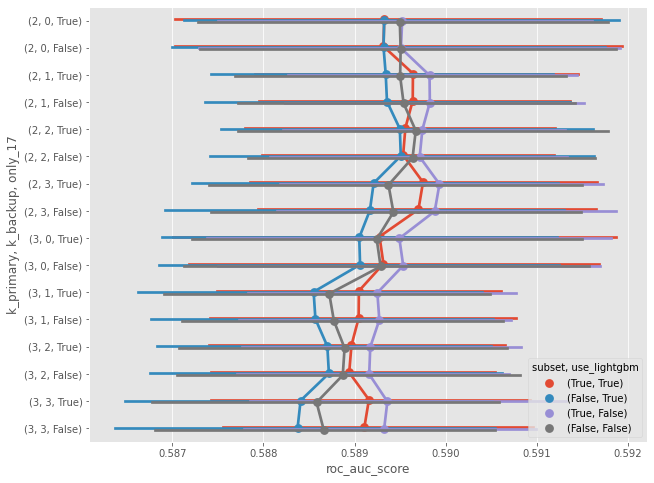

In [79]:

vert_cols = ["k_primary", "k_backup", "only_17"]
hue_cols = ["subset", "use_lightgbm"]

fig, ax = plt.subplots(figsize=(10, 8))
sns.pointplot(data=results, x="roc_auc_score", y=results[vert_cols].apply(tuple, axis=1), hue=results[hue_cols].apply(tuple, axis=1), ax=ax, dodge=True)
ax.set_ylabel(", ".join(vert_cols))
ax.legend(title=", ".join(hue_cols))
plt.show()

The clearest differentiator here is using a subset without lightgbm seems to be the best, and less features are generally better than more.

Using 2 features in the primary model with 1, 2, or 3 in the backup scores the best.


#### Test Groups = 1


In [81]:
num_cols = [
    col
    for col in train.select_dtypes(np.number).columns
    if col not in ["id", "failure"]
]
pred_cols = [col for col in num_cols if col not in ["id", "failure"]]


train_ = train.copy()
train_.product_code = train_.product_code.astype("category")

df_list = []
for use_lightgbm in [True, False]:
    for subset in [True, False]:
        for k_primary in [2, 3]:
            for k_backup in [0, 1, 2, 3]:
                for only_17 in [True, False]:
                    print(
                        f"{use_lightgbm = } {subset = } {k_primary = } {k_backup = }"
                    )

                    # Define iterative regressor
                    if use_lightgbm:
                        regressor = LGBMRegressor(
                            n_estimators=30, num_leaves=5
                        )
                    else:
                        regressor = Pipeline(
                            [("si", SimpleImputer()), ("clf", Ridge())]
                        )

                    # Define classifier(s)
                    clf_primary = Pipeline(
                        [
                            ("si", SimpleImputer()),
                            ("fs", SelectKBest(k=k_primary)),
                            ("lr", LogisticRegression(max_iter=400)),
                        ]
                    )
                    if k_backup > 0:
                        clf_backup = Pipeline(
                            [
                                ("si", SimpleImputer()),
                                ("fs", SelectKBest(k=k_backup)),
                                ("lr", LogisticRegression(max_iter=400)),
                            ]
                        )
                        est = IterativeGroupClassifier(
                            regressor, clf_primary, backup_est=clf_backup
                        )
                    else:
                        est = IterativeGroupClassifier(regressor, clf_primary)

                    # Subset if desired
                    if subset:
                        curr_pred = [
                            "loading",
                            "attribute_3",
                            "measurement_17",
                        ] + [f"measurement_{i}" for i in range(4, 10)]
                    else:
                        curr_pred = list(pred_cols)

                    # Set imputation columns
                    if only_17:
                        impute_cols = ["measurement_17"]
                    else:
                        impute_cols = None
                    estimators, res = cv_eval(
                        est,
                        train_[curr_pred + ["product_code"]],
                        train_["failure"],
                        group_col="product_code",
                        metrics=[roc_auc_score],
                        test_groups=1,
                        use_groups=not use_lightgbm,
                        impute_cols=impute_cols,
                        fs_func=fs_func,
                    )
                    res["use_lightgbm"] = use_lightgbm
                    res["subset"] = subset
                    res["k_primary"] = k_primary
                    res["k_backup"] = k_backup
                    res["only_17"] = only_17
                    df_list.append(res)
results1 = pd.concat(df_list)


use_lightgbm = True subset = True k_primary = 2 k_backup = 0
('A',)
0.19194580353782462
('B',)
0.19759126834776064
('C',)
0.2169740308618743
('D',)
0.1923974407226195
('E',)
0.20109145652992097
use_lightgbm = True subset = True k_primary = 2 k_backup = 0
('A',)
0.19194580353782462
('B',)
0.19759126834776064
('C',)
0.2169740308618743
('D',)
0.1923974407226195
('E',)
0.20109145652992097
use_lightgbm = True subset = True k_primary = 2 k_backup = 1
('A',)
0.19194580353782462
('B',)
0.19759126834776064
('C',)
0.2169740308618743
('D',)
0.1923974407226195
('E',)
0.20109145652992097
use_lightgbm = True subset = True k_primary = 2 k_backup = 1
('A',)
0.19194580353782462
('B',)
0.19759126834776064
('C',)
0.2169740308618743
('D',)
0.1923974407226195
('E',)
0.20109145652992097
use_lightgbm = True subset = True k_primary = 2 k_backup = 2
('A',)
0.19194580353782462
('B',)
0.19759126834776064
('C',)
0.2169740308618743
('D',)
0.1923974407226195
('E',)
0.20109145652992097
use_lightgbm = True subset = T

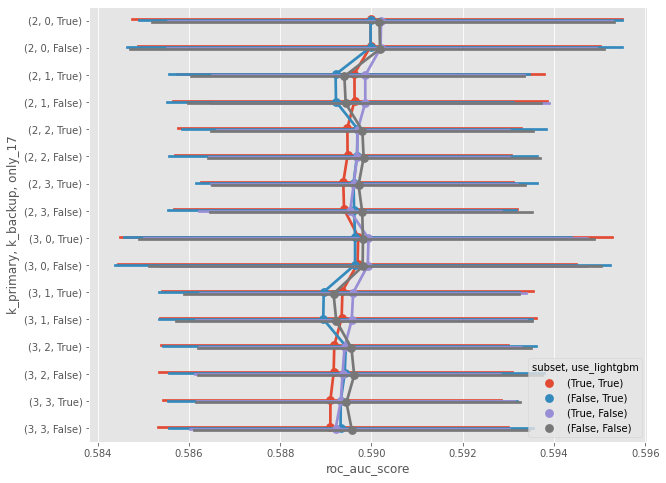

In [82]:

vert_cols = ["k_primary", "k_backup", "only_17"]
hue_cols = ["subset", "use_lightgbm"]

fig, ax = plt.subplots(figsize=(10, 8))
sns.pointplot(data=results1, x="roc_auc_score", y=results1[vert_cols].apply(tuple, axis=1), hue=results1[hue_cols].apply(tuple, axis=1), ax=ax, dodge=True)
ax.set_ylabel(", ".join(vert_cols))
ax.legend(title=", ".join(hue_cols))
plt.show()

So using a single fold does indeed give different answers. The first thing to notice is the scale--there's more variance in this bootstrapped CI's in this approach, but less variance in the means. We see the same general signal that 2 primary features is a little better than three, but no longer see subsettning as better than not.

The best model uses 2 primary features with no backup and no lightgbm, whether subsetting or not.

## Test Submissions

The Public LB is basically another CV fold, with maybe _slightly_ more weight. Since so many solutions perform so similarly on tests, it could be a helpful differentiator.

The solutions that seem the best use 2 features in the primary model and a backup model with 1 or 3 features. The question is does the performance boost justify the added complexity?



In [147]:
k_loading = 2
k_backup = 3

clf_primary = Pipeline([("fs", SelectKBest(k=k_loading)), ("lr", LogisticRegression(max_iter=400))])
if k_backup > 0:
    clf_backup = Pipeline([("fs", SelectKBest(k=k_backup)), ("lr", LogisticRegression(max_iter=400))])
    est = IterativeGroupClassifier(Ridge(), clf_primary, backup_est=clf_backup)
else:
    est = IterativeGroupClassifier(Ridge(), clf_primary)

y_pred = est.fit(train[pred_cols + ["product_code"]], train["failure"], test[pred_cols + ["product_code"]], return_predictions=True)
tmp = test[["id"]].copy()
tmp["failure"] = y_pred[:, 1]
print(tmp.isna().sum())
tmp.head()

id         0
failure    0
dtype: int64


id   failure
0  26570  0.191405
1  26571  0.174865
2  26572  0.185209
3  26573  0.179489
4  26574  0.341734

In [154]:
from pathlib import Path

dfs = []
for file in Path(".").iterdir():
    if str(file).startswith("IterativeGroup"):
        curr = pd.read_csv(file)
        curr["name"] = file
        dfs.append(curr)
curr = tmp.copy()
curr["name"] = f"IterativeGroupImputer_kload{k_loading}_kback{k_backup}.csv"
dfs.append(curr)
all_preds = pd.concat(dfs)
pd.pivot_table(all_preds, index="id", columns="name").corr()

failure  \
name                                            IterativeGroupImputer_kload2_kback0.csv   
        name                                                                              
failure IterativeGroupImputer_kload2_kback0.csv                                1.000000   
        IterativeGroupImputer_kload2_kback2.csv                                0.982275   
        IterativeGroupImputer_kload2_kback3.csv                                0.984265   
        IterativeGroupImputer_kload3_kback0.csv                                0.982570   
        IterativeGroupImputer_kload2_kback3.csv                                0.984265   

                                                                                         \
name                                            IterativeGroupImputer_kload2_kback2.csv   
        name                                                                              
failure IterativeGroupImputer_kload2_kback0.csv                                0.982275   
        IterativeGroupImputer_kload2_kback2.csv                                1.000000   
        IterativeGroupImputer_kload2_kback3.csv                                0.999212   
        IterativeGroupImputer_kload3_kback0.csv                                0.968364   
        IterativeGroupImputer_kload2_kback3.csv                                0.999212   

                                                                                         \
name                                            IterativeGroupImputer_kload2_kback3.csv   
        name                                                                              
failure IterativeGroupImputer_kload2_kback0.csv                                0.984265   
        IterativeGroupImputer_kload2_kback2.csv                                0.999212   
        IterativeGroupImputer_kload2_kback3.csv                                1.000000   
        IterativeGroupImputer_kload3_kback0.csv                                0.970161   
        IterativeGroupImputer_kload2_kback3.csv                                1.000000   

                                                                                         \
name                                            IterativeGroupImputer_kload3_kback0.csv   
        name                                                                              
failure IterativeGroupImputer_kload2_kback0.csv                                0.982570   
        IterativeGroupImputer_kload2_kback2.csv                                0.968364   
        IterativeGroupImputer_kload2_kback3.csv                                0.970161   
        IterativeGroupImputer_kload3_kback0.csv                                1.000000   
        IterativeGroupImputer_kload2_kback3.csv                                0.970161   

                                                                                         
name                                            IterativeGroupImputer_kload2_kback3.csv  
        name                                                                             
failure IterativeGroupImputer_kload2_kback0.csv                                0.984265  
        IterativeGroupImputer_kload2_kback2.csv                                0.999212  
        IterativeGroupImputer_kload2_kback3.csv                                1.000000  
        IterativeGroupImputer_kload3_kback0.csv                                0.970161  
        IterativeGroupImputer_kload2_kback3.csv                                1.000000

In [148]:
tmp.to_csv(f"IterativeGroupImputer_kload{k_loading}_kback{k_backup}.csv", index=False)